In [5]:
import os
import sys
import gc
import json
import random
#fpath = os.path.join(os.getcwd(), 'mobilestereonet', 'datasets')
#sys.path.append(fpath)
from argoverse.data_loading.stereo_dataloader import ArgoverseStereoDataLoader
from argoverse.evaluation.stereo.utils import compute_disparity_error_image
import matplotlib.pyplot as plt
import numpy as np
fpath = os.path.abspath(os.path.join(os.getcwd(), '..'))
fpath_mobilenet = os.path.join(fpath, 'mobilestereonet')
#fpath_utils = os.path.join(fpath, 'utils')
sys.path.append(fpath)
sys.path.append(fpath_mobilenet)
sys.path.append(fpath_utils)
print(fpath)
from mobilestereonet.models import __models__, model_loss
from mobilestereonet.utils import *
from mobilestereonet.utils.KittiColormap import *
from IPython.display import clear_output

import torch
import torch.optim as optim
import time
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

from math import floor
from torch.utils.data import Dataset
from argoverse.utils.camera_stats import RECTIFIED_STEREO_CAMERA_LIST
import torchvision.transforms as transforms

from argoverse.evaluation.stereo.eval import StereoEvaluator
from argoverse.utils.calibration import get_calibration_config
from argoverse.utils.camera_stats import RECTIFIED_STEREO_CAMERA_LIST

from pathlib import Path
from argoverse.evaluation.stereo.utils import compute_disparity_error_image

#import dataset

/home/ubutubiggerbetter/Desktop/249_project/testing_build


ModuleNotFoundError: No module named 'MSNet2D'

In [6]:

#BUild dataset class for the translation between mobilenet and argoverse data
STEREO_FRONT_LEFT_RECT = RECTIFIED_STEREO_CAMERA_LIST[0]
STEREO_FRONT_RIGHT_RECT = RECTIFIED_STEREO_CAMERA_LIST[1]

class ArgoverseDataset(Dataset):
    def __init__(self, data_dir, training, split_name='train', log_ids=["15c802a9-0f0e-3c87-b516-a3fa02f1ecb0"]):

        self.stereo_data_loader = ArgoverseStereoDataLoader(data_dir, split_name)
        self.training = training
        self.left_stereo_img_fpaths = []
        self.right_stereo_img_fpaths = []
        self.disparity_map_fpaths = []
        self.disparity_obj_map_fpaths = []
        for log_id in log_ids:
            if len(self.left_stereo_img_fpaths) == 0:
                self.left_stereo_img_fpaths = self.stereo_data_loader.get_ordered_log_stereo_image_fpaths(
                    log_id = log_id,
                    camera_name=STEREO_FRONT_LEFT_RECT
                )
                self.right_stereo_img_fpaths = self.stereo_data_loader.get_ordered_log_stereo_image_fpaths(
                    log_id = log_id, 
                    camera_name = STEREO_FRONT_RIGHT_RECT
                )

                self.disparity_map_fpaths = self.stereo_data_loader.get_ordered_log_disparity_map_fpaths(
                    log_id = log_id,
                    disparity_name="stereo_front_left_rect_disparity"
                )

                self.disparity_obj_map_fpaths = self.stereo_data_loader.get_ordered_log_disparity_map_fpaths(
                    log_id = log_id, 
                    disparity_name = "stereo_front_left_rect_objects_disparity"
                )
            else:
                self.left_stereo_img_fpaths = self.left_stereo_img_fpaths + self.stereo_data_loader.get_ordered_log_stereo_image_fpaths(
                        log_id = log_id,
                        camera_name=STEREO_FRONT_LEFT_RECT
                    )
                
                self.right_stereo_img_fpaths = self.right_stereo_img_fpaths + self.stereo_data_loader.get_ordered_log_stereo_image_fpaths(
                    log_id = log_id, 
                    camera_name = STEREO_FRONT_RIGHT_RECT
                )

                self.disparity_map_fpaths = self.disparity_map_fpaths+ self.stereo_data_loader.get_ordered_log_disparity_map_fpaths(
                    log_id = log_id,
                    disparity_name="stereo_front_left_rect_disparity"
                )

                self.disparity_obj_map_fpaths = self.disparity_obj_map_fpaths + self.stereo_data_loader.get_ordered_log_disparity_map_fpaths(
                    log_id = log_id, 
                    disparity_name = "stereo_front_left_rect_objects_disparity"
                )

    def load_path(self):
        print('loading path')
        #I believe this returns the paths for desired data
        #optional defintion
    def get_left_image(self, index, cropped=False):
        #Assumes that the cropping is consistent with test functionality
        left_img =  self.stereo_data_loader.get_rectified_stereo_image(self.left_stereo_img_fpaths[index])
        if cropped:
            crop_w, crop_h = 960, 512
            h, w , c = left_img.shape
            x_start = floor((w - crop_w)/2)
            y_start = floor((h - crop_h)/2)        
            left_img = left_img[y_start:y_start+crop_h, x_start:x_start+crop_w,:]
        
        return left_img

    def get_right_image(self, index, cropped=False):
        #Assumes that the cropping is consistent with test functionality
        right_img = self.stereo_data_loader.get_rectified_stereo_image(self.right_stereo_img_fpaths[index])
        if cropped:
            crop_w, crop_h = 960, 512
            h, w , c = right_img.shape
            x_start = floor((w - crop_w)/2)
            y_start = floor((h - crop_h)/2)        
            right_img = right_img[y_start:y_start+crop_h, x_start:x_start+crop_w,:]

        return right_img

    def get_disparity_image(self, index, cropped=False):
        stereo_front_left_rect_disparity = self.stereo_data_loader.get_disparity_map(self.disparity_map_fpaths[index])
        if cropped:
            crop_w, crop_h = 960, 512
            h, w  = stereo_front_left_rect_disparity.shape
            x_start = floor((w - crop_w)/2)
            y_start = floor((h - crop_h)/2)
            stereo_front_left_rect_disparity = stereo_front_left_rect_disparity[y_start:y_start+crop_h, x_start:x_start+crop_w]
        return stereo_front_left_rect_disparity


    def load_disp(self):
        #optinoal again, looks like it reads a depth map or disparity map
        #from a pfm (floating point image map file format), then returns that
        print('Loading disparity')
        
    def __len__(self):
        #specifies the length of the dataset
        return len(self.left_stereo_img_fpaths)
    def get_transform():
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __getitem__(self, index):
        #required function, expected return format of:
        #dictionary, with keys left (leftimg), right (rightimg),
        #   disparity (disparity), top_pad(seems like always 0), 
        #right_pad (seems like always 0), and left_filename (left image filename)
        left_img = self.stereo_data_loader.get_rectified_stereo_image(self.left_stereo_img_fpaths[index])
        right_img = self.stereo_data_loader.get_rectified_stereo_image(self.right_stereo_img_fpaths[index])
        stereo_front_left_rect_disparity = self.stereo_data_loader.get_disparity_map(self.disparity_map_fpaths[index])
        stereo_front_left_rect_objects_disparity = self.stereo_data_loader.get_disparity_map(self.disparity_obj_map_fpaths[index])

        mean = [0.485, 0.456, 0.406]

        std = [0.229, 0.224, 0.225]
        

        if self.training:
            #Need to crop...
            crop_w, crop_h = 512, 256
            h, w , c = left_img.shape
            #some number b/t 0 and all the way to edge (top or right)
            x1 = random.randint(0, w-crop_w)
            y1 = random.randint(0, h - crop_h)

            T = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)])
            
            left_img_t = T(left_img)
            left_img_t = transforms.functional.crop(left_img_t, y1, x1, crop_h, crop_w)
            right_img_t = T(right_img)
            right_img_t = transforms.functional.crop(right_img_t, y1, x1, crop_h, crop_w)
            #print('y1: ', y1, 'y1+crop_h', y1+crop_h, 'x1: ', x1, 'x1+crop_w', x1+crop_w)
            stereo_front_left_rect_disparity = stereo_front_left_rect_disparity[y1:y1+crop_h, x1:x1+crop_w]
            
            return {"left": left_img_t,
                "right": right_img_t,
                "disparity": stereo_front_left_rect_disparity}
        else:
            #Need to crop...
            crop_w, crop_h = 960, 512
            h, w , c = left_img.shape

            x_start = floor((w - crop_w)/2)
            y_start = floor((h - crop_h)/2)
            
            T = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)])

            #center crop:
            left_img_t = T(left_img)
            #print('y_start: ', y_start, 'x_start: ', x_start, 'crop_h: ', crop_h, 'crop_w:', crop_w)
            left_img_t = transforms.functional.crop(left_img_t, y_start, x_start, crop_h, crop_w)
            right_img_t = T(right_img)
            right_img_t = transforms.functional.crop(right_img_t, y_start, x_start, crop_h, crop_w)
            stereo_front_left_rect_disparity = stereo_front_left_rect_disparity[y_start:y_start+crop_h, x_start:x_start+crop_w]
            stereo_front_left_rect_objects_disparity = stereo_front_left_rect_objects_disparity[y_start:y_start+crop_h, x_start:x_start+crop_w]
            tmp_T = transforms.ToTensor()
            left_truth_image = tmp_T(self.get_left_image(index, cropped=True))
            right_truth_image = tmp_T(self.get_right_image(index, cropped=True))
            return {"left": left_img_t,
                "right": right_img_t,
                "disparity": stereo_front_left_rect_disparity,
                "disparity_obj": stereo_front_left_rect_objects_disparity,
                "top_pad": 0,
                "right_pad":0,
                "left_filename": self.left_stereo_img_fpaths[index],
                "left_truth_img": left_truth_image,
                "right_truth_img": right_truth_image}


In [7]:
#the 192 is default max disparity
max_disp = 192
# create summary logger
logdir = '.'
logger = SummaryWriter(logdir)

### The following is for training, if already trained then skip to Test

In [167]:
data_dir = "/media/sf_shared/data"
split_name = "train"
log_ids = ['08a8b7f0-c317-3bdb-b3dc-b7c9b6d033e2', '0ef28d5c-ae34-370b-99e7-6709e1c4b929', '10b3a1d8-e56c-38be-aaf7-ef2f862a5c4e', 
'3138907e-1f8a-362f-8f3d-773f795a0d01',  'c6911883-1843-3727-8eaa-41dc8cda8993',
'3d20ae25-5b29-320d-8bae-f03e9dc177b9',  'cd38ac0b-c5a6-3743-a148-f4f7b804ed17',
'4137e94a-c5da-38bd-ad06-6d57b24bccd0',  'd4d9e91f-0f8e-334d-bd0e-0d062467308a',
'45753856-4575-4575-4575-345754906624',  'dcdcd8b3-0ba1-3218-b2ea-7bb965aad3f0',
'52af191b-ba56-326c-b569-e37790db40f3',  'de777454-df62-3d5a-a1ce-2edb5e5d4922',
'53037376-5303-5303-5303-553038557184',  'e9bb51af-1112-34c2-be3e-7ebe826649b4',
'53213cf0-540b-3b5a-9900-d24d1d41bda0',  'ebe7a98b-d383-343b-96d6-9e681e2c6a36',
'577ea60d-7cc0-34a4-a8ff-0401e5ab9c62',  'f0826a9f-f46e-3c27-97af-87a77f7899cd',
'5c251c22-11b2-3278-835c-0cf3cdee3f44',  'f3fb839e-0aa2-342b-81c3-312b80be44f9',
'649750f3-0163-34eb-a102-7aaf5384eaec',  'fa0b626f-03df-35a0-8447-021088814b8b',
'64c12551-adb9-36e3-a0c1-e43a0e9f3845']


argoverse_ds = ArgoverseDataset(data_dir, True, split_name, log_ids=log_ids)
TrainImgLoader = DataLoader(argoverse_ds, 1, shuffle=False, num_workers = 4)


In [168]:

model = __models__['MSNet2D'](max_disp)
learning_rate = .001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))


In [169]:
def train(TrainImgLoader, start_epoch = 0, epochs = 1, lrepochs= "200:10", summary_freq = 10, 
    train_limit = 100000, max_disp = 192, save_freq = 1):
    
    best_checkpoint_loss = 100
    for epoch_idx in range(start_epoch, epochs):
        adjust_learning_rate(optimizer, epoch_idx, learning_rate, lrepochs)
        for batch_idx, sample in enumerate(TrainImgLoader):
            global_step = len(TrainImgLoader) * epoch_idx + batch_idx
            start_time = time.time()
            do_summary = global_step % summary_freq == 0
            
            loss, scalar_outputs, image_outputs = train_sample(sample, compute_metrics=do_summary, max_disp=max_disp)
            if do_summary:
                save_scalars(logger, 'train', scalar_outputs, global_step)
                save_images(logger, 'train', image_outputs, global_step)
            del scalar_outputs, image_outputs
            print('Epoch {}/{}, Iter {}/{}, train loss = {:.3f}, time = {:.3f}'.format(epoch_idx, epochs,
                                                                                        batch_idx,
                                                                                        len(TrainImgLoader), loss,
                                                                                        time.time() - start_time))
            if batch_idx > train_limit:
                break  
        if (epoch_idx + 1)  % save_freq == 0:
            checkpoint_data = {'epoch': epoch_idx, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
            torch.save(checkpoint_data, "{}/checkpoint_{:0>6}.ckpt".format(logdir, epoch_idx))

        gc.collect()       
               

In [170]:
# train one sample
def train_sample(sample, max_disp = 192, compute_metrics=False):
    model.train()

    imgL, imgR, disp_gt = sample['left'], sample['right'], sample['disparity']

    optimizer.zero_grad()
    disp_ests = model(imgL, imgR)
    mask = (disp_gt < max_disp) & (disp_gt > 0)
    loss = model_loss(disp_ests, disp_gt, mask)

    scalar_outputs = {"loss": loss}
    image_outputs = {"disp_est": disp_ests, "disp_gt": disp_gt, "imgL": imgL, "imgR": imgR}
    if compute_metrics:
        with torch.no_grad():
            image_outputs["errormap"] = [disp_error_image_func(disp_est, disp_gt) for disp_est in disp_ests]
            scalar_outputs["EPE"] = [EPE_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
            scalar_outputs["D1"] = [D1_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
            scalar_outputs["Thres1"] = [Thres_metric(disp_est, disp_gt, mask, 1.0) for disp_est in disp_ests]
            scalar_outputs["Thres2"] = [Thres_metric(disp_est, disp_gt, mask, 2.0) for disp_est in disp_ests]
            scalar_outputs["Thres3"] = [Thres_metric(disp_est, disp_gt, mask, 3.0) for disp_est in disp_ests]
    loss.backward()
    optimizer.step()

    return tensor2float(loss), tensor2float(scalar_outputs), image_outputs

In [172]:
start_epoch = 0
epochs = 4
lrepochs = "4:10"
summary_freq = 10
save_freq = 1
train(TrainImgLoader, start_epoch = start_epoch, epochs = epochs, lrepochs= lrepochs, summary_freq = summary_freq, 
    max_disp = 192, save_freq = save_freq)

Downscale learning rate at epochs: [4], downscale rate: 10.0
Setting learning rate to 0.001
Epoch 0/4, Iter 0/2174, train loss = 99.976, time = 25.887
Epoch 0/4, Iter 1/2174, train loss = 195.983, time = 14.913
Epoch 0/4, Iter 2/2174, train loss = 194.900, time = 15.125
Epoch 0/4, Iter 3/2174, train loss = nan, time = 15.004
Epoch 0/4, Iter 4/2174, train loss = nan, time = 16.638
Epoch 0/4, Iter 5/2174, train loss = 43.091, time = 14.287
Epoch 0/4, Iter 6/2174, train loss = nan, time = 18.053
Epoch 0/4, Iter 7/2174, train loss = nan, time = 14.124
Epoch 0/4, Iter 8/2174, train loss = 66.427, time = 14.929
Epoch 0/4, Iter 9/2174, train loss = 81.738, time = 16.358
Epoch 0/4, Iter 10/2174, train loss = 47.595, time = 16.014
Epoch 0/4, Iter 11/2174, train loss = 88.584, time = 14.321
Epoch 0/4, Iter 12/2174, train loss = 33.964, time = 15.614
Epoch 0/4, Iter 13/2174, train loss = nan, time = 14.093
Epoch 0/4, Iter 14/2174, train loss = nan, time = 14.564
Epoch 0/4, Iter 15/2174, train los

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 60/2174, train loss = nan, time = 13.152
Epoch 0/4, Iter 61/2174, train loss = 161.813, time = 12.977
Epoch 0/4, Iter 62/2174, train loss = nan, time = 12.754
Epoch 0/4, Iter 63/2174, train loss = 120.977, time = 12.851
Epoch 0/4, Iter 64/2174, train loss = nan, time = 12.420
Epoch 0/4, Iter 65/2174, train loss = nan, time = 12.594
Epoch 0/4, Iter 66/2174, train loss = 94.699, time = 13.228
Epoch 0/4, Iter 67/2174, train loss = 18.399, time = 12.597
Epoch 0/4, Iter 68/2174, train loss = 212.857, time = 12.882
Epoch 0/4, Iter 69/2174, train loss = nan, time = 12.662
Epoch 0/4, Iter 70/2174, train loss = 195.335, time = 13.695
Epoch 0/4, Iter 71/2174, train loss = 131.580, time = 12.161
Epoch 0/4, Iter 72/2174, train loss = 98.174, time = 12.183
Epoch 0/4, Iter 73/2174, train loss = nan, time = 12.797
Epoch 0/4, Iter 74/2174, train loss = 171.313, time = 12.240
Epoch 0/4, Iter 75/2174, train loss = 19.205, time = 12.195
Epoch 0/4, Iter 76/2174, train loss = 45.512, time =

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 140/2174, train loss = nan, time = 13.526
Epoch 0/4, Iter 141/2174, train loss = 134.462, time = 12.734
Epoch 0/4, Iter 142/2174, train loss = 80.969, time = 12.438
Epoch 0/4, Iter 143/2174, train loss = nan, time = 13.106
Epoch 0/4, Iter 144/2174, train loss = nan, time = 14.313
Epoch 0/4, Iter 145/2174, train loss = 61.054, time = 12.554
Epoch 0/4, Iter 146/2174, train loss = nan, time = 12.490
Epoch 0/4, Iter 147/2174, train loss = nan, time = 12.813
Epoch 0/4, Iter 148/2174, train loss = nan, time = 12.675
Epoch 0/4, Iter 149/2174, train loss = nan, time = 13.720
Epoch 0/4, Iter 150/2174, train loss = 40.287, time = 15.994
Epoch 0/4, Iter 151/2174, train loss = nan, time = 12.394
Epoch 0/4, Iter 152/2174, train loss = nan, time = 12.786
Epoch 0/4, Iter 153/2174, train loss = 76.599, time = 13.069
Epoch 0/4, Iter 154/2174, train loss = 126.960, time = 13.052
Epoch 0/4, Iter 155/2174, train loss = 80.448, time = 16.093
Epoch 0/4, Iter 156/2174, train loss = nan, time 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 160/2174, train loss = nan, time = 13.003
Epoch 0/4, Iter 161/2174, train loss = 94.504, time = 12.382
Epoch 0/4, Iter 162/2174, train loss = nan, time = 12.337
Epoch 0/4, Iter 163/2174, train loss = 65.130, time = 12.165
Epoch 0/4, Iter 164/2174, train loss = nan, time = 12.831
Epoch 0/4, Iter 165/2174, train loss = 57.796, time = 12.350
Epoch 0/4, Iter 166/2174, train loss = 59.242, time = 12.421
Epoch 0/4, Iter 167/2174, train loss = 90.899, time = 12.812
Epoch 0/4, Iter 168/2174, train loss = 156.947, time = 12.825
Epoch 0/4, Iter 169/2174, train loss = nan, time = 12.231
Epoch 0/4, Iter 170/2174, train loss = 149.894, time = 13.130
Epoch 0/4, Iter 171/2174, train loss = nan, time = 12.145
Epoch 0/4, Iter 172/2174, train loss = 67.536, time = 12.567
Epoch 0/4, Iter 173/2174, train loss = 173.344, time = 12.445
Epoch 0/4, Iter 174/2174, train loss = 199.387, time = 12.886
Epoch 0/4, Iter 175/2174, train loss = 30.474, time = 12.351
Epoch 0/4, Iter 176/2174, train los

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 180/2174, train loss = nan, time = 12.925
Epoch 0/4, Iter 181/2174, train loss = nan, time = 12.034
Epoch 0/4, Iter 182/2174, train loss = nan, time = 12.255
Epoch 0/4, Iter 183/2174, train loss = 241.576, time = 12.918
Epoch 0/4, Iter 184/2174, train loss = nan, time = 12.775
Epoch 0/4, Iter 185/2174, train loss = 30.943, time = 12.473
Epoch 0/4, Iter 186/2174, train loss = nan, time = 12.475
Epoch 0/4, Iter 187/2174, train loss = 207.946, time = 11.967
Epoch 0/4, Iter 188/2174, train loss = 54.719, time = 12.082
Epoch 0/4, Iter 189/2174, train loss = 182.888, time = 13.456
Epoch 0/4, Iter 190/2174, train loss = 71.256, time = 13.287
Epoch 0/4, Iter 191/2174, train loss = 154.237, time = 12.353
Epoch 0/4, Iter 192/2174, train loss = 22.472, time = 16.158
Epoch 0/4, Iter 193/2174, train loss = 92.206, time = 12.702
Epoch 0/4, Iter 194/2174, train loss = 94.711, time = 12.900
Epoch 0/4, Iter 195/2174, train loss = 83.569, time = 12.224
Epoch 0/4, Iter 196/2174, train los

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 230/2174, train loss = nan, time = 13.032
Epoch 0/4, Iter 231/2174, train loss = nan, time = 12.165
Epoch 0/4, Iter 232/2174, train loss = 61.749, time = 12.137
Epoch 0/4, Iter 233/2174, train loss = 156.701, time = 12.121
Epoch 0/4, Iter 234/2174, train loss = nan, time = 12.132
Epoch 0/4, Iter 235/2174, train loss = nan, time = 12.562
Epoch 0/4, Iter 236/2174, train loss = nan, time = 12.548
Epoch 0/4, Iter 237/2174, train loss = 37.306, time = 12.232
Epoch 0/4, Iter 238/2174, train loss = nan, time = 12.546
Epoch 0/4, Iter 239/2174, train loss = nan, time = 12.840
Epoch 0/4, Iter 240/2174, train loss = 189.370, time = 13.149
Epoch 0/4, Iter 241/2174, train loss = nan, time = 15.836
Epoch 0/4, Iter 242/2174, train loss = 183.318, time = 12.627
Epoch 0/4, Iter 243/2174, train loss = 165.154, time = 11.998
Epoch 0/4, Iter 244/2174, train loss = nan, time = 12.560
Epoch 0/4, Iter 245/2174, train loss = 143.201, time = 13.023
Epoch 0/4, Iter 246/2174, train loss = 63.405,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 280/2174, train loss = nan, time = 13.940
Epoch 0/4, Iter 281/2174, train loss = 48.064, time = 12.087
Epoch 0/4, Iter 282/2174, train loss = 138.124, time = 12.854
Epoch 0/4, Iter 283/2174, train loss = 209.092, time = 12.416
Epoch 0/4, Iter 284/2174, train loss = nan, time = 12.660
Epoch 0/4, Iter 285/2174, train loss = 110.564, time = 14.828
Epoch 0/4, Iter 286/2174, train loss = 50.655, time = 12.105
Epoch 0/4, Iter 287/2174, train loss = nan, time = 12.813
Epoch 0/4, Iter 288/2174, train loss = nan, time = 12.595
Epoch 0/4, Iter 289/2174, train loss = 154.794, time = 12.268


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 290/2174, train loss = nan, time = 14.066
Epoch 0/4, Iter 291/2174, train loss = 130.252, time = 12.067
Epoch 0/4, Iter 292/2174, train loss = nan, time = 12.586
Epoch 0/4, Iter 293/2174, train loss = 95.650, time = 12.136
Epoch 0/4, Iter 294/2174, train loss = 89.276, time = 12.215
Epoch 0/4, Iter 295/2174, train loss = 95.870, time = 14.486
Epoch 0/4, Iter 296/2174, train loss = nan, time = 12.192
Epoch 0/4, Iter 297/2174, train loss = 239.947, time = 12.037
Epoch 0/4, Iter 298/2174, train loss = 80.600, time = 12.094
Epoch 0/4, Iter 299/2174, train loss = 220.941, time = 12.048
Epoch 0/4, Iter 300/2174, train loss = 45.476, time = 13.266
Epoch 0/4, Iter 301/2174, train loss = 59.011, time = 12.336
Epoch 0/4, Iter 302/2174, train loss = 46.363, time = 12.414
Epoch 0/4, Iter 303/2174, train loss = nan, time = 12.502
Epoch 0/4, Iter 304/2174, train loss = 160.020, time = 12.622
Epoch 0/4, Iter 305/2174, train loss = 119.333, time = 12.632
Epoch 0/4, Iter 306/2174, train

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 330/2174, train loss = nan, time = 12.782
Epoch 0/4, Iter 331/2174, train loss = 175.791, time = 12.488
Epoch 0/4, Iter 332/2174, train loss = 38.832, time = 12.003
Epoch 0/4, Iter 333/2174, train loss = nan, time = 12.689
Epoch 0/4, Iter 334/2174, train loss = 109.072, time = 11.919
Epoch 0/4, Iter 335/2174, train loss = 110.394, time = 12.824
Epoch 0/4, Iter 336/2174, train loss = 74.291, time = 16.555
Epoch 0/4, Iter 337/2174, train loss = 34.951, time = 12.820
Epoch 0/4, Iter 338/2174, train loss = 224.021, time = 14.597
Epoch 0/4, Iter 339/2174, train loss = 76.327, time = 12.276
Epoch 0/4, Iter 340/2174, train loss = 26.172, time = 12.746
Epoch 0/4, Iter 341/2174, train loss = nan, time = 12.365
Epoch 0/4, Iter 342/2174, train loss = 57.968, time = 12.547
Epoch 0/4, Iter 343/2174, train loss = nan, time = 11.947
Epoch 0/4, Iter 344/2174, train loss = nan, time = 12.038
Epoch 0/4, Iter 345/2174, train loss = 117.130, time = 11.936
Epoch 0/4, Iter 346/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 470/2174, train loss = nan, time = 12.477
Epoch 0/4, Iter 471/2174, train loss = nan, time = 12.108
Epoch 0/4, Iter 472/2174, train loss = 98.983, time = 11.860
Epoch 0/4, Iter 473/2174, train loss = 35.563, time = 12.250
Epoch 0/4, Iter 474/2174, train loss = 97.738, time = 12.699
Epoch 0/4, Iter 475/2174, train loss = 219.179, time = 12.440
Epoch 0/4, Iter 476/2174, train loss = 99.037, time = 12.534
Epoch 0/4, Iter 477/2174, train loss = 116.932, time = 12.062
Epoch 0/4, Iter 478/2174, train loss = 62.246, time = 12.698
Epoch 0/4, Iter 479/2174, train loss = 45.786, time = 12.323


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 480/2174, train loss = nan, time = 12.794
Epoch 0/4, Iter 481/2174, train loss = nan, time = 12.090
Epoch 0/4, Iter 482/2174, train loss = nan, time = 11.964
Epoch 0/4, Iter 483/2174, train loss = 51.444, time = 12.183
Epoch 0/4, Iter 484/2174, train loss = 61.050, time = 12.784
Epoch 0/4, Iter 485/2174, train loss = 32.979, time = 12.228
Epoch 0/4, Iter 486/2174, train loss = 21.261, time = 12.025
Epoch 0/4, Iter 487/2174, train loss = 98.618, time = 12.368
Epoch 0/4, Iter 488/2174, train loss = nan, time = 12.340
Epoch 0/4, Iter 489/2174, train loss = 59.716, time = 14.713
Epoch 0/4, Iter 490/2174, train loss = 149.875, time = 13.285
Epoch 0/4, Iter 491/2174, train loss = 10.181, time = 12.190
Epoch 0/4, Iter 492/2174, train loss = 44.601, time = 12.019
Epoch 0/4, Iter 493/2174, train loss = nan, time = 12.024
Epoch 0/4, Iter 494/2174, train loss = nan, time = 14.276
Epoch 0/4, Iter 495/2174, train loss = 57.504, time = 12.625
Epoch 0/4, Iter 496/2174, train loss = 11

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 500/2174, train loss = nan, time = 13.107
Epoch 0/4, Iter 501/2174, train loss = 44.271, time = 12.102
Epoch 0/4, Iter 502/2174, train loss = nan, time = 12.428
Epoch 0/4, Iter 503/2174, train loss = nan, time = 12.869
Epoch 0/4, Iter 504/2174, train loss = 52.445, time = 12.947
Epoch 0/4, Iter 505/2174, train loss = 209.044, time = 12.295
Epoch 0/4, Iter 506/2174, train loss = 180.383, time = 12.077
Epoch 0/4, Iter 507/2174, train loss = 23.829, time = 12.479
Epoch 0/4, Iter 508/2174, train loss = nan, time = 12.708
Epoch 0/4, Iter 509/2174, train loss = 186.316, time = 12.165


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 510/2174, train loss = nan, time = 13.208
Epoch 0/4, Iter 511/2174, train loss = 27.672, time = 12.142
Epoch 0/4, Iter 512/2174, train loss = 14.215, time = 12.676
Epoch 0/4, Iter 513/2174, train loss = 69.686, time = 12.487
Epoch 0/4, Iter 514/2174, train loss = 127.736, time = 12.441
Epoch 0/4, Iter 515/2174, train loss = nan, time = 12.815
Epoch 0/4, Iter 516/2174, train loss = 201.261, time = 12.132
Epoch 0/4, Iter 517/2174, train loss = 95.281, time = 12.248
Epoch 0/4, Iter 518/2174, train loss = 57.686, time = 12.887
Epoch 0/4, Iter 519/2174, train loss = nan, time = 12.560
Epoch 0/4, Iter 520/2174, train loss = 169.217, time = 13.256
Epoch 0/4, Iter 521/2174, train loss = nan, time = 12.089
Epoch 0/4, Iter 522/2174, train loss = nan, time = 12.397
Epoch 0/4, Iter 523/2174, train loss = 142.294, time = 12.751
Epoch 0/4, Iter 524/2174, train loss = 186.137, time = 12.150
Epoch 0/4, Iter 525/2174, train loss = 53.483, time = 12.621
Epoch 0/4, Iter 526/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 540/2174, train loss = nan, time = 12.582
Epoch 0/4, Iter 541/2174, train loss = 135.115, time = 12.197
Epoch 0/4, Iter 542/2174, train loss = 195.973, time = 12.311
Epoch 0/4, Iter 543/2174, train loss = 143.889, time = 12.832
Epoch 0/4, Iter 544/2174, train loss = nan, time = 14.896
Epoch 0/4, Iter 545/2174, train loss = 76.947, time = 13.958
Epoch 0/4, Iter 546/2174, train loss = 138.641, time = 12.101
Epoch 0/4, Iter 547/2174, train loss = 67.118, time = 12.022
Epoch 0/4, Iter 548/2174, train loss = 134.522, time = 12.685
Epoch 0/4, Iter 549/2174, train loss = 90.678, time = 12.124
Epoch 0/4, Iter 550/2174, train loss = 159.412, time = 13.315
Epoch 0/4, Iter 551/2174, train loss = nan, time = 12.250
Epoch 0/4, Iter 552/2174, train loss = 70.914, time = 12.783
Epoch 0/4, Iter 553/2174, train loss = nan, time = 12.562
Epoch 0/4, Iter 554/2174, train loss = 140.377, time = 12.445
Epoch 0/4, Iter 555/2174, train loss = nan, time = 11.982
Epoch 0/4, Iter 556/2174, train 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 630/2174, train loss = nan, time = 12.793
Epoch 0/4, Iter 631/2174, train loss = 57.189, time = 12.025
Epoch 0/4, Iter 632/2174, train loss = 64.485, time = 11.961
Epoch 0/4, Iter 633/2174, train loss = nan, time = 13.893
Epoch 0/4, Iter 634/2174, train loss = 44.257, time = 12.725
Epoch 0/4, Iter 635/2174, train loss = nan, time = 11.975
Epoch 0/4, Iter 636/2174, train loss = 42.844, time = 12.184
Epoch 0/4, Iter 637/2174, train loss = 182.832, time = 12.454
Epoch 0/4, Iter 638/2174, train loss = 35.048, time = 12.433
Epoch 0/4, Iter 639/2174, train loss = 39.129, time = 12.289
Epoch 0/4, Iter 640/2174, train loss = 162.356, time = 12.804
Epoch 0/4, Iter 641/2174, train loss = nan, time = 11.906
Epoch 0/4, Iter 642/2174, train loss = 76.371, time = 12.558
Epoch 0/4, Iter 643/2174, train loss = 32.292, time = 12.555
Epoch 0/4, Iter 644/2174, train loss = 54.430, time = 12.053
Epoch 0/4, Iter 645/2174, train loss = 78.183, time = 12.621
Epoch 0/4, Iter 646/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 660/2174, train loss = nan, time = 12.808
Epoch 0/4, Iter 661/2174, train loss = 69.983, time = 12.236
Epoch 0/4, Iter 662/2174, train loss = nan, time = 12.438
Epoch 0/4, Iter 663/2174, train loss = nan, time = 14.005
Epoch 0/4, Iter 664/2174, train loss = nan, time = 12.139
Epoch 0/4, Iter 665/2174, train loss = 61.481, time = 11.923
Epoch 0/4, Iter 666/2174, train loss = 60.699, time = 12.664
Epoch 0/4, Iter 667/2174, train loss = 50.362, time = 12.049
Epoch 0/4, Iter 668/2174, train loss = 33.949, time = 12.206
Epoch 0/4, Iter 669/2174, train loss = 26.484, time = 12.578


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 670/2174, train loss = nan, time = 13.183
Epoch 0/4, Iter 671/2174, train loss = 25.922, time = 11.988
Epoch 0/4, Iter 672/2174, train loss = nan, time = 12.343
Epoch 0/4, Iter 673/2174, train loss = nan, time = 12.504
Epoch 0/4, Iter 674/2174, train loss = nan, time = 12.187
Epoch 0/4, Iter 675/2174, train loss = 15.976, time = 12.037
Epoch 0/4, Iter 676/2174, train loss = nan, time = 12.598
Epoch 0/4, Iter 677/2174, train loss = 122.565, time = 12.569
Epoch 0/4, Iter 678/2174, train loss = nan, time = 12.009
Epoch 0/4, Iter 679/2174, train loss = 13.005, time = 12.995
Epoch 0/4, Iter 680/2174, train loss = 152.532, time = 12.808
Epoch 0/4, Iter 681/2174, train loss = 42.543, time = 12.112
Epoch 0/4, Iter 682/2174, train loss = 136.739, time = 12.820
Epoch 0/4, Iter 683/2174, train loss = nan, time = 12.546
Epoch 0/4, Iter 684/2174, train loss = nan, time = 12.448
Epoch 0/4, Iter 685/2174, train loss = 135.358, time = 12.223
Epoch 0/4, Iter 686/2174, train loss = 127.6

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 690/2174, train loss = nan, time = 12.509
Epoch 0/4, Iter 691/2174, train loss = nan, time = 11.985
Epoch 0/4, Iter 692/2174, train loss = 144.970, time = 13.510
Epoch 0/4, Iter 693/2174, train loss = 147.707, time = 12.098
Epoch 0/4, Iter 694/2174, train loss = 96.497, time = 12.526
Epoch 0/4, Iter 695/2174, train loss = 116.652, time = 12.590
Epoch 0/4, Iter 696/2174, train loss = nan, time = 12.184
Epoch 0/4, Iter 697/2174, train loss = nan, time = 12.329
Epoch 0/4, Iter 698/2174, train loss = 31.308, time = 12.083
Epoch 0/4, Iter 699/2174, train loss = nan, time = 13.259


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 700/2174, train loss = nan, time = 13.010
Epoch 0/4, Iter 701/2174, train loss = nan, time = 12.018
Epoch 0/4, Iter 702/2174, train loss = 187.832, time = 12.714
Epoch 0/4, Iter 703/2174, train loss = nan, time = 12.088
Epoch 0/4, Iter 704/2174, train loss = 162.402, time = 14.224
Epoch 0/4, Iter 705/2174, train loss = nan, time = 12.116
Epoch 0/4, Iter 706/2174, train loss = 48.750, time = 11.914
Epoch 0/4, Iter 707/2174, train loss = nan, time = 14.788
Epoch 0/4, Iter 708/2174, train loss = nan, time = 12.051
Epoch 0/4, Iter 709/2174, train loss = 117.682, time = 12.417
Epoch 0/4, Iter 710/2174, train loss = 148.438, time = 12.992
Epoch 0/4, Iter 711/2174, train loss = 129.470, time = 11.924
Epoch 0/4, Iter 712/2174, train loss = 78.929, time = 16.527
Epoch 0/4, Iter 713/2174, train loss = 132.516, time = 12.622
Epoch 0/4, Iter 714/2174, train loss = 201.352, time = 13.113
Epoch 0/4, Iter 715/2174, train loss = 111.029, time = 12.664
Epoch 0/4, Iter 716/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 720/2174, train loss = nan, time = 12.800
Epoch 0/4, Iter 721/2174, train loss = 73.939, time = 12.338
Epoch 0/4, Iter 722/2174, train loss = 50.884, time = 12.150
Epoch 0/4, Iter 723/2174, train loss = 79.336, time = 12.443
Epoch 0/4, Iter 724/2174, train loss = 101.997, time = 16.586
Epoch 0/4, Iter 725/2174, train loss = 146.896, time = 12.542
Epoch 0/4, Iter 726/2174, train loss = nan, time = 12.244
Epoch 0/4, Iter 727/2174, train loss = 13.586, time = 12.053
Epoch 0/4, Iter 728/2174, train loss = 9.394, time = 11.961
Epoch 0/4, Iter 729/2174, train loss = 195.378, time = 13.130
Epoch 0/4, Iter 730/2174, train loss = 55.195, time = 12.578
Epoch 0/4, Iter 731/2174, train loss = 68.200, time = 12.107
Epoch 0/4, Iter 732/2174, train loss = 11.763, time = 12.087
Epoch 0/4, Iter 733/2174, train loss = 108.836, time = 12.419
Epoch 0/4, Iter 734/2174, train loss = 70.649, time = 14.499
Epoch 0/4, Iter 735/2174, train loss = nan, time = 11.882
Epoch 0/4, Iter 736/2174, trai

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 750/2174, train loss = nan, time = 12.804
Epoch 0/4, Iter 751/2174, train loss = nan, time = 12.050
Epoch 0/4, Iter 752/2174, train loss = 112.700, time = 12.721
Epoch 0/4, Iter 753/2174, train loss = 69.044, time = 13.573
Epoch 0/4, Iter 754/2174, train loss = nan, time = 11.961
Epoch 0/4, Iter 755/2174, train loss = nan, time = 13.053
Epoch 0/4, Iter 756/2174, train loss = 144.909, time = 12.327
Epoch 0/4, Iter 757/2174, train loss = 44.846, time = 16.076
Epoch 0/4, Iter 758/2174, train loss = nan, time = 12.659
Epoch 0/4, Iter 759/2174, train loss = 82.418, time = 12.086
Epoch 0/4, Iter 760/2174, train loss = 174.182, time = 13.356
Epoch 0/4, Iter 761/2174, train loss = 181.800, time = 12.140
Epoch 0/4, Iter 762/2174, train loss = 72.498, time = 12.534
Epoch 0/4, Iter 763/2174, train loss = 131.799, time = 12.551
Epoch 0/4, Iter 764/2174, train loss = 68.465, time = 12.104
Epoch 0/4, Iter 765/2174, train loss = 55.996, time = 12.239
Epoch 0/4, Iter 766/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 830/2174, train loss = nan, time = 14.803
Epoch 0/4, Iter 831/2174, train loss = nan, time = 12.228
Epoch 0/4, Iter 832/2174, train loss = 77.883, time = 12.205
Epoch 0/4, Iter 833/2174, train loss = 94.992, time = 11.956
Epoch 0/4, Iter 834/2174, train loss = 59.405, time = 12.086
Epoch 0/4, Iter 835/2174, train loss = nan, time = 12.076
Epoch 0/4, Iter 836/2174, train loss = nan, time = 12.628
Epoch 0/4, Iter 837/2174, train loss = 33.573, time = 12.088
Epoch 0/4, Iter 838/2174, train loss = 27.495, time = 12.743
Epoch 0/4, Iter 839/2174, train loss = 57.494, time = 12.055
Epoch 0/4, Iter 840/2174, train loss = 68.989, time = 13.212
Epoch 0/4, Iter 841/2174, train loss = 53.570, time = 12.611
Epoch 0/4, Iter 842/2174, train loss = 123.489, time = 11.822
Epoch 0/4, Iter 843/2174, train loss = 166.119, time = 12.552
Epoch 0/4, Iter 844/2174, train loss = nan, time = 12.100
Epoch 0/4, Iter 845/2174, train loss = 86.552, time = 12.494
Epoch 0/4, Iter 846/2174, train loss 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 890/2174, train loss = nan, time = 12.597
Epoch 0/4, Iter 891/2174, train loss = 45.497, time = 12.200
Epoch 0/4, Iter 892/2174, train loss = nan, time = 15.720
Epoch 0/4, Iter 893/2174, train loss = 76.659, time = 12.857
Epoch 0/4, Iter 894/2174, train loss = 112.235, time = 12.059
Epoch 0/4, Iter 895/2174, train loss = 87.712, time = 12.543
Epoch 0/4, Iter 896/2174, train loss = 28.497, time = 12.130
Epoch 0/4, Iter 897/2174, train loss = nan, time = 12.894
Epoch 0/4, Iter 898/2174, train loss = 119.828, time = 12.647
Epoch 0/4, Iter 899/2174, train loss = 120.634, time = 12.621
Epoch 0/4, Iter 900/2174, train loss = 122.858, time = 12.678
Epoch 0/4, Iter 901/2174, train loss = 149.308, time = 11.936
Epoch 0/4, Iter 902/2174, train loss = nan, time = 12.557
Epoch 0/4, Iter 903/2174, train loss = nan, time = 11.918
Epoch 0/4, Iter 904/2174, train loss = 133.212, time = 12.426
Epoch 0/4, Iter 905/2174, train loss = 76.682, time = 14.398
Epoch 0/4, Iter 906/2174, train l

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 930/2174, train loss = nan, time = 12.655
Epoch 0/4, Iter 931/2174, train loss = 43.497, time = 12.250
Epoch 0/4, Iter 932/2174, train loss = 27.782, time = 12.212
Epoch 0/4, Iter 933/2174, train loss = 51.145, time = 12.368
Epoch 0/4, Iter 934/2174, train loss = 11.896, time = 11.969
Epoch 0/4, Iter 935/2174, train loss = 49.829, time = 12.439
Epoch 0/4, Iter 936/2174, train loss = 196.319, time = 12.721
Epoch 0/4, Iter 937/2174, train loss = 55.620, time = 12.196
Epoch 0/4, Iter 938/2174, train loss = 90.819, time = 12.637
Epoch 0/4, Iter 939/2174, train loss = 137.393, time = 12.200


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 940/2174, train loss = nan, time = 12.794
Epoch 0/4, Iter 941/2174, train loss = 112.883, time = 12.059
Epoch 0/4, Iter 942/2174, train loss = 66.812, time = 12.101
Epoch 0/4, Iter 943/2174, train loss = 43.072, time = 13.499
Epoch 0/4, Iter 944/2174, train loss = 27.483, time = 12.574
Epoch 0/4, Iter 945/2174, train loss = 20.019, time = 12.618
Epoch 0/4, Iter 946/2174, train loss = 47.636, time = 12.591
Epoch 0/4, Iter 947/2174, train loss = 126.867, time = 12.500
Epoch 0/4, Iter 948/2174, train loss = 74.540, time = 13.091
Epoch 0/4, Iter 949/2174, train loss = nan, time = 12.530
Epoch 0/4, Iter 950/2174, train loss = 110.564, time = 13.193
Epoch 0/4, Iter 951/2174, train loss = nan, time = 12.186
Epoch 0/4, Iter 952/2174, train loss = nan, time = 12.111
Epoch 0/4, Iter 953/2174, train loss = nan, time = 13.687
Epoch 0/4, Iter 954/2174, train loss = 61.471, time = 12.439
Epoch 0/4, Iter 955/2174, train loss = 62.056, time = 12.782
Epoch 0/4, Iter 956/2174, train loss

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1040/2174, train loss = nan, time = 12.689
Epoch 0/4, Iter 1041/2174, train loss = nan, time = 12.877
Epoch 0/4, Iter 1042/2174, train loss = 34.273, time = 12.341
Epoch 0/4, Iter 1043/2174, train loss = 43.482, time = 16.065
Epoch 0/4, Iter 1044/2174, train loss = 29.305, time = 12.301
Epoch 0/4, Iter 1045/2174, train loss = 73.220, time = 13.121
Epoch 0/4, Iter 1046/2174, train loss = 69.194, time = 12.406
Epoch 0/4, Iter 1047/2174, train loss = 36.648, time = 12.600
Epoch 0/4, Iter 1048/2174, train loss = nan, time = 12.410
Epoch 0/4, Iter 1049/2174, train loss = 54.970, time = 15.169


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1050/2174, train loss = nan, time = 13.977
Epoch 0/4, Iter 1051/2174, train loss = nan, time = 12.107
Epoch 0/4, Iter 1052/2174, train loss = 36.736, time = 12.297
Epoch 0/4, Iter 1053/2174, train loss = 118.650, time = 12.688
Epoch 0/4, Iter 1054/2174, train loss = 127.066, time = 12.545
Epoch 0/4, Iter 1055/2174, train loss = nan, time = 12.597
Epoch 0/4, Iter 1056/2174, train loss = 88.800, time = 12.758
Epoch 0/4, Iter 1057/2174, train loss = 95.638, time = 12.100
Epoch 0/4, Iter 1058/2174, train loss = 162.386, time = 12.962
Epoch 0/4, Iter 1059/2174, train loss = nan, time = 12.570
Epoch 0/4, Iter 1060/2174, train loss = 96.869, time = 13.111
Epoch 0/4, Iter 1061/2174, train loss = 110.604, time = 12.633
Epoch 0/4, Iter 1062/2174, train loss = nan, time = 12.537
Epoch 0/4, Iter 1063/2174, train loss = 120.587, time = 12.088
Epoch 0/4, Iter 1064/2174, train loss = 16.742, time = 12.919
Epoch 0/4, Iter 1065/2174, train loss = nan, time = 12.219
Epoch 0/4, Iter 1066/

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1120/2174, train loss = nan, time = 12.788
Epoch 0/4, Iter 1121/2174, train loss = 41.715, time = 11.967
Epoch 0/4, Iter 1122/2174, train loss = 55.085, time = 12.673
Epoch 0/4, Iter 1123/2174, train loss = 28.237, time = 12.166
Epoch 0/4, Iter 1124/2174, train loss = 100.706, time = 12.739
Epoch 0/4, Iter 1125/2174, train loss = nan, time = 12.056
Epoch 0/4, Iter 1126/2174, train loss = 117.329, time = 12.484
Epoch 0/4, Iter 1127/2174, train loss = 107.797, time = 12.969
Epoch 0/4, Iter 1128/2174, train loss = 62.712, time = 12.740
Epoch 0/4, Iter 1129/2174, train loss = 117.470, time = 12.149


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1130/2174, train loss = nan, time = 12.809
Epoch 0/4, Iter 1131/2174, train loss = 111.197, time = 12.120
Epoch 0/4, Iter 1132/2174, train loss = nan, time = 12.174
Epoch 0/4, Iter 1133/2174, train loss = 96.018, time = 11.978
Epoch 0/4, Iter 1134/2174, train loss = 39.454, time = 12.169
Epoch 0/4, Iter 1135/2174, train loss = 86.412, time = 12.165
Epoch 0/4, Iter 1136/2174, train loss = 46.989, time = 12.100
Epoch 0/4, Iter 1137/2174, train loss = 51.483, time = 12.514
Epoch 0/4, Iter 1138/2174, train loss = 105.252, time = 12.683
Epoch 0/4, Iter 1139/2174, train loss = 40.111, time = 12.546
Epoch 0/4, Iter 1140/2174, train loss = 93.197, time = 12.532
Epoch 0/4, Iter 1141/2174, train loss = 125.523, time = 12.495
Epoch 0/4, Iter 1142/2174, train loss = 29.968, time = 12.001
Epoch 0/4, Iter 1143/2174, train loss = 149.207, time = 13.029
Epoch 0/4, Iter 1144/2174, train loss = 35.649, time = 12.262
Epoch 0/4, Iter 1145/2174, train loss = 65.585, time = 12.322
Epoch 0/4,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1160/2174, train loss = nan, time = 13.511
Epoch 0/4, Iter 1161/2174, train loss = nan, time = 12.089
Epoch 0/4, Iter 1162/2174, train loss = 29.866, time = 12.467
Epoch 0/4, Iter 1163/2174, train loss = 50.524, time = 13.781
Epoch 0/4, Iter 1164/2174, train loss = nan, time = 12.384
Epoch 0/4, Iter 1165/2174, train loss = 10.564, time = 11.951
Epoch 0/4, Iter 1166/2174, train loss = 40.274, time = 12.926
Epoch 0/4, Iter 1167/2174, train loss = 15.184, time = 12.389
Epoch 0/4, Iter 1168/2174, train loss = 213.545, time = 14.503
Epoch 0/4, Iter 1169/2174, train loss = 58.059, time = 12.656
Epoch 0/4, Iter 1170/2174, train loss = 331.095, time = 13.358
Epoch 0/4, Iter 1171/2174, train loss = nan, time = 12.644
Epoch 0/4, Iter 1172/2174, train loss = 15.888, time = 12.821
Epoch 0/4, Iter 1173/2174, train loss = nan, time = 13.121
Epoch 0/4, Iter 1174/2174, train loss = 209.450, time = 12.946
Epoch 0/4, Iter 1175/2174, train loss = nan, time = 12.544
Epoch 0/4, Iter 1176/21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1190/2174, train loss = nan, time = 14.377
Epoch 0/4, Iter 1191/2174, train loss = 153.892, time = 12.133
Epoch 0/4, Iter 1192/2174, train loss = 95.905, time = 12.173
Epoch 0/4, Iter 1193/2174, train loss = nan, time = 12.209
Epoch 0/4, Iter 1194/2174, train loss = 92.312, time = 12.719
Epoch 0/4, Iter 1195/2174, train loss = nan, time = 11.904
Epoch 0/4, Iter 1196/2174, train loss = 71.068, time = 12.492
Epoch 0/4, Iter 1197/2174, train loss = 128.437, time = 12.452
Epoch 0/4, Iter 1198/2174, train loss = 66.346, time = 12.712
Epoch 0/4, Iter 1199/2174, train loss = 34.061, time = 13.025
Epoch 0/4, Iter 1200/2174, train loss = 82.017, time = 13.212
Epoch 0/4, Iter 1201/2174, train loss = 221.914, time = 12.014
Epoch 0/4, Iter 1202/2174, train loss = nan, time = 12.217
Epoch 0/4, Iter 1203/2174, train loss = 119.374, time = 13.132
Epoch 0/4, Iter 1204/2174, train loss = nan, time = 12.415
Epoch 0/4, Iter 1205/2174, train loss = 53.139, time = 12.679
Epoch 0/4, Iter 120

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1210/2174, train loss = nan, time = 12.592
Epoch 0/4, Iter 1211/2174, train loss = 168.219, time = 12.062
Epoch 0/4, Iter 1212/2174, train loss = nan, time = 11.977
Epoch 0/4, Iter 1213/2174, train loss = nan, time = 12.031
Epoch 0/4, Iter 1214/2174, train loss = 53.859, time = 12.341
Epoch 0/4, Iter 1215/2174, train loss = 78.333, time = 12.153
Epoch 0/4, Iter 1216/2174, train loss = 48.533, time = 12.062
Epoch 0/4, Iter 1217/2174, train loss = 151.899, time = 12.034
Epoch 0/4, Iter 1218/2174, train loss = 108.744, time = 12.701
Epoch 0/4, Iter 1219/2174, train loss = nan, time = 12.706
Epoch 0/4, Iter 1220/2174, train loss = 37.235, time = 12.668
Epoch 0/4, Iter 1221/2174, train loss = nan, time = 11.983
Epoch 0/4, Iter 1222/2174, train loss = nan, time = 12.011
Epoch 0/4, Iter 1223/2174, train loss = 40.375, time = 12.626
Epoch 0/4, Iter 1224/2174, train loss = 114.182, time = 12.736
Epoch 0/4, Iter 1225/2174, train loss = 39.066, time = 12.158
Epoch 0/4, Iter 1226/2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1250/2174, train loss = nan, time = 13.101
Epoch 0/4, Iter 1251/2174, train loss = 33.110, time = 12.205
Epoch 0/4, Iter 1252/2174, train loss = 84.930, time = 12.662
Epoch 0/4, Iter 1253/2174, train loss = 162.395, time = 14.652
Epoch 0/4, Iter 1254/2174, train loss = 38.267, time = 12.628
Epoch 0/4, Iter 1255/2174, train loss = 232.724, time = 13.026
Epoch 0/4, Iter 1256/2174, train loss = nan, time = 13.049
Epoch 0/4, Iter 1257/2174, train loss = 48.632, time = 12.845
Epoch 0/4, Iter 1258/2174, train loss = 59.980, time = 12.212
Epoch 0/4, Iter 1259/2174, train loss = 77.133, time = 12.379
Epoch 0/4, Iter 1260/2174, train loss = 35.722, time = 13.211
Epoch 0/4, Iter 1261/2174, train loss = 53.446, time = 12.428
Epoch 0/4, Iter 1262/2174, train loss = 105.030, time = 12.719
Epoch 0/4, Iter 1263/2174, train loss = 36.734, time = 16.248
Epoch 0/4, Iter 1264/2174, train loss = 42.359, time = 12.300
Epoch 0/4, Iter 1265/2174, train loss = 64.843, time = 12.500
Epoch 0/4, 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1270/2174, train loss = nan, time = 13.203
Epoch 0/4, Iter 1271/2174, train loss = nan, time = 12.521
Epoch 0/4, Iter 1272/2174, train loss = 119.693, time = 11.989
Epoch 0/4, Iter 1273/2174, train loss = nan, time = 12.065
Epoch 0/4, Iter 1274/2174, train loss = 39.030, time = 16.075
Epoch 0/4, Iter 1275/2174, train loss = 144.774, time = 15.821
Epoch 0/4, Iter 1276/2174, train loss = nan, time = 12.482
Epoch 0/4, Iter 1277/2174, train loss = 70.279, time = 12.243
Epoch 0/4, Iter 1278/2174, train loss = 58.447, time = 12.614
Epoch 0/4, Iter 1279/2174, train loss = 104.617, time = 12.931
Epoch 0/4, Iter 1280/2174, train loss = 107.119, time = 12.941
Epoch 0/4, Iter 1281/2174, train loss = 68.605, time = 12.055
Epoch 0/4, Iter 1282/2174, train loss = nan, time = 12.042
Epoch 0/4, Iter 1283/2174, train loss = 49.712, time = 11.937
Epoch 0/4, Iter 1284/2174, train loss = 92.566, time = 12.227
Epoch 0/4, Iter 1285/2174, train loss = 65.608, time = 15.815
Epoch 0/4, Iter 128

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1380/2174, train loss = nan, time = 13.011
Epoch 0/4, Iter 1381/2174, train loss = nan, time = 12.066
Epoch 0/4, Iter 1382/2174, train loss = 35.249, time = 12.819
Epoch 0/4, Iter 1383/2174, train loss = 51.800, time = 12.209
Epoch 0/4, Iter 1384/2174, train loss = 117.026, time = 11.878
Epoch 0/4, Iter 1385/2174, train loss = 103.881, time = 11.992
Epoch 0/4, Iter 1386/2174, train loss = 78.854, time = 12.363
Epoch 0/4, Iter 1387/2174, train loss = 155.245, time = 12.886
Epoch 0/4, Iter 1388/2174, train loss = 63.243, time = 11.870
Epoch 0/4, Iter 1389/2174, train loss = 55.626, time = 12.106
Epoch 0/4, Iter 1390/2174, train loss = 126.563, time = 12.509
Epoch 0/4, Iter 1391/2174, train loss = 31.929, time = 11.852
Epoch 0/4, Iter 1392/2174, train loss = nan, time = 12.968
Epoch 0/4, Iter 1393/2174, train loss = 73.270, time = 12.410
Epoch 0/4, Iter 1394/2174, train loss = 84.360, time = 12.422
Epoch 0/4, Iter 1395/2174, train loss = 102.428, time = 12.674
Epoch 0/4, I

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1400/2174, train loss = nan, time = 12.639
Epoch 0/4, Iter 1401/2174, train loss = 39.740, time = 12.107
Epoch 0/4, Iter 1402/2174, train loss = 42.613, time = 11.981
Epoch 0/4, Iter 1403/2174, train loss = 25.497, time = 12.628
Epoch 0/4, Iter 1404/2174, train loss = nan, time = 12.953
Epoch 0/4, Iter 1405/2174, train loss = 37.289, time = 11.903
Epoch 0/4, Iter 1406/2174, train loss = 129.642, time = 12.267
Epoch 0/4, Iter 1407/2174, train loss = 137.158, time = 12.545
Epoch 0/4, Iter 1408/2174, train loss = 62.721, time = 12.856
Epoch 0/4, Iter 1409/2174, train loss = nan, time = 11.895
Epoch 0/4, Iter 1410/2174, train loss = 30.488, time = 12.723
Epoch 0/4, Iter 1411/2174, train loss = 47.582, time = 12.177
Epoch 0/4, Iter 1412/2174, train loss = 59.674, time = 12.092
Epoch 0/4, Iter 1413/2174, train loss = 275.349, time = 12.428
Epoch 0/4, Iter 1414/2174, train loss = 42.855, time = 12.168
Epoch 0/4, Iter 1415/2174, train loss = 37.692, time = 11.871
Epoch 0/4, Ite

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1430/2174, train loss = nan, time = 12.516
Epoch 0/4, Iter 1431/2174, train loss = 76.097, time = 11.832
Epoch 0/4, Iter 1432/2174, train loss = nan, time = 12.552
Epoch 0/4, Iter 1433/2174, train loss = nan, time = 12.943
Epoch 0/4, Iter 1434/2174, train loss = 25.900, time = 12.737
Epoch 0/4, Iter 1435/2174, train loss = 78.325, time = 15.187
Epoch 0/4, Iter 1436/2174, train loss = 34.612, time = 12.363
Epoch 0/4, Iter 1437/2174, train loss = nan, time = 12.083
Epoch 0/4, Iter 1438/2174, train loss = 64.183, time = 15.968
Epoch 0/4, Iter 1439/2174, train loss = nan, time = 12.151
Epoch 0/4, Iter 1440/2174, train loss = 48.040, time = 12.851
Epoch 0/4, Iter 1441/2174, train loss = 17.514, time = 12.427
Epoch 0/4, Iter 1442/2174, train loss = 50.715, time = 12.592
Epoch 0/4, Iter 1443/2174, train loss = 88.752, time = 12.509
Epoch 0/4, Iter 1444/2174, train loss = 45.621, time = 12.020
Epoch 0/4, Iter 1445/2174, train loss = 47.883, time = 11.847
Epoch 0/4, Iter 1446/21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1460/2174, train loss = nan, time = 12.954
Epoch 0/4, Iter 1461/2174, train loss = 24.706, time = 12.191
Epoch 0/4, Iter 1462/2174, train loss = 128.391, time = 11.984
Epoch 0/4, Iter 1463/2174, train loss = 90.755, time = 13.071
Epoch 0/4, Iter 1464/2174, train loss = 56.023, time = 12.125
Epoch 0/4, Iter 1465/2174, train loss = 84.532, time = 12.110
Epoch 0/4, Iter 1466/2174, train loss = nan, time = 15.790
Epoch 0/4, Iter 1467/2174, train loss = 58.649, time = 15.335
Epoch 0/4, Iter 1468/2174, train loss = 96.185, time = 12.791
Epoch 0/4, Iter 1469/2174, train loss = 35.881, time = 12.115
Epoch 0/4, Iter 1470/2174, train loss = 39.878, time = 12.987
Epoch 0/4, Iter 1471/2174, train loss = 57.413, time = 12.117
Epoch 0/4, Iter 1472/2174, train loss = 121.990, time = 12.082
Epoch 0/4, Iter 1473/2174, train loss = 62.645, time = 12.648
Epoch 0/4, Iter 1474/2174, train loss = 42.062, time = 12.687
Epoch 0/4, Iter 1475/2174, train loss = nan, time = 12.554
Epoch 0/4, Iter

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1590/2174, train loss = nan, time = 13.977
Epoch 0/4, Iter 1591/2174, train loss = 125.657, time = 12.095
Epoch 0/4, Iter 1592/2174, train loss = 39.646, time = 11.938
Epoch 0/4, Iter 1593/2174, train loss = 34.966, time = 12.811
Epoch 0/4, Iter 1594/2174, train loss = 180.732, time = 12.387
Epoch 0/4, Iter 1595/2174, train loss = 117.788, time = 12.247
Epoch 0/4, Iter 1596/2174, train loss = 38.083, time = 12.028
Epoch 0/4, Iter 1597/2174, train loss = nan, time = 12.449
Epoch 0/4, Iter 1598/2174, train loss = nan, time = 13.491
Epoch 0/4, Iter 1599/2174, train loss = nan, time = 12.453


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1600/2174, train loss = nan, time = 13.920
Epoch 0/4, Iter 1601/2174, train loss = 46.670, time = 13.319
Epoch 0/4, Iter 1602/2174, train loss = 47.870, time = 12.476
Epoch 0/4, Iter 1603/2174, train loss = 190.229, time = 13.786
Epoch 0/4, Iter 1604/2174, train loss = 66.441, time = 13.190
Epoch 0/4, Iter 1605/2174, train loss = 58.943, time = 12.273
Epoch 0/4, Iter 1606/2174, train loss = 69.305, time = 11.918
Epoch 0/4, Iter 1607/2174, train loss = 88.908, time = 12.555
Epoch 0/4, Iter 1608/2174, train loss = 29.430, time = 12.253
Epoch 0/4, Iter 1609/2174, train loss = 191.973, time = 12.297
Epoch 0/4, Iter 1610/2174, train loss = 45.017, time = 16.938
Epoch 0/4, Iter 1611/2174, train loss = 140.065, time = 12.369
Epoch 0/4, Iter 1612/2174, train loss = 42.765, time = 12.404
Epoch 0/4, Iter 1613/2174, train loss = 139.132, time = 12.360
Epoch 0/4, Iter 1614/2174, train loss = nan, time = 12.256
Epoch 0/4, Iter 1615/2174, train loss = 96.497, time = 12.558
Epoch 0/4,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1650/2174, train loss = nan, time = 12.515
Epoch 0/4, Iter 1651/2174, train loss = 62.578, time = 12.350
Epoch 0/4, Iter 1652/2174, train loss = 57.879, time = 12.045
Epoch 0/4, Iter 1653/2174, train loss = nan, time = 12.645
Epoch 0/4, Iter 1654/2174, train loss = nan, time = 12.002
Epoch 0/4, Iter 1655/2174, train loss = 50.174, time = 11.925
Epoch 0/4, Iter 1656/2174, train loss = 85.148, time = 13.375
Epoch 0/4, Iter 1657/2174, train loss = 45.273, time = 12.352
Epoch 0/4, Iter 1658/2174, train loss = 47.331, time = 12.070
Epoch 0/4, Iter 1659/2174, train loss = 105.662, time = 12.088


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1660/2174, train loss = nan, time = 15.055
Epoch 0/4, Iter 1661/2174, train loss = nan, time = 12.649
Epoch 0/4, Iter 1662/2174, train loss = nan, time = 11.963
Epoch 0/4, Iter 1663/2174, train loss = nan, time = 12.095
Epoch 0/4, Iter 1664/2174, train loss = 37.027, time = 12.034
Epoch 0/4, Iter 1665/2174, train loss = nan, time = 11.754
Epoch 0/4, Iter 1666/2174, train loss = nan, time = 12.530
Epoch 0/4, Iter 1667/2174, train loss = 67.652, time = 12.277
Epoch 0/4, Iter 1668/2174, train loss = nan, time = 12.398
Epoch 0/4, Iter 1669/2174, train loss = nan, time = 12.538
Epoch 0/4, Iter 1670/2174, train loss = 44.284, time = 13.242
Epoch 0/4, Iter 1671/2174, train loss = nan, time = 11.896
Epoch 0/4, Iter 1672/2174, train loss = nan, time = 12.515
Epoch 0/4, Iter 1673/2174, train loss = 21.550, time = 11.996
Epoch 0/4, Iter 1674/2174, train loss = nan, time = 12.489
Epoch 0/4, Iter 1675/2174, train loss = nan, time = 11.999
Epoch 0/4, Iter 1676/2174, train loss = 82.4

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1720/2174, train loss = nan, time = 12.939
Epoch 0/4, Iter 1721/2174, train loss = 39.878, time = 11.915
Epoch 0/4, Iter 1722/2174, train loss = 70.431, time = 13.183
Epoch 0/4, Iter 1723/2174, train loss = 32.372, time = 12.910
Epoch 0/4, Iter 1724/2174, train loss = 52.851, time = 12.021
Epoch 0/4, Iter 1725/2174, train loss = 66.612, time = 12.312
Epoch 0/4, Iter 1726/2174, train loss = 54.809, time = 12.424
Epoch 0/4, Iter 1727/2174, train loss = 53.239, time = 12.612
Epoch 0/4, Iter 1728/2174, train loss = 158.537, time = 13.299
Epoch 0/4, Iter 1729/2174, train loss = nan, time = 11.938
Epoch 0/4, Iter 1730/2174, train loss = 96.128, time = 12.563
Epoch 0/4, Iter 1731/2174, train loss = 208.044, time = 12.037
Epoch 0/4, Iter 1732/2174, train loss = 27.989, time = 12.104
Epoch 0/4, Iter 1733/2174, train loss = 60.218, time = 12.380
Epoch 0/4, Iter 1734/2174, train loss = 81.129, time = 12.695
Epoch 0/4, Iter 1735/2174, train loss = 48.023, time = 12.631
Epoch 0/4, I

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1780/2174, train loss = nan, time = 13.123
Epoch 0/4, Iter 1781/2174, train loss = 187.975, time = 11.899
Epoch 0/4, Iter 1782/2174, train loss = nan, time = 12.259
Epoch 0/4, Iter 1783/2174, train loss = 22.816, time = 12.193
Epoch 0/4, Iter 1784/2174, train loss = 57.815, time = 12.607
Epoch 0/4, Iter 1785/2174, train loss = 22.495, time = 11.860
Epoch 0/4, Iter 1786/2174, train loss = 57.923, time = 11.741
Epoch 0/4, Iter 1787/2174, train loss = 52.646, time = 12.822
Epoch 0/4, Iter 1788/2174, train loss = 17.198, time = 12.116
Epoch 0/4, Iter 1789/2174, train loss = nan, time = 12.306
Epoch 0/4, Iter 1790/2174, train loss = 64.787, time = 13.065
Epoch 0/4, Iter 1791/2174, train loss = 22.594, time = 11.777
Epoch 0/4, Iter 1792/2174, train loss = 37.535, time = 12.472
Epoch 0/4, Iter 1793/2174, train loss = 31.834, time = 11.901
Epoch 0/4, Iter 1794/2174, train loss = nan, time = 12.285
Epoch 0/4, Iter 1795/2174, train loss = 34.683, time = 12.451
Epoch 0/4, Iter 179

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1820/2174, train loss = nan, time = 12.926
Epoch 0/4, Iter 1821/2174, train loss = 98.930, time = 12.011
Epoch 0/4, Iter 1822/2174, train loss = 50.202, time = 12.268
Epoch 0/4, Iter 1823/2174, train loss = 96.052, time = 12.698
Epoch 0/4, Iter 1824/2174, train loss = 79.930, time = 12.574
Epoch 0/4, Iter 1825/2174, train loss = nan, time = 12.031
Epoch 0/4, Iter 1826/2174, train loss = nan, time = 12.204
Epoch 0/4, Iter 1827/2174, train loss = 78.587, time = 12.476
Epoch 0/4, Iter 1828/2174, train loss = nan, time = 12.710
Epoch 0/4, Iter 1829/2174, train loss = nan, time = 12.141
Epoch 0/4, Iter 1830/2174, train loss = 96.801, time = 13.107
Epoch 0/4, Iter 1831/2174, train loss = 84.107, time = 11.852
Epoch 0/4, Iter 1832/2174, train loss = 70.664, time = 12.568
Epoch 0/4, Iter 1833/2174, train loss = 17.309, time = 15.828
Epoch 0/4, Iter 1834/2174, train loss = 33.005, time = 12.335
Epoch 0/4, Iter 1835/2174, train loss = 93.896, time = 12.244
Epoch 0/4, Iter 1836/21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1840/2174, train loss = nan, time = 13.232
Epoch 0/4, Iter 1841/2174, train loss = nan, time = 11.859
Epoch 0/4, Iter 1842/2174, train loss = nan, time = 12.845
Epoch 0/4, Iter 1843/2174, train loss = 153.055, time = 14.789
Epoch 0/4, Iter 1844/2174, train loss = nan, time = 11.853
Epoch 0/4, Iter 1845/2174, train loss = 91.311, time = 12.064
Epoch 0/4, Iter 1846/2174, train loss = 43.999, time = 12.902
Epoch 0/4, Iter 1847/2174, train loss = 44.027, time = 14.286
Epoch 0/4, Iter 1848/2174, train loss = nan, time = 12.262
Epoch 0/4, Iter 1849/2174, train loss = 151.793, time = 11.893
Epoch 0/4, Iter 1850/2174, train loss = 32.840, time = 12.382
Epoch 0/4, Iter 1851/2174, train loss = 35.872, time = 11.974
Epoch 0/4, Iter 1852/2174, train loss = 110.444, time = 15.821
Epoch 0/4, Iter 1853/2174, train loss = 31.553, time = 12.239
Epoch 0/4, Iter 1854/2174, train loss = 146.832, time = 11.765
Epoch 0/4, Iter 1855/2174, train loss = nan, time = 15.418
Epoch 0/4, Iter 1856/2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1860/2174, train loss = nan, time = 12.685
Epoch 0/4, Iter 1861/2174, train loss = 234.629, time = 11.995
Epoch 0/4, Iter 1862/2174, train loss = 24.364, time = 11.898
Epoch 0/4, Iter 1863/2174, train loss = 39.022, time = 12.989
Epoch 0/4, Iter 1864/2174, train loss = 163.244, time = 16.616
Epoch 0/4, Iter 1865/2174, train loss = 24.342, time = 12.693
Epoch 0/4, Iter 1866/2174, train loss = nan, time = 12.384
Epoch 0/4, Iter 1867/2174, train loss = 67.834, time = 11.955
Epoch 0/4, Iter 1868/2174, train loss = nan, time = 15.660
Epoch 0/4, Iter 1869/2174, train loss = 45.109, time = 12.443


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1870/2174, train loss = nan, time = 12.436
Epoch 0/4, Iter 1871/2174, train loss = nan, time = 11.915
Epoch 0/4, Iter 1872/2174, train loss = 51.594, time = 12.044
Epoch 0/4, Iter 1873/2174, train loss = 72.994, time = 12.443
Epoch 0/4, Iter 1874/2174, train loss = 90.504, time = 12.014
Epoch 0/4, Iter 1875/2174, train loss = 125.184, time = 12.281
Epoch 0/4, Iter 1876/2174, train loss = nan, time = 12.106
Epoch 0/4, Iter 1877/2174, train loss = 45.287, time = 12.564
Epoch 0/4, Iter 1878/2174, train loss = nan, time = 13.073
Epoch 0/4, Iter 1879/2174, train loss = 33.077, time = 11.890
Epoch 0/4, Iter 1880/2174, train loss = 43.814, time = 12.719
Epoch 0/4, Iter 1881/2174, train loss = 29.116, time = 11.989
Epoch 0/4, Iter 1882/2174, train loss = 37.747, time = 12.538
Epoch 0/4, Iter 1883/2174, train loss = 45.015, time = 12.461
Epoch 0/4, Iter 1884/2174, train loss = 40.221, time = 12.546
Epoch 0/4, Iter 1885/2174, train loss = 78.421, time = 12.071
Epoch 0/4, Iter 188

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1890/2174, train loss = nan, time = 13.119
Epoch 0/4, Iter 1891/2174, train loss = 33.588, time = 12.227
Epoch 0/4, Iter 1892/2174, train loss = 47.913, time = 12.287
Epoch 0/4, Iter 1893/2174, train loss = 17.617, time = 14.680
Epoch 0/4, Iter 1894/2174, train loss = 71.301, time = 12.612
Epoch 0/4, Iter 1895/2174, train loss = 23.094, time = 12.555
Epoch 0/4, Iter 1896/2174, train loss = 36.240, time = 11.861
Epoch 0/4, Iter 1897/2174, train loss = 32.627, time = 11.934
Epoch 0/4, Iter 1898/2174, train loss = 31.032, time = 12.437
Epoch 0/4, Iter 1899/2174, train loss = 42.499, time = 12.591
Epoch 0/4, Iter 1900/2174, train loss = 35.025, time = 12.664
Epoch 0/4, Iter 1901/2174, train loss = 52.250, time = 12.095
Epoch 0/4, Iter 1902/2174, train loss = 108.743, time = 12.024
Epoch 0/4, Iter 1903/2174, train loss = 54.976, time = 14.622
Epoch 0/4, Iter 1904/2174, train loss = 122.390, time = 12.390
Epoch 0/4, Iter 1905/2174, train loss = 42.628, time = 12.687
Epoch 0/4

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 1970/2174, train loss = nan, time = 12.933
Epoch 0/4, Iter 1971/2174, train loss = 34.535, time = 12.339
Epoch 0/4, Iter 1972/2174, train loss = 67.212, time = 11.839
Epoch 0/4, Iter 1973/2174, train loss = nan, time = 12.222
Epoch 0/4, Iter 1974/2174, train loss = 87.865, time = 11.921
Epoch 0/4, Iter 1975/2174, train loss = 40.413, time = 12.150
Epoch 0/4, Iter 1976/2174, train loss = nan, time = 12.896
Epoch 0/4, Iter 1977/2174, train loss = 53.661, time = 12.514
Epoch 0/4, Iter 1978/2174, train loss = nan, time = 11.975
Epoch 0/4, Iter 1979/2174, train loss = 72.584, time = 12.668
Epoch 0/4, Iter 1980/2174, train loss = 102.220, time = 12.986
Epoch 0/4, Iter 1981/2174, train loss = 61.027, time = 12.208
Epoch 0/4, Iter 1982/2174, train loss = 45.029, time = 12.095
Epoch 0/4, Iter 1983/2174, train loss = nan, time = 11.955
Epoch 0/4, Iter 1984/2174, train loss = 45.531, time = 12.732
Epoch 0/4, Iter 1985/2174, train loss = nan, time = 11.884
Epoch 0/4, Iter 1986/2174

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 2000/2174, train loss = nan, time = 12.711
Epoch 0/4, Iter 2001/2174, train loss = nan, time = 11.971
Epoch 0/4, Iter 2002/2174, train loss = 39.359, time = 12.597
Epoch 0/4, Iter 2003/2174, train loss = nan, time = 12.098
Epoch 0/4, Iter 2004/2174, train loss = nan, time = 11.855
Epoch 0/4, Iter 2005/2174, train loss = 38.533, time = 12.289
Epoch 0/4, Iter 2006/2174, train loss = nan, time = 12.317
Epoch 0/4, Iter 2007/2174, train loss = 85.233, time = 16.498
Epoch 0/4, Iter 2008/2174, train loss = 41.832, time = 12.550
Epoch 0/4, Iter 2009/2174, train loss = nan, time = 12.319
Epoch 0/4, Iter 2010/2174, train loss = 37.170, time = 12.950
Epoch 0/4, Iter 2011/2174, train loss = 113.480, time = 12.389
Epoch 0/4, Iter 2012/2174, train loss = 51.262, time = 15.565
Epoch 0/4, Iter 2013/2174, train loss = 70.833, time = 12.362
Epoch 0/4, Iter 2014/2174, train loss = 41.037, time = 15.773
Epoch 0/4, Iter 2015/2174, train loss = 41.384, time = 11.928
Epoch 0/4, Iter 2016/2174

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 2040/2174, train loss = nan, time = 12.347
Epoch 0/4, Iter 2041/2174, train loss = 40.465, time = 12.099
Epoch 0/4, Iter 2042/2174, train loss = nan, time = 13.131
Epoch 0/4, Iter 2043/2174, train loss = 34.547, time = 12.707
Epoch 0/4, Iter 2044/2174, train loss = nan, time = 12.391
Epoch 0/4, Iter 2045/2174, train loss = 29.703, time = 12.595
Epoch 0/4, Iter 2046/2174, train loss = 66.134, time = 11.949
Epoch 0/4, Iter 2047/2174, train loss = 35.332, time = 12.590
Epoch 0/4, Iter 2048/2174, train loss = 27.201, time = 11.801
Epoch 0/4, Iter 2049/2174, train loss = nan, time = 12.619


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 2050/2174, train loss = nan, time = 12.380
Epoch 0/4, Iter 2051/2174, train loss = 18.516, time = 12.132
Epoch 0/4, Iter 2052/2174, train loss = 40.646, time = 12.338
Epoch 0/4, Iter 2053/2174, train loss = 89.624, time = 12.627
Epoch 0/4, Iter 2054/2174, train loss = 39.396, time = 12.313
Epoch 0/4, Iter 2055/2174, train loss = nan, time = 11.844
Epoch 0/4, Iter 2056/2174, train loss = 28.766, time = 12.163
Epoch 0/4, Iter 2057/2174, train loss = nan, time = 12.508
Epoch 0/4, Iter 2058/2174, train loss = nan, time = 12.505
Epoch 0/4, Iter 2059/2174, train loss = nan, time = 12.398


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 2060/2174, train loss = nan, time = 12.610
Epoch 0/4, Iter 2061/2174, train loss = nan, time = 12.047
Epoch 0/4, Iter 2062/2174, train loss = 28.605, time = 11.939
Epoch 0/4, Iter 2063/2174, train loss = nan, time = 12.349
Epoch 0/4, Iter 2064/2174, train loss = nan, time = 11.890
Epoch 0/4, Iter 2065/2174, train loss = 78.496, time = 12.278
Epoch 0/4, Iter 2066/2174, train loss = 61.791, time = 12.436
Epoch 0/4, Iter 2067/2174, train loss = 52.819, time = 11.884
Epoch 0/4, Iter 2068/2174, train loss = 59.535, time = 15.626
Epoch 0/4, Iter 2069/2174, train loss = 43.390, time = 15.282
Epoch 0/4, Iter 2070/2174, train loss = 49.400, time = 13.082
Epoch 0/4, Iter 2071/2174, train loss = nan, time = 11.843
Epoch 0/4, Iter 2072/2174, train loss = 92.075, time = 12.488
Epoch 0/4, Iter 2073/2174, train loss = nan, time = 12.717
Epoch 0/4, Iter 2074/2174, train loss = nan, time = 11.772
Epoch 0/4, Iter 2075/2174, train loss = 193.733, time = 11.827
Epoch 0/4, Iter 2076/2174, t

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 0/4, Iter 2120/2174, train loss = nan, time = 12.680
Epoch 0/4, Iter 2121/2174, train loss = 48.290, time = 12.023
Epoch 0/4, Iter 2122/2174, train loss = 73.900, time = 11.961
Epoch 0/4, Iter 2123/2174, train loss = nan, time = 12.530
Epoch 0/4, Iter 2124/2174, train loss = 58.053, time = 12.825
Epoch 0/4, Iter 2125/2174, train loss = 100.984, time = 12.095
Epoch 0/4, Iter 2126/2174, train loss = 81.541, time = 12.622
Epoch 0/4, Iter 2127/2174, train loss = nan, time = 12.121
Epoch 0/4, Iter 2128/2174, train loss = nan, time = 12.048
Epoch 0/4, Iter 2129/2174, train loss = 130.554, time = 12.558
Epoch 0/4, Iter 2130/2174, train loss = 104.231, time = 13.230
Epoch 0/4, Iter 2131/2174, train loss = 60.857, time = 11.852
Epoch 0/4, Iter 2132/2174, train loss = 97.554, time = 12.298
Epoch 0/4, Iter 2133/2174, train loss = 64.036, time = 12.609
Epoch 0/4, Iter 2134/2174, train loss = nan, time = 12.544
Epoch 0/4, Iter 2135/2174, train loss = 164.859, time = 12.351
Epoch 0/4, Iter 213

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 146/2174, train loss = nan, time = 12.537
Epoch 1/4, Iter 147/2174, train loss = 105.676, time = 11.881
Epoch 1/4, Iter 148/2174, train loss = 69.015, time = 13.823
Epoch 1/4, Iter 149/2174, train loss = nan, time = 12.341
Epoch 1/4, Iter 150/2174, train loss = 16.320, time = 12.805
Epoch 1/4, Iter 151/2174, train loss = 61.279, time = 12.194
Epoch 1/4, Iter 152/2174, train loss = nan, time = 12.484
Epoch 1/4, Iter 153/2174, train loss = 45.215, time = 12.170
Epoch 1/4, Iter 154/2174, train loss = nan, time = 12.767
Epoch 1/4, Iter 155/2174, train loss = 117.984, time = 13.363


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 156/2174, train loss = nan, time = 12.596
Epoch 1/4, Iter 157/2174, train loss = 59.340, time = 12.284
Epoch 1/4, Iter 158/2174, train loss = 59.193, time = 12.502
Epoch 1/4, Iter 159/2174, train loss = 47.978, time = 12.524
Epoch 1/4, Iter 160/2174, train loss = 17.280, time = 13.770
Epoch 1/4, Iter 161/2174, train loss = 103.022, time = 12.387
Epoch 1/4, Iter 162/2174, train loss = 57.513, time = 12.430
Epoch 1/4, Iter 163/2174, train loss = nan, time = 12.044
Epoch 1/4, Iter 164/2174, train loss = nan, time = 12.769
Epoch 1/4, Iter 165/2174, train loss = 29.838, time = 15.518


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 166/2174, train loss = nan, time = 12.404
Epoch 1/4, Iter 167/2174, train loss = nan, time = 12.107
Epoch 1/4, Iter 168/2174, train loss = nan, time = 15.736
Epoch 1/4, Iter 169/2174, train loss = 56.153, time = 16.511
Epoch 1/4, Iter 170/2174, train loss = 314.865, time = 12.640
Epoch 1/4, Iter 171/2174, train loss = 88.836, time = 12.691
Epoch 1/4, Iter 172/2174, train loss = nan, time = 12.688
Epoch 1/4, Iter 173/2174, train loss = nan, time = 11.845
Epoch 1/4, Iter 174/2174, train loss = 37.845, time = 12.538
Epoch 1/4, Iter 175/2174, train loss = 39.790, time = 12.630
Epoch 1/4, Iter 176/2174, train loss = 131.849, time = 13.036
Epoch 1/4, Iter 177/2174, train loss = 20.551, time = 12.080
Epoch 1/4, Iter 178/2174, train loss = 26.200, time = 12.411
Epoch 1/4, Iter 179/2174, train loss = nan, time = 11.814
Epoch 1/4, Iter 180/2174, train loss = nan, time = 12.680
Epoch 1/4, Iter 181/2174, train loss = 86.666, time = 12.675
Epoch 1/4, Iter 182/2174, train loss = 47.0

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 196/2174, train loss = nan, time = 12.632
Epoch 1/4, Iter 197/2174, train loss = nan, time = 11.821
Epoch 1/4, Iter 198/2174, train loss = nan, time = 11.947
Epoch 1/4, Iter 199/2174, train loss = 46.494, time = 12.402
Epoch 1/4, Iter 200/2174, train loss = nan, time = 12.012
Epoch 1/4, Iter 201/2174, train loss = nan, time = 12.124
Epoch 1/4, Iter 202/2174, train loss = 48.013, time = 11.748
Epoch 1/4, Iter 203/2174, train loss = nan, time = 15.314
Epoch 1/4, Iter 204/2174, train loss = 40.678, time = 12.590
Epoch 1/4, Iter 205/2174, train loss = nan, time = 12.490
Epoch 1/4, Iter 206/2174, train loss = 112.085, time = 12.877
Epoch 1/4, Iter 207/2174, train loss = 35.643, time = 12.203
Epoch 1/4, Iter 208/2174, train loss = 109.295, time = 11.791
Epoch 1/4, Iter 209/2174, train loss = nan, time = 11.908
Epoch 1/4, Iter 210/2174, train loss = nan, time = 12.016
Epoch 1/4, Iter 211/2174, train loss = 59.987, time = 12.562
Epoch 1/4, Iter 212/2174, train loss = nan, time 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 226/2174, train loss = nan, time = 12.904
Epoch 1/4, Iter 227/2174, train loss = 23.915, time = 12.047
Epoch 1/4, Iter 228/2174, train loss = 52.209, time = 12.628
Epoch 1/4, Iter 229/2174, train loss = 107.533, time = 12.126
Epoch 1/4, Iter 230/2174, train loss = nan, time = 12.560
Epoch 1/4, Iter 231/2174, train loss = nan, time = 12.113
Epoch 1/4, Iter 232/2174, train loss = 33.981, time = 12.863
Epoch 1/4, Iter 233/2174, train loss = nan, time = 12.030
Epoch 1/4, Iter 234/2174, train loss = 90.354, time = 12.602
Epoch 1/4, Iter 235/2174, train loss = 68.961, time = 12.380
Epoch 1/4, Iter 236/2174, train loss = 40.388, time = 12.519
Epoch 1/4, Iter 237/2174, train loss = 173.333, time = 12.342
Epoch 1/4, Iter 238/2174, train loss = 73.544, time = 12.331
Epoch 1/4, Iter 239/2174, train loss = 78.573, time = 12.000
Epoch 1/4, Iter 240/2174, train loss = nan, time = 12.631
Epoch 1/4, Iter 241/2174, train loss = nan, time = 12.369
Epoch 1/4, Iter 242/2174, train loss = 6

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 246/2174, train loss = nan, time = 13.011
Epoch 1/4, Iter 247/2174, train loss = 112.142, time = 12.414
Epoch 1/4, Iter 248/2174, train loss = 72.852, time = 12.095
Epoch 1/4, Iter 249/2174, train loss = nan, time = 12.609
Epoch 1/4, Iter 250/2174, train loss = 47.077, time = 12.168
Epoch 1/4, Iter 251/2174, train loss = 46.458, time = 12.669
Epoch 1/4, Iter 252/2174, train loss = 61.396, time = 13.149
Epoch 1/4, Iter 253/2174, train loss = 100.420, time = 16.065
Epoch 1/4, Iter 254/2174, train loss = 46.371, time = 12.247
Epoch 1/4, Iter 255/2174, train loss = nan, time = 12.636
Epoch 1/4, Iter 256/2174, train loss = 60.608, time = 13.152
Epoch 1/4, Iter 257/2174, train loss = nan, time = 12.261
Epoch 1/4, Iter 258/2174, train loss = 95.742, time = 12.109
Epoch 1/4, Iter 259/2174, train loss = 49.819, time = 12.206
Epoch 1/4, Iter 260/2174, train loss = 61.895, time = 12.635
Epoch 1/4, Iter 261/2174, train loss = 48.787, time = 12.492
Epoch 1/4, Iter 262/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 276/2174, train loss = nan, time = 13.228
Epoch 1/4, Iter 277/2174, train loss = 38.939, time = 11.855
Epoch 1/4, Iter 278/2174, train loss = 34.814, time = 12.896
Epoch 1/4, Iter 279/2174, train loss = 41.763, time = 12.867
Epoch 1/4, Iter 280/2174, train loss = 40.516, time = 12.085
Epoch 1/4, Iter 281/2174, train loss = nan, time = 12.030
Epoch 1/4, Iter 282/2174, train loss = 46.152, time = 12.594
Epoch 1/4, Iter 283/2174, train loss = 116.070, time = 13.149
Epoch 1/4, Iter 284/2174, train loss = 74.612, time = 12.010
Epoch 1/4, Iter 285/2174, train loss = nan, time = 12.085


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 286/2174, train loss = nan, time = 12.313
Epoch 1/4, Iter 287/2174, train loss = 26.495, time = 12.021
Epoch 1/4, Iter 288/2174, train loss = 35.139, time = 12.645
Epoch 1/4, Iter 289/2174, train loss = nan, time = 11.963
Epoch 1/4, Iter 290/2174, train loss = nan, time = 12.383
Epoch 1/4, Iter 291/2174, train loss = 42.368, time = 11.907
Epoch 1/4, Iter 292/2174, train loss = 57.135, time = 12.500
Epoch 1/4, Iter 293/2174, train loss = 72.648, time = 11.951
Epoch 1/4, Iter 294/2174, train loss = 29.067, time = 12.569
Epoch 1/4, Iter 295/2174, train loss = 59.239, time = 12.388
Epoch 1/4, Iter 296/2174, train loss = 55.349, time = 12.402
Epoch 1/4, Iter 297/2174, train loss = 36.644, time = 11.741
Epoch 1/4, Iter 298/2174, train loss = nan, time = 12.428
Epoch 1/4, Iter 299/2174, train loss = 64.223, time = 12.256
Epoch 1/4, Iter 300/2174, train loss = nan, time = 12.147
Epoch 1/4, Iter 301/2174, train loss = 9.229, time = 12.465
Epoch 1/4, Iter 302/2174, train loss = n

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 346/2174, train loss = nan, time = 12.376
Epoch 1/4, Iter 347/2174, train loss = 104.423, time = 12.201
Epoch 1/4, Iter 348/2174, train loss = 52.396, time = 12.716
Epoch 1/4, Iter 349/2174, train loss = 27.285, time = 11.914
Epoch 1/4, Iter 350/2174, train loss = 33.460, time = 12.876
Epoch 1/4, Iter 351/2174, train loss = 150.453, time = 11.853
Epoch 1/4, Iter 352/2174, train loss = 34.591, time = 12.604
Epoch 1/4, Iter 353/2174, train loss = 52.037, time = 12.232
Epoch 1/4, Iter 354/2174, train loss = 51.471, time = 15.091
Epoch 1/4, Iter 355/2174, train loss = 37.029, time = 12.706
Epoch 1/4, Iter 356/2174, train loss = 30.355, time = 12.627
Epoch 1/4, Iter 357/2174, train loss = 47.646, time = 12.224
Epoch 1/4, Iter 358/2174, train loss = 35.159, time = 11.856
Epoch 1/4, Iter 359/2174, train loss = 24.083, time = 12.064
Epoch 1/4, Iter 360/2174, train loss = 76.610, time = 14.737
Epoch 1/4, Iter 361/2174, train loss = 31.639, time = 12.095
Epoch 1/4, Iter 362/2174,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 386/2174, train loss = nan, time = 12.721
Epoch 1/4, Iter 387/2174, train loss = 57.103, time = 11.989
Epoch 1/4, Iter 388/2174, train loss = 133.652, time = 12.779
Epoch 1/4, Iter 389/2174, train loss = 42.175, time = 12.760
Epoch 1/4, Iter 390/2174, train loss = nan, time = 12.085
Epoch 1/4, Iter 391/2174, train loss = nan, time = 12.965
Epoch 1/4, Iter 392/2174, train loss = 33.781, time = 11.961
Epoch 1/4, Iter 393/2174, train loss = 40.472, time = 12.755
Epoch 1/4, Iter 394/2174, train loss = 32.792, time = 12.215
Epoch 1/4, Iter 395/2174, train loss = 55.050, time = 12.594


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 396/2174, train loss = nan, time = 13.982
Epoch 1/4, Iter 397/2174, train loss = 58.017, time = 12.115
Epoch 1/4, Iter 398/2174, train loss = 34.888, time = 11.834
Epoch 1/4, Iter 399/2174, train loss = 111.193, time = 12.627
Epoch 1/4, Iter 400/2174, train loss = 45.244, time = 12.018
Epoch 1/4, Iter 401/2174, train loss = 32.917, time = 12.655
Epoch 1/4, Iter 402/2174, train loss = nan, time = 12.119
Epoch 1/4, Iter 403/2174, train loss = 20.958, time = 12.277
Epoch 1/4, Iter 404/2174, train loss = 43.431, time = 12.532
Epoch 1/4, Iter 405/2174, train loss = 68.229, time = 12.287
Epoch 1/4, Iter 406/2174, train loss = 62.228, time = 13.030
Epoch 1/4, Iter 407/2174, train loss = 19.920, time = 11.948
Epoch 1/4, Iter 408/2174, train loss = 59.281, time = 12.442
Epoch 1/4, Iter 409/2174, train loss = 69.831, time = 12.585
Epoch 1/4, Iter 410/2174, train loss = nan, time = 12.629
Epoch 1/4, Iter 411/2174, train loss = nan, time = 11.936
Epoch 1/4, Iter 412/2174, train los

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 426/2174, train loss = nan, time = 16.292
Epoch 1/4, Iter 427/2174, train loss = 34.945, time = 12.769
Epoch 1/4, Iter 428/2174, train loss = 85.981, time = 12.202
Epoch 1/4, Iter 429/2174, train loss = 58.595, time = 11.734
Epoch 1/4, Iter 430/2174, train loss = 88.183, time = 12.340
Epoch 1/4, Iter 431/2174, train loss = 57.049, time = 12.385
Epoch 1/4, Iter 432/2174, train loss = 83.724, time = 13.295
Epoch 1/4, Iter 433/2174, train loss = 30.739, time = 12.572
Epoch 1/4, Iter 434/2174, train loss = nan, time = 12.626
Epoch 1/4, Iter 435/2174, train loss = 98.799, time = 12.013
Epoch 1/4, Iter 436/2174, train loss = 117.780, time = 12.581
Epoch 1/4, Iter 437/2174, train loss = 61.097, time = 11.826
Epoch 1/4, Iter 438/2174, train loss = 78.679, time = 12.461
Epoch 1/4, Iter 439/2174, train loss = nan, time = 12.906
Epoch 1/4, Iter 440/2174, train loss = 51.572, time = 12.096
Epoch 1/4, Iter 441/2174, train loss = 26.969, time = 11.968
Epoch 1/4, Iter 442/2174, train 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 466/2174, train loss = nan, time = 12.642
Epoch 1/4, Iter 467/2174, train loss = nan, time = 11.931
Epoch 1/4, Iter 468/2174, train loss = 49.613, time = 12.946
Epoch 1/4, Iter 469/2174, train loss = 44.684, time = 12.572
Epoch 1/4, Iter 470/2174, train loss = nan, time = 12.756
Epoch 1/4, Iter 471/2174, train loss = nan, time = 11.804
Epoch 1/4, Iter 472/2174, train loss = 28.269, time = 11.896
Epoch 1/4, Iter 473/2174, train loss = nan, time = 14.077
Epoch 1/4, Iter 474/2174, train loss = 4.483, time = 12.535
Epoch 1/4, Iter 475/2174, train loss = 36.136, time = 11.873


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 476/2174, train loss = nan, time = 12.967
Epoch 1/4, Iter 477/2174, train loss = nan, time = 12.226
Epoch 1/4, Iter 478/2174, train loss = nan, time = 13.297
Epoch 1/4, Iter 479/2174, train loss = 2.211, time = 11.883
Epoch 1/4, Iter 480/2174, train loss = 0.646, time = 12.601
Epoch 1/4, Iter 481/2174, train loss = nan, time = 12.063
Epoch 1/4, Iter 482/2174, train loss = nan, time = 12.426
Epoch 1/4, Iter 483/2174, train loss = 94.036, time = 12.874
Epoch 1/4, Iter 484/2174, train loss = 37.764, time = 12.380
Epoch 1/4, Iter 485/2174, train loss = 9.405, time = 12.416
Epoch 1/4, Iter 486/2174, train loss = 28.366, time = 12.430
Epoch 1/4, Iter 487/2174, train loss = 25.812, time = 11.944
Epoch 1/4, Iter 488/2174, train loss = 44.695, time = 12.803
Epoch 1/4, Iter 489/2174, train loss = 63.032, time = 12.525
Epoch 1/4, Iter 490/2174, train loss = 55.901, time = 12.249
Epoch 1/4, Iter 491/2174, train loss = 32.229, time = 12.118
Epoch 1/4, Iter 492/2174, train loss = 107

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 496/2174, train loss = nan, time = 13.452
Epoch 1/4, Iter 497/2174, train loss = nan, time = 11.979
Epoch 1/4, Iter 498/2174, train loss = nan, time = 11.876
Epoch 1/4, Iter 499/2174, train loss = 76.605, time = 12.514
Epoch 1/4, Iter 500/2174, train loss = nan, time = 11.925
Epoch 1/4, Iter 501/2174, train loss = 28.164, time = 11.991
Epoch 1/4, Iter 502/2174, train loss = 39.933, time = 12.675
Epoch 1/4, Iter 503/2174, train loss = nan, time = 12.351
Epoch 1/4, Iter 504/2174, train loss = 36.247, time = 12.456
Epoch 1/4, Iter 505/2174, train loss = 75.466, time = 11.913
Epoch 1/4, Iter 506/2174, train loss = 35.268, time = 12.942
Epoch 1/4, Iter 507/2174, train loss = nan, time = 11.967
Epoch 1/4, Iter 508/2174, train loss = 50.012, time = 12.509
Epoch 1/4, Iter 509/2174, train loss = 21.459, time = 16.491
Epoch 1/4, Iter 510/2174, train loss = 32.322, time = 12.308
Epoch 1/4, Iter 511/2174, train loss = nan, time = 12.191
Epoch 1/4, Iter 512/2174, train loss = 51.318

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 526/2174, train loss = nan, time = 12.655
Epoch 1/4, Iter 527/2174, train loss = 130.464, time = 12.171
Epoch 1/4, Iter 528/2174, train loss = 58.278, time = 12.822
Epoch 1/4, Iter 529/2174, train loss = nan, time = 12.637
Epoch 1/4, Iter 530/2174, train loss = 22.881, time = 12.092
Epoch 1/4, Iter 531/2174, train loss = 59.636, time = 12.896
Epoch 1/4, Iter 532/2174, train loss = 46.323, time = 12.361
Epoch 1/4, Iter 533/2174, train loss = nan, time = 12.952
Epoch 1/4, Iter 534/2174, train loss = nan, time = 12.957
Epoch 1/4, Iter 535/2174, train loss = 31.980, time = 12.590
Epoch 1/4, Iter 536/2174, train loss = 52.519, time = 12.797
Epoch 1/4, Iter 537/2174, train loss = 44.564, time = 12.222
Epoch 1/4, Iter 538/2174, train loss = 47.765, time = 12.180
Epoch 1/4, Iter 539/2174, train loss = 33.147, time = 15.041
Epoch 1/4, Iter 540/2174, train loss = 41.752, time = 12.429
Epoch 1/4, Iter 541/2174, train loss = 51.037, time = 12.511
Epoch 1/4, Iter 542/2174, train los

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 576/2174, train loss = nan, time = 13.050
Epoch 1/4, Iter 577/2174, train loss = nan, time = 12.120
Epoch 1/4, Iter 578/2174, train loss = nan, time = 12.626
Epoch 1/4, Iter 579/2174, train loss = 101.850, time = 12.082
Epoch 1/4, Iter 580/2174, train loss = 55.378, time = 12.667
Epoch 1/4, Iter 581/2174, train loss = 100.607, time = 12.626
Epoch 1/4, Iter 582/2174, train loss = 36.466, time = 12.102
Epoch 1/4, Iter 583/2174, train loss = 43.954, time = 12.307
Epoch 1/4, Iter 584/2174, train loss = nan, time = 16.587
Epoch 1/4, Iter 585/2174, train loss = nan, time = 13.143


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 586/2174, train loss = nan, time = 13.242
Epoch 1/4, Iter 587/2174, train loss = nan, time = 12.230
Epoch 1/4, Iter 588/2174, train loss = 91.829, time = 12.247
Epoch 1/4, Iter 589/2174, train loss = 49.833, time = 12.562
Epoch 1/4, Iter 590/2174, train loss = 44.330, time = 13.782
Epoch 1/4, Iter 591/2174, train loss = 49.663, time = 11.864
Epoch 1/4, Iter 592/2174, train loss = 34.041, time = 12.184
Epoch 1/4, Iter 593/2174, train loss = nan, time = 12.311
Epoch 1/4, Iter 594/2174, train loss = 59.707, time = 12.167
Epoch 1/4, Iter 595/2174, train loss = 49.837, time = 11.960


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 596/2174, train loss = nan, time = 13.033
Epoch 1/4, Iter 597/2174, train loss = 103.028, time = 11.744
Epoch 1/4, Iter 598/2174, train loss = 33.440, time = 11.879
Epoch 1/4, Iter 599/2174, train loss = 28.666, time = 12.292
Epoch 1/4, Iter 600/2174, train loss = 39.052, time = 12.209
Epoch 1/4, Iter 601/2174, train loss = nan, time = 12.196
Epoch 1/4, Iter 602/2174, train loss = 31.680, time = 12.573
Epoch 1/4, Iter 603/2174, train loss = 63.362, time = 12.442
Epoch 1/4, Iter 604/2174, train loss = 45.275, time = 12.034
Epoch 1/4, Iter 605/2174, train loss = 40.616, time = 12.535
Epoch 1/4, Iter 606/2174, train loss = 118.184, time = 13.378
Epoch 1/4, Iter 607/2174, train loss = nan, time = 11.864
Epoch 1/4, Iter 608/2174, train loss = nan, time = 12.554
Epoch 1/4, Iter 609/2174, train loss = 46.678, time = 12.722
Epoch 1/4, Iter 610/2174, train loss = 40.679, time = 11.834
Epoch 1/4, Iter 611/2174, train loss = 34.379, time = 13.038
Epoch 1/4, Iter 612/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 636/2174, train loss = nan, time = 12.415
Epoch 1/4, Iter 637/2174, train loss = nan, time = 12.332
Epoch 1/4, Iter 638/2174, train loss = 52.051, time = 11.980
Epoch 1/4, Iter 639/2174, train loss = 74.273, time = 11.906
Epoch 1/4, Iter 640/2174, train loss = nan, time = 11.888
Epoch 1/4, Iter 641/2174, train loss = 89.561, time = 12.089
Epoch 1/4, Iter 642/2174, train loss = 15.796, time = 13.903
Epoch 1/4, Iter 643/2174, train loss = 84.808, time = 12.419
Epoch 1/4, Iter 644/2174, train loss = nan, time = 12.593
Epoch 1/4, Iter 645/2174, train loss = 54.262, time = 11.990
Epoch 1/4, Iter 646/2174, train loss = 80.477, time = 13.129
Epoch 1/4, Iter 647/2174, train loss = 24.790, time = 12.286
Epoch 1/4, Iter 648/2174, train loss = 30.453, time = 11.968
Epoch 1/4, Iter 649/2174, train loss = 89.241, time = 12.803
Epoch 1/4, Iter 650/2174, train loss = nan, time = 12.080
Epoch 1/4, Iter 651/2174, train loss = 22.699, time = 12.001
Epoch 1/4, Iter 652/2174, train loss = 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 696/2174, train loss = nan, time = 12.442
Epoch 1/4, Iter 697/2174, train loss = 34.250, time = 12.270
Epoch 1/4, Iter 698/2174, train loss = nan, time = 14.713
Epoch 1/4, Iter 699/2174, train loss = 28.953, time = 12.136
Epoch 1/4, Iter 700/2174, train loss = 72.825, time = 12.472
Epoch 1/4, Iter 701/2174, train loss = 20.989, time = 12.716
Epoch 1/4, Iter 702/2174, train loss = 36.962, time = 12.483
Epoch 1/4, Iter 703/2174, train loss = 49.630, time = 12.777
Epoch 1/4, Iter 704/2174, train loss = nan, time = 12.675
Epoch 1/4, Iter 705/2174, train loss = nan, time = 12.017


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 706/2174, train loss = nan, time = 13.224
Epoch 1/4, Iter 707/2174, train loss = nan, time = 12.137
Epoch 1/4, Iter 708/2174, train loss = 65.294, time = 12.822
Epoch 1/4, Iter 709/2174, train loss = 51.758, time = 12.458
Epoch 1/4, Iter 710/2174, train loss = nan, time = 15.746
Epoch 1/4, Iter 711/2174, train loss = 16.918, time = 12.814
Epoch 1/4, Iter 712/2174, train loss = 28.043, time = 12.037
Epoch 1/4, Iter 713/2174, train loss = nan, time = 12.399
Epoch 1/4, Iter 714/2174, train loss = nan, time = 12.049
Epoch 1/4, Iter 715/2174, train loss = 46.941, time = 12.081
Epoch 1/4, Iter 716/2174, train loss = 39.610, time = 12.623
Epoch 1/4, Iter 717/2174, train loss = 40.877, time = 12.542
Epoch 1/4, Iter 718/2174, train loss = nan, time = 12.276
Epoch 1/4, Iter 719/2174, train loss = nan, time = 12.471
Epoch 1/4, Iter 720/2174, train loss = 25.877, time = 12.785
Epoch 1/4, Iter 721/2174, train loss = 31.548, time = 12.130
Epoch 1/4, Iter 722/2174, train loss = 69.704

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 726/2174, train loss = nan, time = 13.216
Epoch 1/4, Iter 727/2174, train loss = nan, time = 11.999
Epoch 1/4, Iter 728/2174, train loss = 46.861, time = 13.460
Epoch 1/4, Iter 729/2174, train loss = 39.645, time = 12.668
Epoch 1/4, Iter 730/2174, train loss = nan, time = 12.170
Epoch 1/4, Iter 731/2174, train loss = 48.736, time = 12.749
Epoch 1/4, Iter 732/2174, train loss = 37.434, time = 12.324
Epoch 1/4, Iter 733/2174, train loss = 37.649, time = 13.261
Epoch 1/4, Iter 734/2174, train loss = nan, time = 12.106
Epoch 1/4, Iter 735/2174, train loss = nan, time = 12.883
Epoch 1/4, Iter 736/2174, train loss = 109.171, time = 12.558
Epoch 1/4, Iter 737/2174, train loss = 49.468, time = 12.090
Epoch 1/4, Iter 738/2174, train loss = nan, time = 12.617
Epoch 1/4, Iter 739/2174, train loss = 96.867, time = 12.666
Epoch 1/4, Iter 740/2174, train loss = 30.404, time = 12.585
Epoch 1/4, Iter 741/2174, train loss = 29.755, time = 12.781
Epoch 1/4, Iter 742/2174, train loss = 33

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 756/2174, train loss = nan, time = 13.079
Epoch 1/4, Iter 757/2174, train loss = 40.135, time = 11.840
Epoch 1/4, Iter 758/2174, train loss = 43.208, time = 12.654
Epoch 1/4, Iter 759/2174, train loss = nan, time = 13.026
Epoch 1/4, Iter 760/2174, train loss = 29.230, time = 12.842
Epoch 1/4, Iter 761/2174, train loss = 44.960, time = 12.259
Epoch 1/4, Iter 762/2174, train loss = 65.455, time = 12.183
Epoch 1/4, Iter 763/2174, train loss = 27.946, time = 12.837
Epoch 1/4, Iter 764/2174, train loss = 128.918, time = 12.917
Epoch 1/4, Iter 765/2174, train loss = 20.696, time = 12.621
Epoch 1/4, Iter 766/2174, train loss = 87.242, time = 13.264
Epoch 1/4, Iter 767/2174, train loss = 37.424, time = 12.125
Epoch 1/4, Iter 768/2174, train loss = 43.392, time = 12.220
Epoch 1/4, Iter 769/2174, train loss = nan, time = 13.147
Epoch 1/4, Iter 770/2174, train loss = 37.191, time = 12.387
Epoch 1/4, Iter 771/2174, train loss = 32.115, time = 13.023
Epoch 1/4, Iter 772/2174, train 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 776/2174, train loss = nan, time = 13.112
Epoch 1/4, Iter 777/2174, train loss = 27.624, time = 12.015
Epoch 1/4, Iter 778/2174, train loss = 31.405, time = 12.556
Epoch 1/4, Iter 779/2174, train loss = 33.444, time = 13.135
Epoch 1/4, Iter 780/2174, train loss = 48.720, time = 12.183
Epoch 1/4, Iter 781/2174, train loss = 47.573, time = 12.739
Epoch 1/4, Iter 782/2174, train loss = 48.974, time = 12.528
Epoch 1/4, Iter 783/2174, train loss = 30.251, time = 12.464
Epoch 1/4, Iter 784/2174, train loss = 41.085, time = 14.402
Epoch 1/4, Iter 785/2174, train loss = nan, time = 12.454
Epoch 1/4, Iter 786/2174, train loss = 137.008, time = 13.124
Epoch 1/4, Iter 787/2174, train loss = 30.738, time = 11.951
Epoch 1/4, Iter 788/2174, train loss = 34.745, time = 11.985
Epoch 1/4, Iter 789/2174, train loss = 31.659, time = 11.824
Epoch 1/4, Iter 790/2174, train loss = 175.561, time = 12.027
Epoch 1/4, Iter 791/2174, train loss = 125.059, time = 14.855
Epoch 1/4, Iter 792/2174, t

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 846/2174, train loss = nan, time = 12.559
Epoch 1/4, Iter 847/2174, train loss = 181.736, time = 12.290
Epoch 1/4, Iter 848/2174, train loss = 29.614, time = 11.953
Epoch 1/4, Iter 849/2174, train loss = 33.455, time = 12.319
Epoch 1/4, Iter 850/2174, train loss = nan, time = 12.457
Epoch 1/4, Iter 851/2174, train loss = 101.120, time = 12.754
Epoch 1/4, Iter 852/2174, train loss = 41.768, time = 11.944
Epoch 1/4, Iter 853/2174, train loss = 73.343, time = 12.624
Epoch 1/4, Iter 854/2174, train loss = 45.625, time = 12.111
Epoch 1/4, Iter 855/2174, train loss = 36.810, time = 12.633
Epoch 1/4, Iter 856/2174, train loss = 62.145, time = 13.023
Epoch 1/4, Iter 857/2174, train loss = 39.423, time = 12.238
Epoch 1/4, Iter 858/2174, train loss = 23.320, time = 12.069
Epoch 1/4, Iter 859/2174, train loss = 94.051, time = 12.566
Epoch 1/4, Iter 860/2174, train loss = 40.094, time = 12.140
Epoch 1/4, Iter 861/2174, train loss = 38.044, time = 12.067
Epoch 1/4, Iter 862/2174, tr

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 866/2174, train loss = nan, time = 12.803
Epoch 1/4, Iter 867/2174, train loss = 28.243, time = 12.097
Epoch 1/4, Iter 868/2174, train loss = 48.370, time = 11.962
Epoch 1/4, Iter 869/2174, train loss = 44.224, time = 12.427
Epoch 1/4, Iter 870/2174, train loss = 37.308, time = 11.997
Epoch 1/4, Iter 871/2174, train loss = 35.876, time = 12.473
Epoch 1/4, Iter 872/2174, train loss = nan, time = 12.386
Epoch 1/4, Iter 873/2174, train loss = 35.422, time = 11.789
Epoch 1/4, Iter 874/2174, train loss = 15.094, time = 11.874
Epoch 1/4, Iter 875/2174, train loss = 46.109, time = 12.046


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 876/2174, train loss = nan, time = 13.012
Epoch 1/4, Iter 877/2174, train loss = 27.423, time = 12.712
Epoch 1/4, Iter 878/2174, train loss = nan, time = 12.257
Epoch 1/4, Iter 879/2174, train loss = nan, time = 11.898
Epoch 1/4, Iter 880/2174, train loss = 39.353, time = 12.058
Epoch 1/4, Iter 881/2174, train loss = 53.545, time = 12.123
Epoch 1/4, Iter 882/2174, train loss = nan, time = 11.829
Epoch 1/4, Iter 883/2174, train loss = 50.571, time = 12.335
Epoch 1/4, Iter 884/2174, train loss = 87.098, time = 11.947
Epoch 1/4, Iter 885/2174, train loss = 20.359, time = 12.321
Epoch 1/4, Iter 886/2174, train loss = 60.451, time = 13.033
Epoch 1/4, Iter 887/2174, train loss = 120.471, time = 11.900
Epoch 1/4, Iter 888/2174, train loss = 140.709, time = 12.051
Epoch 1/4, Iter 889/2174, train loss = nan, time = 11.908
Epoch 1/4, Iter 890/2174, train loss = 66.951, time = 12.474
Epoch 1/4, Iter 891/2174, train loss = 46.831, time = 12.453
Epoch 1/4, Iter 892/2174, train loss 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 896/2174, train loss = nan, time = 12.877
Epoch 1/4, Iter 897/2174, train loss = 62.264, time = 12.458
Epoch 1/4, Iter 898/2174, train loss = 56.047, time = 12.922
Epoch 1/4, Iter 899/2174, train loss = 50.363, time = 12.199
Epoch 1/4, Iter 900/2174, train loss = 10.254, time = 12.321
Epoch 1/4, Iter 901/2174, train loss = nan, time = 12.576
Epoch 1/4, Iter 902/2174, train loss = 20.787, time = 11.949
Epoch 1/4, Iter 903/2174, train loss = 47.470, time = 13.112
Epoch 1/4, Iter 904/2174, train loss = 47.633, time = 11.846
Epoch 1/4, Iter 905/2174, train loss = 39.382, time = 12.290
Epoch 1/4, Iter 906/2174, train loss = 41.083, time = 12.773
Epoch 1/4, Iter 907/2174, train loss = nan, time = 12.082
Epoch 1/4, Iter 908/2174, train loss = 14.643, time = 11.942
Epoch 1/4, Iter 909/2174, train loss = 35.871, time = 12.555
Epoch 1/4, Iter 910/2174, train loss = 17.252, time = 12.436
Epoch 1/4, Iter 911/2174, train loss = nan, time = 12.446
Epoch 1/4, Iter 912/2174, train loss

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 946/2174, train loss = nan, time = 12.440
Epoch 1/4, Iter 947/2174, train loss = 32.016, time = 11.923
Epoch 1/4, Iter 948/2174, train loss = 34.423, time = 12.524
Epoch 1/4, Iter 949/2174, train loss = 75.861, time = 12.208
Epoch 1/4, Iter 950/2174, train loss = 27.198, time = 13.356
Epoch 1/4, Iter 951/2174, train loss = 25.347, time = 12.822
Epoch 1/4, Iter 952/2174, train loss = nan, time = 11.897
Epoch 1/4, Iter 953/2174, train loss = nan, time = 12.288
Epoch 1/4, Iter 954/2174, train loss = 57.262, time = 12.404
Epoch 1/4, Iter 955/2174, train loss = 27.868, time = 13.271
Epoch 1/4, Iter 956/2174, train loss = 16.873, time = 12.804
Epoch 1/4, Iter 957/2174, train loss = 24.030, time = 11.792
Epoch 1/4, Iter 958/2174, train loss = 31.713, time = 12.143
Epoch 1/4, Iter 959/2174, train loss = 41.405, time = 14.335
Epoch 1/4, Iter 960/2174, train loss = nan, time = 16.709
Epoch 1/4, Iter 961/2174, train loss = nan, time = 11.906
Epoch 1/4, Iter 962/2174, train loss = 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 986/2174, train loss = nan, time = 12.581
Epoch 1/4, Iter 987/2174, train loss = nan, time = 12.077
Epoch 1/4, Iter 988/2174, train loss = nan, time = 12.060
Epoch 1/4, Iter 989/2174, train loss = 25.204, time = 12.155
Epoch 1/4, Iter 990/2174, train loss = 18.780, time = 14.669
Epoch 1/4, Iter 991/2174, train loss = 19.457, time = 11.970
Epoch 1/4, Iter 992/2174, train loss = 53.131, time = 12.389
Epoch 1/4, Iter 993/2174, train loss = 21.385, time = 13.050
Epoch 1/4, Iter 994/2174, train loss = nan, time = 12.846
Epoch 1/4, Iter 995/2174, train loss = 31.889, time = 12.709
Epoch 1/4, Iter 996/2174, train loss = 68.129, time = 12.862
Epoch 1/4, Iter 997/2174, train loss = 18.046, time = 12.041
Epoch 1/4, Iter 998/2174, train loss = nan, time = 11.936
Epoch 1/4, Iter 999/2174, train loss = 30.864, time = 12.727
Epoch 1/4, Iter 1000/2174, train loss = nan, time = 12.230
Epoch 1/4, Iter 1001/2174, train loss = 39.136, time = 12.840
Epoch 1/4, Iter 1002/2174, train loss = 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1136/2174, train loss = nan, time = 12.963
Epoch 1/4, Iter 1137/2174, train loss = 210.589, time = 11.917
Epoch 1/4, Iter 1138/2174, train loss = 155.690, time = 12.357
Epoch 1/4, Iter 1139/2174, train loss = 132.098, time = 12.861
Epoch 1/4, Iter 1140/2174, train loss = 64.315, time = 12.265
Epoch 1/4, Iter 1141/2174, train loss = 98.018, time = 12.612
Epoch 1/4, Iter 1142/2174, train loss = nan, time = 11.839
Epoch 1/4, Iter 1143/2174, train loss = 76.814, time = 12.447
Epoch 1/4, Iter 1144/2174, train loss = 165.779, time = 13.121
Epoch 1/4, Iter 1145/2174, train loss = 66.878, time = 12.508
Epoch 1/4, Iter 1146/2174, train loss = 71.631, time = 12.652
Epoch 1/4, Iter 1147/2174, train loss = 147.116, time = 12.525
Epoch 1/4, Iter 1148/2174, train loss = nan, time = 12.639
Epoch 1/4, Iter 1149/2174, train loss = 55.876, time = 13.434
Epoch 1/4, Iter 1150/2174, train loss = 166.254, time = 12.821
Epoch 1/4, Iter 1151/2174, train loss = nan, time = 12.351
Epoch 1/4, Ite

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1176/2174, train loss = nan, time = 13.150
Epoch 1/4, Iter 1177/2174, train loss = 135.705, time = 12.134
Epoch 1/4, Iter 1178/2174, train loss = nan, time = 11.880
Epoch 1/4, Iter 1179/2174, train loss = 99.118, time = 16.475
Epoch 1/4, Iter 1180/2174, train loss = 125.465, time = 11.856
Epoch 1/4, Iter 1181/2174, train loss = nan, time = 11.990
Epoch 1/4, Iter 1182/2174, train loss = nan, time = 12.271
Epoch 1/4, Iter 1183/2174, train loss = nan, time = 12.765
Epoch 1/4, Iter 1184/2174, train loss = 88.182, time = 12.495
Epoch 1/4, Iter 1185/2174, train loss = nan, time = 12.861
Epoch 1/4, Iter 1186/2174, train loss = 122.933, time = 13.041
Epoch 1/4, Iter 1187/2174, train loss = 92.697, time = 12.087
Epoch 1/4, Iter 1188/2174, train loss = nan, time = 12.461
Epoch 1/4, Iter 1189/2174, train loss = nan, time = 16.275
Epoch 1/4, Iter 1190/2174, train loss = 124.682, time = 12.162
Epoch 1/4, Iter 1191/2174, train loss = 56.647, time = 12.822
Epoch 1/4, Iter 1192/2174, t

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1246/2174, train loss = nan, time = 13.941
Epoch 1/4, Iter 1247/2174, train loss = 58.499, time = 12.103
Epoch 1/4, Iter 1248/2174, train loss = 52.097, time = 12.524
Epoch 1/4, Iter 1249/2174, train loss = nan, time = 11.895
Epoch 1/4, Iter 1250/2174, train loss = nan, time = 11.994
Epoch 1/4, Iter 1251/2174, train loss = nan, time = 14.387
Epoch 1/4, Iter 1252/2174, train loss = 17.855, time = 12.568
Epoch 1/4, Iter 1253/2174, train loss = 138.414, time = 12.503
Epoch 1/4, Iter 1254/2174, train loss = 81.725, time = 12.581
Epoch 1/4, Iter 1255/2174, train loss = 97.557, time = 12.025
Epoch 1/4, Iter 1256/2174, train loss = 53.616, time = 13.346
Epoch 1/4, Iter 1257/2174, train loss = 54.687, time = 12.278
Epoch 1/4, Iter 1258/2174, train loss = 50.184, time = 12.628
Epoch 1/4, Iter 1259/2174, train loss = 59.538, time = 12.367
Epoch 1/4, Iter 1260/2174, train loss = 110.516, time = 12.368
Epoch 1/4, Iter 1261/2174, train loss = 80.482, time = 12.606
Epoch 1/4, Iter 12

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1266/2174, train loss = nan, time = 12.784
Epoch 1/4, Iter 1267/2174, train loss = nan, time = 12.122
Epoch 1/4, Iter 1268/2174, train loss = nan, time = 11.988
Epoch 1/4, Iter 1269/2174, train loss = 49.557, time = 12.197
Epoch 1/4, Iter 1270/2174, train loss = 168.054, time = 12.588
Epoch 1/4, Iter 1271/2174, train loss = 93.188, time = 14.951
Epoch 1/4, Iter 1272/2174, train loss = 64.574, time = 12.284
Epoch 1/4, Iter 1273/2174, train loss = 118.149, time = 12.442
Epoch 1/4, Iter 1274/2174, train loss = 41.586, time = 12.589
Epoch 1/4, Iter 1275/2174, train loss = nan, time = 12.428
Epoch 1/4, Iter 1276/2174, train loss = 120.273, time = 13.155
Epoch 1/4, Iter 1277/2174, train loss = 55.085, time = 12.788
Epoch 1/4, Iter 1278/2174, train loss = 120.497, time = 11.985
Epoch 1/4, Iter 1279/2174, train loss = 77.825, time = 12.654
Epoch 1/4, Iter 1280/2174, train loss = 137.281, time = 12.036
Epoch 1/4, Iter 1281/2174, train loss = 146.387, time = 12.134
Epoch 1/4, Ite

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1286/2174, train loss = nan, time = 13.355
Epoch 1/4, Iter 1287/2174, train loss = 53.096, time = 12.400
Epoch 1/4, Iter 1288/2174, train loss = nan, time = 15.871
Epoch 1/4, Iter 1289/2174, train loss = nan, time = 12.056
Epoch 1/4, Iter 1290/2174, train loss = nan, time = 12.682
Epoch 1/4, Iter 1291/2174, train loss = 145.815, time = 12.169
Epoch 1/4, Iter 1292/2174, train loss = nan, time = 12.126
Epoch 1/4, Iter 1293/2174, train loss = 37.223, time = 12.006
Epoch 1/4, Iter 1294/2174, train loss = 36.498, time = 12.075
Epoch 1/4, Iter 1295/2174, train loss = nan, time = 16.755
Epoch 1/4, Iter 1296/2174, train loss = 55.051, time = 12.521
Epoch 1/4, Iter 1297/2174, train loss = 163.798, time = 12.158
Epoch 1/4, Iter 1298/2174, train loss = 115.212, time = 12.362
Epoch 1/4, Iter 1299/2174, train loss = 86.056, time = 12.603
Epoch 1/4, Iter 1300/2174, train loss = 46.995, time = 12.900
Epoch 1/4, Iter 1301/2174, train loss = 180.256, time = 12.574
Epoch 1/4, Iter 1302/2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1326/2174, train loss = nan, time = 12.511
Epoch 1/4, Iter 1327/2174, train loss = 50.818, time = 11.931
Epoch 1/4, Iter 1328/2174, train loss = 40.163, time = 12.377
Epoch 1/4, Iter 1329/2174, train loss = 50.354, time = 12.908
Epoch 1/4, Iter 1330/2174, train loss = nan, time = 12.406
Epoch 1/4, Iter 1331/2174, train loss = nan, time = 15.786
Epoch 1/4, Iter 1332/2174, train loss = 75.814, time = 12.703
Epoch 1/4, Iter 1333/2174, train loss = 43.392, time = 12.941
Epoch 1/4, Iter 1334/2174, train loss = 53.210, time = 12.697
Epoch 1/4, Iter 1335/2174, train loss = nan, time = 11.955
Epoch 1/4, Iter 1336/2174, train loss = 46.279, time = 13.174
Epoch 1/4, Iter 1337/2174, train loss = 80.428, time = 12.189
Epoch 1/4, Iter 1338/2174, train loss = 184.199, time = 12.685
Epoch 1/4, Iter 1339/2174, train loss = nan, time = 12.114
Epoch 1/4, Iter 1340/2174, train loss = 42.061, time = 12.135
Epoch 1/4, Iter 1341/2174, train loss = 75.987, time = 12.382
Epoch 1/4, Iter 1342/2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1346/2174, train loss = nan, time = 13.050
Epoch 1/4, Iter 1347/2174, train loss = 108.659, time = 12.046
Epoch 1/4, Iter 1348/2174, train loss = nan, time = 12.548
Epoch 1/4, Iter 1349/2174, train loss = nan, time = 12.056
Epoch 1/4, Iter 1350/2174, train loss = 58.764, time = 12.770
Epoch 1/4, Iter 1351/2174, train loss = nan, time = 12.110
Epoch 1/4, Iter 1352/2174, train loss = 40.485, time = 12.487
Epoch 1/4, Iter 1353/2174, train loss = 42.154, time = 13.698
Epoch 1/4, Iter 1354/2174, train loss = 118.625, time = 12.498
Epoch 1/4, Iter 1355/2174, train loss = 60.355, time = 13.144
Epoch 1/4, Iter 1356/2174, train loss = 132.563, time = 13.316
Epoch 1/4, Iter 1357/2174, train loss = 149.961, time = 12.111
Epoch 1/4, Iter 1358/2174, train loss = 69.155, time = 13.205
Epoch 1/4, Iter 1359/2174, train loss = nan, time = 12.050
Epoch 1/4, Iter 1360/2174, train loss = 55.156, time = 12.160
Epoch 1/4, Iter 1361/2174, train loss = 39.349, time = 12.814
Epoch 1/4, Iter 136

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1376/2174, train loss = nan, time = 12.664
Epoch 1/4, Iter 1377/2174, train loss = 40.527, time = 12.062
Epoch 1/4, Iter 1378/2174, train loss = 214.086, time = 15.496
Epoch 1/4, Iter 1379/2174, train loss = 42.581, time = 12.745
Epoch 1/4, Iter 1380/2174, train loss = 45.909, time = 12.707
Epoch 1/4, Iter 1381/2174, train loss = nan, time = 12.962
Epoch 1/4, Iter 1382/2174, train loss = 87.090, time = 12.345
Epoch 1/4, Iter 1383/2174, train loss = 37.843, time = 13.186
Epoch 1/4, Iter 1384/2174, train loss = 100.172, time = 12.045
Epoch 1/4, Iter 1385/2174, train loss = 58.004, time = 12.026


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1386/2174, train loss = nan, time = 12.926
Epoch 1/4, Iter 1387/2174, train loss = nan, time = 12.014
Epoch 1/4, Iter 1388/2174, train loss = nan, time = 14.915
Epoch 1/4, Iter 1389/2174, train loss = nan, time = 12.253
Epoch 1/4, Iter 1390/2174, train loss = 112.377, time = 12.450
Epoch 1/4, Iter 1391/2174, train loss = 38.184, time = 12.095
Epoch 1/4, Iter 1392/2174, train loss = 48.807, time = 15.321
Epoch 1/4, Iter 1393/2174, train loss = 40.098, time = 14.837
Epoch 1/4, Iter 1394/2174, train loss = 41.965, time = 12.130
Epoch 1/4, Iter 1395/2174, train loss = nan, time = 12.012


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1396/2174, train loss = nan, time = 13.032
Epoch 1/4, Iter 1397/2174, train loss = 7.498, time = 12.102
Epoch 1/4, Iter 1398/2174, train loss = 54.600, time = 12.352
Epoch 1/4, Iter 1399/2174, train loss = 273.175, time = 11.973
Epoch 1/4, Iter 1400/2174, train loss = 24.671, time = 12.416
Epoch 1/4, Iter 1401/2174, train loss = 40.366, time = 12.086
Epoch 1/4, Iter 1402/2174, train loss = 205.279, time = 12.189
Epoch 1/4, Iter 1403/2174, train loss = 28.289, time = 12.932
Epoch 1/4, Iter 1404/2174, train loss = 24.113, time = 11.843
Epoch 1/4, Iter 1405/2174, train loss = 125.774, time = 12.306
Epoch 1/4, Iter 1406/2174, train loss = 30.699, time = 12.603
Epoch 1/4, Iter 1407/2174, train loss = 32.708, time = 12.017
Epoch 1/4, Iter 1408/2174, train loss = nan, time = 12.205
Epoch 1/4, Iter 1409/2174, train loss = 48.367, time = 12.636
Epoch 1/4, Iter 1410/2174, train loss = 38.678, time = 13.243
Epoch 1/4, Iter 1411/2174, train loss = 95.313, time = 12.047
Epoch 1/4, I

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1466/2174, train loss = nan, time = 16.134
Epoch 1/4, Iter 1467/2174, train loss = 36.872, time = 11.911
Epoch 1/4, Iter 1468/2174, train loss = 48.356, time = 12.069
Epoch 1/4, Iter 1469/2174, train loss = 109.255, time = 12.389
Epoch 1/4, Iter 1470/2174, train loss = 141.056, time = 13.188
Epoch 1/4, Iter 1471/2174, train loss = nan, time = 12.086
Epoch 1/4, Iter 1472/2174, train loss = 232.137, time = 12.711
Epoch 1/4, Iter 1473/2174, train loss = 89.719, time = 12.048
Epoch 1/4, Iter 1474/2174, train loss = nan, time = 12.524
Epoch 1/4, Iter 1475/2174, train loss = 40.551, time = 12.503
Epoch 1/4, Iter 1476/2174, train loss = 93.987, time = 13.210
Epoch 1/4, Iter 1477/2174, train loss = 60.867, time = 12.033
Epoch 1/4, Iter 1478/2174, train loss = 27.767, time = 16.191
Epoch 1/4, Iter 1479/2174, train loss = nan, time = 11.908
Epoch 1/4, Iter 1480/2174, train loss = nan, time = 11.911
Epoch 1/4, Iter 1481/2174, train loss = 112.582, time = 12.544
Epoch 1/4, Iter 148

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1496/2174, train loss = nan, time = 13.645
Epoch 1/4, Iter 1497/2174, train loss = 135.917, time = 11.928
Epoch 1/4, Iter 1498/2174, train loss = 43.803, time = 12.080
Epoch 1/4, Iter 1499/2174, train loss = 116.106, time = 13.180
Epoch 1/4, Iter 1500/2174, train loss = 94.607, time = 12.052
Epoch 1/4, Iter 1501/2174, train loss = 58.995, time = 13.023
Epoch 1/4, Iter 1502/2174, train loss = nan, time = 12.300
Epoch 1/4, Iter 1503/2174, train loss = 153.844, time = 12.194
Epoch 1/4, Iter 1504/2174, train loss = 113.889, time = 12.055
Epoch 1/4, Iter 1505/2174, train loss = 72.065, time = 12.006
Epoch 1/4, Iter 1506/2174, train loss = 156.473, time = 15.568
Epoch 1/4, Iter 1507/2174, train loss = nan, time = 11.875
Epoch 1/4, Iter 1508/2174, train loss = nan, time = 11.987
Epoch 1/4, Iter 1509/2174, train loss = nan, time = 12.008
Epoch 1/4, Iter 1510/2174, train loss = nan, time = 12.468
Epoch 1/4, Iter 1511/2174, train loss = 162.032, time = 12.768
Epoch 1/4, Iter 1512

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1526/2174, train loss = nan, time = 12.858
Epoch 1/4, Iter 1527/2174, train loss = 33.207, time = 12.523
Epoch 1/4, Iter 1528/2174, train loss = nan, time = 15.628
Epoch 1/4, Iter 1529/2174, train loss = 102.261, time = 11.991
Epoch 1/4, Iter 1530/2174, train loss = 60.757, time = 12.566
Epoch 1/4, Iter 1531/2174, train loss = nan, time = 12.603
Epoch 1/4, Iter 1532/2174, train loss = 74.300, time = 12.389
Epoch 1/4, Iter 1533/2174, train loss = 112.020, time = 12.018
Epoch 1/4, Iter 1534/2174, train loss = 67.704, time = 12.048
Epoch 1/4, Iter 1535/2174, train loss = nan, time = 12.013
Epoch 1/4, Iter 1536/2174, train loss = 57.664, time = 12.871
Epoch 1/4, Iter 1537/2174, train loss = 43.142, time = 12.379
Epoch 1/4, Iter 1538/2174, train loss = 68.885, time = 12.011
Epoch 1/4, Iter 1539/2174, train loss = nan, time = 11.837
Epoch 1/4, Iter 1540/2174, train loss = nan, time = 11.952
Epoch 1/4, Iter 1541/2174, train loss = 57.578, time = 12.376
Epoch 1/4, Iter 1542/217

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1586/2174, train loss = nan, time = 12.536
Epoch 1/4, Iter 1587/2174, train loss = 183.595, time = 12.153
Epoch 1/4, Iter 1588/2174, train loss = 95.907, time = 12.390
Epoch 1/4, Iter 1589/2174, train loss = 73.827, time = 12.522
Epoch 1/4, Iter 1590/2174, train loss = nan, time = 11.989
Epoch 1/4, Iter 1591/2174, train loss = nan, time = 12.526
Epoch 1/4, Iter 1592/2174, train loss = nan, time = 12.464
Epoch 1/4, Iter 1593/2174, train loss = nan, time = 13.121
Epoch 1/4, Iter 1594/2174, train loss = 116.234, time = 12.559
Epoch 1/4, Iter 1595/2174, train loss = nan, time = 12.430
Epoch 1/4, Iter 1596/2174, train loss = 219.874, time = 12.667
Epoch 1/4, Iter 1597/2174, train loss = nan, time = 11.987
Epoch 1/4, Iter 1598/2174, train loss = 99.136, time = 12.922
Epoch 1/4, Iter 1599/2174, train loss = nan, time = 12.101
Epoch 1/4, Iter 1600/2174, train loss = nan, time = 12.077
Epoch 1/4, Iter 1601/2174, train loss = 141.636, time = 12.148
Epoch 1/4, Iter 1602/2174, trai

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1636/2174, train loss = nan, time = 13.021
Epoch 1/4, Iter 1637/2174, train loss = nan, time = 12.272
Epoch 1/4, Iter 1638/2174, train loss = 226.514, time = 16.334
Epoch 1/4, Iter 1639/2174, train loss = 49.630, time = 12.327
Epoch 1/4, Iter 1640/2174, train loss = 49.490, time = 12.322
Epoch 1/4, Iter 1641/2174, train loss = 53.703, time = 12.432
Epoch 1/4, Iter 1642/2174, train loss = nan, time = 12.424
Epoch 1/4, Iter 1643/2174, train loss = 89.624, time = 12.425
Epoch 1/4, Iter 1644/2174, train loss = nan, time = 12.254
Epoch 1/4, Iter 1645/2174, train loss = 166.723, time = 12.674
Epoch 1/4, Iter 1646/2174, train loss = 82.009, time = 12.891
Epoch 1/4, Iter 1647/2174, train loss = 149.608, time = 12.129
Epoch 1/4, Iter 1648/2174, train loss = 289.987, time = 12.933
Epoch 1/4, Iter 1649/2174, train loss = nan, time = 12.389
Epoch 1/4, Iter 1650/2174, train loss = nan, time = 12.375
Epoch 1/4, Iter 1651/2174, train loss = nan, time = 12.341
Epoch 1/4, Iter 1652/2174

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1706/2174, train loss = nan, time = 12.918
Epoch 1/4, Iter 1707/2174, train loss = nan, time = 12.059
Epoch 1/4, Iter 1708/2174, train loss = nan, time = 12.607
Epoch 1/4, Iter 1709/2174, train loss = 32.744, time = 12.392
Epoch 1/4, Iter 1710/2174, train loss = nan, time = 12.025
Epoch 1/4, Iter 1711/2174, train loss = 52.798, time = 12.607
Epoch 1/4, Iter 1712/2174, train loss = nan, time = 12.131
Epoch 1/4, Iter 1713/2174, train loss = 59.382, time = 12.624
Epoch 1/4, Iter 1714/2174, train loss = 49.034, time = 12.571
Epoch 1/4, Iter 1715/2174, train loss = nan, time = 12.097
Epoch 1/4, Iter 1716/2174, train loss = 112.908, time = 12.942
Epoch 1/4, Iter 1717/2174, train loss = 49.177, time = 12.181
Epoch 1/4, Iter 1718/2174, train loss = 138.097, time = 12.154
Epoch 1/4, Iter 1719/2174, train loss = nan, time = 12.887
Epoch 1/4, Iter 1720/2174, train loss = 77.237, time = 12.520
Epoch 1/4, Iter 1721/2174, train loss = nan, time = 13.029
Epoch 1/4, Iter 1722/2174, tra

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1806/2174, train loss = nan, time = 12.856
Epoch 1/4, Iter 1807/2174, train loss = nan, time = 12.012
Epoch 1/4, Iter 1808/2174, train loss = 114.281, time = 12.118
Epoch 1/4, Iter 1809/2174, train loss = 52.804, time = 12.170
Epoch 1/4, Iter 1810/2174, train loss = nan, time = 11.903
Epoch 1/4, Iter 1811/2174, train loss = 44.511, time = 12.623
Epoch 1/4, Iter 1812/2174, train loss = 41.052, time = 12.643
Epoch 1/4, Iter 1813/2174, train loss = nan, time = 12.053
Epoch 1/4, Iter 1814/2174, train loss = 199.638, time = 16.105
Epoch 1/4, Iter 1815/2174, train loss = 95.636, time = 12.215
Epoch 1/4, Iter 1816/2174, train loss = 108.768, time = 13.050
Epoch 1/4, Iter 1817/2174, train loss = 51.021, time = 11.863
Epoch 1/4, Iter 1818/2174, train loss = nan, time = 12.320
Epoch 1/4, Iter 1819/2174, train loss = 176.185, time = 12.864
Epoch 1/4, Iter 1820/2174, train loss = nan, time = 12.037
Epoch 1/4, Iter 1821/2174, train loss = 80.592, time = 12.396
Epoch 1/4, Iter 1822/2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1836/2174, train loss = nan, time = 12.965
Epoch 1/4, Iter 1837/2174, train loss = nan, time = 12.039
Epoch 1/4, Iter 1838/2174, train loss = nan, time = 12.070
Epoch 1/4, Iter 1839/2174, train loss = nan, time = 12.499
Epoch 1/4, Iter 1840/2174, train loss = 72.651, time = 11.823
Epoch 1/4, Iter 1841/2174, train loss = 101.381, time = 12.653
Epoch 1/4, Iter 1842/2174, train loss = 86.810, time = 12.832
Epoch 1/4, Iter 1843/2174, train loss = nan, time = 12.165
Epoch 1/4, Iter 1844/2174, train loss = 69.240, time = 15.630
Epoch 1/4, Iter 1845/2174, train loss = 28.098, time = 12.278
Epoch 1/4, Iter 1846/2174, train loss = 141.232, time = 13.167
Epoch 1/4, Iter 1847/2174, train loss = 50.246, time = 12.277
Epoch 1/4, Iter 1848/2174, train loss = 51.511, time = 12.073
Epoch 1/4, Iter 1849/2174, train loss = 86.038, time = 12.557
Epoch 1/4, Iter 1850/2174, train loss = 115.019, time = 12.537
Epoch 1/4, Iter 1851/2174, train loss = nan, time = 11.896
Epoch 1/4, Iter 1852/21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1866/2174, train loss = nan, time = 12.848
Epoch 1/4, Iter 1867/2174, train loss = 48.803, time = 12.057
Epoch 1/4, Iter 1868/2174, train loss = nan, time = 11.896
Epoch 1/4, Iter 1869/2174, train loss = 77.891, time = 12.788
Epoch 1/4, Iter 1870/2174, train loss = 114.085, time = 15.723
Epoch 1/4, Iter 1871/2174, train loss = nan, time = 12.471
Epoch 1/4, Iter 1872/2174, train loss = 120.705, time = 12.625
Epoch 1/4, Iter 1873/2174, train loss = nan, time = 12.566
Epoch 1/4, Iter 1874/2174, train loss = 95.508, time = 12.378
Epoch 1/4, Iter 1875/2174, train loss = 174.525, time = 12.851
Epoch 1/4, Iter 1876/2174, train loss = 89.737, time = 12.328
Epoch 1/4, Iter 1877/2174, train loss = nan, time = 11.930
Epoch 1/4, Iter 1878/2174, train loss = 88.515, time = 12.713
Epoch 1/4, Iter 1879/2174, train loss = 93.333, time = 11.877
Epoch 1/4, Iter 1880/2174, train loss = 103.579, time = 12.920
Epoch 1/4, Iter 1881/2174, train loss = 108.823, time = 11.949
Epoch 1/4, Iter 18

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1936/2174, train loss = nan, time = 13.990
Epoch 1/4, Iter 1937/2174, train loss = 117.532, time = 12.287
Epoch 1/4, Iter 1938/2174, train loss = nan, time = 12.056
Epoch 1/4, Iter 1939/2174, train loss = nan, time = 12.078
Epoch 1/4, Iter 1940/2174, train loss = 58.135, time = 15.982
Epoch 1/4, Iter 1941/2174, train loss = 89.646, time = 13.188
Epoch 1/4, Iter 1942/2174, train loss = 144.210, time = 12.051
Epoch 1/4, Iter 1943/2174, train loss = 30.588, time = 12.605
Epoch 1/4, Iter 1944/2174, train loss = 52.594, time = 12.126
Epoch 1/4, Iter 1945/2174, train loss = nan, time = 12.188


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1946/2174, train loss = nan, time = 13.764
Epoch 1/4, Iter 1947/2174, train loss = 150.828, time = 11.893
Epoch 1/4, Iter 1948/2174, train loss = nan, time = 12.065
Epoch 1/4, Iter 1949/2174, train loss = nan, time = 12.381
Epoch 1/4, Iter 1950/2174, train loss = 110.050, time = 12.578
Epoch 1/4, Iter 1951/2174, train loss = nan, time = 12.003
Epoch 1/4, Iter 1952/2174, train loss = 74.523, time = 12.873
Epoch 1/4, Iter 1953/2174, train loss = 105.715, time = 12.249
Epoch 1/4, Iter 1954/2174, train loss = 103.370, time = 12.496
Epoch 1/4, Iter 1955/2174, train loss = 179.460, time = 12.388


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 1956/2174, train loss = nan, time = 13.163
Epoch 1/4, Iter 1957/2174, train loss = nan, time = 12.291
Epoch 1/4, Iter 1958/2174, train loss = 41.171, time = 11.921
Epoch 1/4, Iter 1959/2174, train loss = 111.394, time = 11.832
Epoch 1/4, Iter 1960/2174, train loss = 104.961, time = 12.360
Epoch 1/4, Iter 1961/2174, train loss = nan, time = 12.025
Epoch 1/4, Iter 1962/2174, train loss = 115.606, time = 12.791
Epoch 1/4, Iter 1963/2174, train loss = nan, time = 11.944
Epoch 1/4, Iter 1964/2174, train loss = 82.629, time = 11.905
Epoch 1/4, Iter 1965/2174, train loss = 186.214, time = 12.007
Epoch 1/4, Iter 1966/2174, train loss = 139.940, time = 13.097
Epoch 1/4, Iter 1967/2174, train loss = nan, time = 12.370
Epoch 1/4, Iter 1968/2174, train loss = 89.849, time = 12.066
Epoch 1/4, Iter 1969/2174, train loss = 45.151, time = 11.991
Epoch 1/4, Iter 1970/2174, train loss = nan, time = 12.173
Epoch 1/4, Iter 1971/2174, train loss = nan, time = 12.029
Epoch 1/4, Iter 1972/217

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 2026/2174, train loss = nan, time = 12.596
Epoch 1/4, Iter 2027/2174, train loss = nan, time = 11.992
Epoch 1/4, Iter 2028/2174, train loss = nan, time = 12.339
Epoch 1/4, Iter 2029/2174, train loss = nan, time = 12.942
Epoch 1/4, Iter 2030/2174, train loss = nan, time = 11.889
Epoch 1/4, Iter 2031/2174, train loss = 51.587, time = 11.928
Epoch 1/4, Iter 2032/2174, train loss = 55.980, time = 12.329
Epoch 1/4, Iter 2033/2174, train loss = 208.667, time = 12.651
Epoch 1/4, Iter 2034/2174, train loss = 69.015, time = 12.174
Epoch 1/4, Iter 2035/2174, train loss = 103.045, time = 12.721
Epoch 1/4, Iter 2036/2174, train loss = 38.752, time = 13.019
Epoch 1/4, Iter 2037/2174, train loss = 69.158, time = 11.995
Epoch 1/4, Iter 2038/2174, train loss = 114.566, time = 12.203
Epoch 1/4, Iter 2039/2174, train loss = nan, time = 12.237
Epoch 1/4, Iter 2040/2174, train loss = nan, time = 12.388
Epoch 1/4, Iter 2041/2174, train loss = 79.236, time = 12.456
Epoch 1/4, Iter 2042/2174,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 2046/2174, train loss = nan, time = 12.618
Epoch 1/4, Iter 2047/2174, train loss = 96.106, time = 11.923
Epoch 1/4, Iter 2048/2174, train loss = nan, time = 11.936
Epoch 1/4, Iter 2049/2174, train loss = 153.637, time = 12.734
Epoch 1/4, Iter 2050/2174, train loss = 172.565, time = 15.629
Epoch 1/4, Iter 2051/2174, train loss = 35.337, time = 12.096
Epoch 1/4, Iter 2052/2174, train loss = 82.006, time = 11.985
Epoch 1/4, Iter 2053/2174, train loss = 91.046, time = 12.697
Epoch 1/4, Iter 2054/2174, train loss = 30.241, time = 12.076
Epoch 1/4, Iter 2055/2174, train loss = nan, time = 12.491
Epoch 1/4, Iter 2056/2174, train loss = 166.346, time = 13.016
Epoch 1/4, Iter 2057/2174, train loss = 197.256, time = 11.974
Epoch 1/4, Iter 2058/2174, train loss = 75.857, time = 12.052
Epoch 1/4, Iter 2059/2174, train loss = 42.311, time = 12.510
Epoch 1/4, Iter 2060/2174, train loss = nan, time = 12.390
Epoch 1/4, Iter 2061/2174, train loss = 248.868, time = 12.673
Epoch 1/4, Iter

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 2076/2174, train loss = nan, time = 13.175
Epoch 1/4, Iter 2077/2174, train loss = 43.271, time = 11.879
Epoch 1/4, Iter 2078/2174, train loss = nan, time = 12.641
Epoch 1/4, Iter 2079/2174, train loss = 102.025, time = 12.320
Epoch 1/4, Iter 2080/2174, train loss = 275.341, time = 12.084
Epoch 1/4, Iter 2081/2174, train loss = 46.393, time = 12.395
Epoch 1/4, Iter 2082/2174, train loss = 114.406, time = 12.401
Epoch 1/4, Iter 2083/2174, train loss = 91.227, time = 12.563
Epoch 1/4, Iter 2084/2174, train loss = nan, time = 12.440
Epoch 1/4, Iter 2085/2174, train loss = 91.960, time = 16.444
Epoch 1/4, Iter 2086/2174, train loss = 86.038, time = 13.396
Epoch 1/4, Iter 2087/2174, train loss = 102.349, time = 11.857
Epoch 1/4, Iter 2088/2174, train loss = 55.205, time = 12.163
Epoch 1/4, Iter 2089/2174, train loss = 190.293, time = 11.991
Epoch 1/4, Iter 2090/2174, train loss = 60.544, time = 12.522
Epoch 1/4, Iter 2091/2174, train loss = 59.822, time = 16.032
Epoch 1/4, I

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 2096/2174, train loss = nan, time = 13.416
Epoch 1/4, Iter 2097/2174, train loss = 114.961, time = 11.908
Epoch 1/4, Iter 2098/2174, train loss = nan, time = 11.794
Epoch 1/4, Iter 2099/2174, train loss = 74.074, time = 12.471
Epoch 1/4, Iter 2100/2174, train loss = 163.061, time = 12.743
Epoch 1/4, Iter 2101/2174, train loss = 67.557, time = 16.124
Epoch 1/4, Iter 2102/2174, train loss = 68.835, time = 12.023
Epoch 1/4, Iter 2103/2174, train loss = 178.392, time = 12.021
Epoch 1/4, Iter 2104/2174, train loss = 111.926, time = 12.416
Epoch 1/4, Iter 2105/2174, train loss = 44.392, time = 12.419
Epoch 1/4, Iter 2106/2174, train loss = 158.184, time = 12.987
Epoch 1/4, Iter 2107/2174, train loss = 330.603, time = 11.787
Epoch 1/4, Iter 2108/2174, train loss = 141.644, time = 12.405
Epoch 1/4, Iter 2109/2174, train loss = 143.495, time = 12.447
Epoch 1/4, Iter 2110/2174, train loss = 169.523, time = 12.407
Epoch 1/4, Iter 2111/2174, train loss = nan, time = 12.770
Epoch 1/

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 1/4, Iter 2146/2174, train loss = nan, time = 12.391
Epoch 1/4, Iter 2147/2174, train loss = 49.326, time = 12.682
Epoch 1/4, Iter 2148/2174, train loss = 75.545, time = 11.925
Epoch 1/4, Iter 2149/2174, train loss = 67.606, time = 11.935
Epoch 1/4, Iter 2150/2174, train loss = 100.286, time = 12.096
Epoch 1/4, Iter 2151/2174, train loss = 99.820, time = 12.830
Epoch 1/4, Iter 2152/2174, train loss = nan, time = 12.150
Epoch 1/4, Iter 2153/2174, train loss = 307.945, time = 12.918
Epoch 1/4, Iter 2154/2174, train loss = 80.024, time = 12.546
Epoch 1/4, Iter 2155/2174, train loss = 39.502, time = 12.406
Epoch 1/4, Iter 2156/2174, train loss = 82.126, time = 12.545
Epoch 1/4, Iter 2157/2174, train loss = nan, time = 11.874
Epoch 1/4, Iter 2158/2174, train loss = 65.285, time = 12.752
Epoch 1/4, Iter 2159/2174, train loss = nan, time = 11.888
Epoch 1/4, Iter 2160/2174, train loss = 47.929, time = 11.978
Epoch 1/4, Iter 2161/2174, train loss = 39.428, time = 12.894
Epoch 1/4, Iter 21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 22/2174, train loss = nan, time = 13.250
Epoch 2/4, Iter 23/2174, train loss = nan, time = 11.774
Epoch 2/4, Iter 24/2174, train loss = 95.535, time = 12.161
Epoch 2/4, Iter 25/2174, train loss = 57.082, time = 12.230
Epoch 2/4, Iter 26/2174, train loss = 215.963, time = 12.035
Epoch 2/4, Iter 27/2174, train loss = 209.694, time = 12.375
Epoch 2/4, Iter 28/2174, train loss = nan, time = 12.369
Epoch 2/4, Iter 29/2174, train loss = 236.496, time = 12.343
Epoch 2/4, Iter 30/2174, train loss = nan, time = 11.642
Epoch 2/4, Iter 31/2174, train loss = nan, time = 11.824
Epoch 2/4, Iter 32/2174, train loss = 37.347, time = 12.945
Epoch 2/4, Iter 33/2174, train loss = nan, time = 11.607
Epoch 2/4, Iter 34/2174, train loss = 36.676, time = 12.024
Epoch 2/4, Iter 35/2174, train loss = 108.873, time = 13.730
Epoch 2/4, Iter 36/2174, train loss = 78.290, time = 12.469
Epoch 2/4, Iter 37/2174, train loss = nan, time = 12.223
Epoch 2/4, Iter 38/2174, train loss = 88.497, time = 12.0

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 52/2174, train loss = nan, time = 12.304
Epoch 2/4, Iter 53/2174, train loss = 76.618, time = 11.861
Epoch 2/4, Iter 54/2174, train loss = nan, time = 12.057
Epoch 2/4, Iter 55/2174, train loss = 78.199, time = 12.259
Epoch 2/4, Iter 56/2174, train loss = 54.078, time = 12.357
Epoch 2/4, Iter 57/2174, train loss = 188.140, time = 12.440
Epoch 2/4, Iter 58/2174, train loss = 55.847, time = 12.474
Epoch 2/4, Iter 59/2174, train loss = 74.963, time = 12.656
Epoch 2/4, Iter 60/2174, train loss = 213.507, time = 12.416
Epoch 2/4, Iter 61/2174, train loss = 35.431, time = 15.878
Epoch 2/4, Iter 62/2174, train loss = 162.782, time = 12.658
Epoch 2/4, Iter 63/2174, train loss = 95.502, time = 11.893
Epoch 2/4, Iter 64/2174, train loss = 33.265, time = 11.935
Epoch 2/4, Iter 65/2174, train loss = 31.501, time = 12.587
Epoch 2/4, Iter 66/2174, train loss = nan, time = 15.646
Epoch 2/4, Iter 67/2174, train loss = 37.878, time = 11.929
Epoch 2/4, Iter 68/2174, train loss = 229.537,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 172/2174, train loss = nan, time = 12.729
Epoch 2/4, Iter 173/2174, train loss = nan, time = 12.063
Epoch 2/4, Iter 174/2174, train loss = 72.836, time = 12.726
Epoch 2/4, Iter 175/2174, train loss = nan, time = 12.501
Epoch 2/4, Iter 176/2174, train loss = 41.314, time = 12.476
Epoch 2/4, Iter 177/2174, train loss = 126.412, time = 12.541
Epoch 2/4, Iter 178/2174, train loss = 101.165, time = 12.216
Epoch 2/4, Iter 179/2174, train loss = 89.544, time = 12.418
Epoch 2/4, Iter 180/2174, train loss = nan, time = 12.236
Epoch 2/4, Iter 181/2174, train loss = nan, time = 12.739


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 182/2174, train loss = nan, time = 12.738
Epoch 2/4, Iter 183/2174, train loss = nan, time = 11.987
Epoch 2/4, Iter 184/2174, train loss = nan, time = 15.957
Epoch 2/4, Iter 185/2174, train loss = 116.069, time = 11.951
Epoch 2/4, Iter 186/2174, train loss = 298.759, time = 12.208
Epoch 2/4, Iter 187/2174, train loss = 82.928, time = 16.641
Epoch 2/4, Iter 188/2174, train loss = 80.860, time = 12.232
Epoch 2/4, Iter 189/2174, train loss = nan, time = 12.294
Epoch 2/4, Iter 190/2174, train loss = nan, time = 12.245
Epoch 2/4, Iter 191/2174, train loss = nan, time = 12.747
Epoch 2/4, Iter 192/2174, train loss = 306.347, time = 12.773
Epoch 2/4, Iter 193/2174, train loss = 46.364, time = 12.080
Epoch 2/4, Iter 194/2174, train loss = nan, time = 12.106
Epoch 2/4, Iter 195/2174, train loss = 132.980, time = 11.982
Epoch 2/4, Iter 196/2174, train loss = nan, time = 12.171
Epoch 2/4, Iter 197/2174, train loss = 31.146, time = 12.204
Epoch 2/4, Iter 198/2174, train loss = nan, 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 202/2174, train loss = nan, time = 13.056
Epoch 2/4, Iter 203/2174, train loss = 34.894, time = 12.233
Epoch 2/4, Iter 204/2174, train loss = nan, time = 12.283
Epoch 2/4, Iter 205/2174, train loss = 57.180, time = 12.654
Epoch 2/4, Iter 206/2174, train loss = 77.836, time = 15.766
Epoch 2/4, Iter 207/2174, train loss = 82.305, time = 12.250
Epoch 2/4, Iter 208/2174, train loss = nan, time = 12.489
Epoch 2/4, Iter 209/2174, train loss = nan, time = 12.066
Epoch 2/4, Iter 210/2174, train loss = 127.626, time = 12.202
Epoch 2/4, Iter 211/2174, train loss = nan, time = 12.290
Epoch 2/4, Iter 212/2174, train loss = 47.967, time = 12.356
Epoch 2/4, Iter 213/2174, train loss = 97.763, time = 12.078
Epoch 2/4, Iter 214/2174, train loss = nan, time = 12.427
Epoch 2/4, Iter 215/2174, train loss = 45.604, time = 11.856
Epoch 2/4, Iter 216/2174, train loss = nan, time = 12.791
Epoch 2/4, Iter 217/2174, train loss = 30.027, time = 12.732
Epoch 2/4, Iter 218/2174, train loss = 160.9

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 232/2174, train loss = nan, time = 13.379
Epoch 2/4, Iter 233/2174, train loss = nan, time = 11.948
Epoch 2/4, Iter 234/2174, train loss = 47.034, time = 11.914
Epoch 2/4, Iter 235/2174, train loss = 34.681, time = 12.160
Epoch 2/4, Iter 236/2174, train loss = nan, time = 12.784
Epoch 2/4, Iter 237/2174, train loss = 40.622, time = 12.914
Epoch 2/4, Iter 238/2174, train loss = 77.854, time = 12.280
Epoch 2/4, Iter 239/2174, train loss = 108.446, time = 12.391
Epoch 2/4, Iter 240/2174, train loss = 50.906, time = 12.458
Epoch 2/4, Iter 241/2174, train loss = 40.392, time = 12.068
Epoch 2/4, Iter 242/2174, train loss = 42.714, time = 12.894
Epoch 2/4, Iter 243/2174, train loss = nan, time = 11.893
Epoch 2/4, Iter 244/2174, train loss = 58.280, time = 11.909
Epoch 2/4, Iter 245/2174, train loss = 90.077, time = 12.331
Epoch 2/4, Iter 246/2174, train loss = 34.918, time = 12.567
Epoch 2/4, Iter 247/2174, train loss = nan, time = 12.498
Epoch 2/4, Iter 248/2174, train loss =

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 302/2174, train loss = nan, time = 12.659
Epoch 2/4, Iter 303/2174, train loss = 88.312, time = 12.191
Epoch 2/4, Iter 304/2174, train loss = 90.291, time = 13.280
Epoch 2/4, Iter 305/2174, train loss = 50.415, time = 12.523
Epoch 2/4, Iter 306/2174, train loss = nan, time = 12.489
Epoch 2/4, Iter 307/2174, train loss = 95.768, time = 12.012
Epoch 2/4, Iter 308/2174, train loss = 60.521, time = 12.596
Epoch 2/4, Iter 309/2174, train loss = 42.111, time = 12.148
Epoch 2/4, Iter 310/2174, train loss = nan, time = 14.899
Epoch 2/4, Iter 311/2174, train loss = 33.750, time = 12.342


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 312/2174, train loss = nan, time = 12.917
Epoch 2/4, Iter 313/2174, train loss = 42.879, time = 12.019
Epoch 2/4, Iter 314/2174, train loss = 29.361, time = 12.093
Epoch 2/4, Iter 315/2174, train loss = 59.478, time = 12.121
Epoch 2/4, Iter 316/2174, train loss = 53.944, time = 12.175
Epoch 2/4, Iter 317/2174, train loss = nan, time = 12.730
Epoch 2/4, Iter 318/2174, train loss = 132.668, time = 12.109
Epoch 2/4, Iter 319/2174, train loss = 28.679, time = 12.089
Epoch 2/4, Iter 320/2174, train loss = 23.984, time = 12.120
Epoch 2/4, Iter 321/2174, train loss = 42.889, time = 11.984
Epoch 2/4, Iter 322/2174, train loss = 77.147, time = 12.907
Epoch 2/4, Iter 323/2174, train loss = 21.534, time = 12.352
Epoch 2/4, Iter 324/2174, train loss = 73.364, time = 12.376
Epoch 2/4, Iter 325/2174, train loss = nan, time = 12.131
Epoch 2/4, Iter 326/2174, train loss = 56.008, time = 11.900
Epoch 2/4, Iter 327/2174, train loss = 56.536, time = 12.005
Epoch 2/4, Iter 328/2174, train 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 352/2174, train loss = nan, time = 12.710
Epoch 2/4, Iter 353/2174, train loss = 49.475, time = 12.414
Epoch 2/4, Iter 354/2174, train loss = 165.741, time = 12.159
Epoch 2/4, Iter 355/2174, train loss = 146.759, time = 11.869
Epoch 2/4, Iter 356/2174, train loss = 105.146, time = 16.305
Epoch 2/4, Iter 357/2174, train loss = 107.248, time = 12.087
Epoch 2/4, Iter 358/2174, train loss = 74.745, time = 12.442
Epoch 2/4, Iter 359/2174, train loss = 66.183, time = 12.412
Epoch 2/4, Iter 360/2174, train loss = 46.584, time = 12.149
Epoch 2/4, Iter 361/2174, train loss = 46.189, time = 12.967
Epoch 2/4, Iter 362/2174, train loss = 54.541, time = 13.302
Epoch 2/4, Iter 363/2174, train loss = 50.912, time = 11.937
Epoch 2/4, Iter 364/2174, train loss = nan, time = 12.695
Epoch 2/4, Iter 365/2174, train loss = 33.889, time = 11.878
Epoch 2/4, Iter 366/2174, train loss = 140.618, time = 12.196
Epoch 2/4, Iter 367/2174, train loss = 123.722, time = 12.564
Epoch 2/4, Iter 368/2174

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 372/2174, train loss = nan, time = 12.663
Epoch 2/4, Iter 373/2174, train loss = 46.487, time = 12.629
Epoch 2/4, Iter 374/2174, train loss = 13.204, time = 12.043
Epoch 2/4, Iter 375/2174, train loss = nan, time = 12.091
Epoch 2/4, Iter 376/2174, train loss = nan, time = 12.589
Epoch 2/4, Iter 377/2174, train loss = nan, time = 12.280
Epoch 2/4, Iter 378/2174, train loss = 59.351, time = 12.365
Epoch 2/4, Iter 379/2174, train loss = nan, time = 12.336
Epoch 2/4, Iter 380/2174, train loss = nan, time = 12.617
Epoch 2/4, Iter 381/2174, train loss = 59.469, time = 11.928
Epoch 2/4, Iter 382/2174, train loss = 53.667, time = 13.041
Epoch 2/4, Iter 383/2174, train loss = 44.276, time = 11.922
Epoch 2/4, Iter 384/2174, train loss = nan, time = 12.497
Epoch 2/4, Iter 385/2174, train loss = 52.643, time = 12.495
Epoch 2/4, Iter 386/2174, train loss = 194.595, time = 11.896
Epoch 2/4, Iter 387/2174, train loss = 52.499, time = 12.623
Epoch 2/4, Iter 388/2174, train loss = 34.67

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 402/2174, train loss = nan, time = 13.497
Epoch 2/4, Iter 403/2174, train loss = 81.258, time = 12.400
Epoch 2/4, Iter 404/2174, train loss = 29.692, time = 12.610
Epoch 2/4, Iter 405/2174, train loss = 38.199, time = 12.469
Epoch 2/4, Iter 406/2174, train loss = 46.667, time = 12.533
Epoch 2/4, Iter 407/2174, train loss = nan, time = 12.759
Epoch 2/4, Iter 408/2174, train loss = nan, time = 12.612
Epoch 2/4, Iter 409/2174, train loss = 63.426, time = 12.006
Epoch 2/4, Iter 410/2174, train loss = 91.746, time = 12.052
Epoch 2/4, Iter 411/2174, train loss = nan, time = 11.961
Epoch 2/4, Iter 412/2174, train loss = 123.911, time = 12.690
Epoch 2/4, Iter 413/2174, train loss = 57.127, time = 12.490
Epoch 2/4, Iter 414/2174, train loss = 38.865, time = 12.375
Epoch 2/4, Iter 415/2174, train loss = 30.898, time = 12.242
Epoch 2/4, Iter 416/2174, train loss = nan, time = 12.035
Epoch 2/4, Iter 417/2174, train loss = 176.881, time = 12.226
Epoch 2/4, Iter 418/2174, train loss 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 452/2174, train loss = nan, time = 12.450
Epoch 2/4, Iter 453/2174, train loss = 39.650, time = 11.954
Epoch 2/4, Iter 454/2174, train loss = 94.679, time = 12.313
Epoch 2/4, Iter 455/2174, train loss = nan, time = 11.863
Epoch 2/4, Iter 456/2174, train loss = 30.252, time = 12.277
Epoch 2/4, Iter 457/2174, train loss = 69.635, time = 11.906
Epoch 2/4, Iter 458/2174, train loss = 59.294, time = 12.331
Epoch 2/4, Iter 459/2174, train loss = nan, time = 12.748
Epoch 2/4, Iter 460/2174, train loss = 48.695, time = 12.432
Epoch 2/4, Iter 461/2174, train loss = nan, time = 12.665
Epoch 2/4, Iter 462/2174, train loss = 48.042, time = 13.005
Epoch 2/4, Iter 463/2174, train loss = 66.189, time = 12.229
Epoch 2/4, Iter 464/2174, train loss = 25.772, time = 13.228
Epoch 2/4, Iter 465/2174, train loss = 33.521, time = 16.134
Epoch 2/4, Iter 466/2174, train loss = 14.940, time = 11.886
Epoch 2/4, Iter 467/2174, train loss = 19.247, time = 12.613
Epoch 2/4, Iter 468/2174, train loss

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 512/2174, train loss = nan, time = 12.702
Epoch 2/4, Iter 513/2174, train loss = 46.868, time = 11.886
Epoch 2/4, Iter 514/2174, train loss = 70.718, time = 11.976
Epoch 2/4, Iter 515/2174, train loss = 49.635, time = 12.035
Epoch 2/4, Iter 516/2174, train loss = nan, time = 16.294
Epoch 2/4, Iter 517/2174, train loss = nan, time = 12.010
Epoch 2/4, Iter 518/2174, train loss = 39.263, time = 12.115
Epoch 2/4, Iter 519/2174, train loss = 60.693, time = 11.896
Epoch 2/4, Iter 520/2174, train loss = 94.005, time = 12.373
Epoch 2/4, Iter 521/2174, train loss = 126.017, time = 12.450
Epoch 2/4, Iter 522/2174, train loss = 47.719, time = 12.539
Epoch 2/4, Iter 523/2174, train loss = 71.041, time = 11.742
Epoch 2/4, Iter 524/2174, train loss = nan, time = 11.911
Epoch 2/4, Iter 525/2174, train loss = 111.339, time = 11.991
Epoch 2/4, Iter 526/2174, train loss = 64.913, time = 12.341
Epoch 2/4, Iter 527/2174, train loss = 59.865, time = 12.427
Epoch 2/4, Iter 528/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 582/2174, train loss = nan, time = 12.675
Epoch 2/4, Iter 583/2174, train loss = 87.826, time = 12.355
Epoch 2/4, Iter 584/2174, train loss = 57.630, time = 12.410
Epoch 2/4, Iter 585/2174, train loss = 34.989, time = 12.354
Epoch 2/4, Iter 586/2174, train loss = 33.768, time = 11.852
Epoch 2/4, Iter 587/2174, train loss = nan, time = 12.165
Epoch 2/4, Iter 588/2174, train loss = nan, time = 12.493
Epoch 2/4, Iter 589/2174, train loss = 38.289, time = 12.301
Epoch 2/4, Iter 590/2174, train loss = 45.640, time = 12.677
Epoch 2/4, Iter 591/2174, train loss = 52.359, time = 12.554
Epoch 2/4, Iter 592/2174, train loss = 37.066, time = 12.795
Epoch 2/4, Iter 593/2174, train loss = nan, time = 12.187
Epoch 2/4, Iter 594/2174, train loss = 100.425, time = 12.303
Epoch 2/4, Iter 595/2174, train loss = 32.073, time = 12.241
Epoch 2/4, Iter 596/2174, train loss = 121.721, time = 12.444
Epoch 2/4, Iter 597/2174, train loss = 44.349, time = 12.492
Epoch 2/4, Iter 598/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 612/2174, train loss = nan, time = 12.838
Epoch 2/4, Iter 613/2174, train loss = 53.602, time = 11.949
Epoch 2/4, Iter 614/2174, train loss = 26.121, time = 15.802
Epoch 2/4, Iter 615/2174, train loss = 62.537, time = 12.087
Epoch 2/4, Iter 616/2174, train loss = 32.914, time = 12.411
Epoch 2/4, Iter 617/2174, train loss = 12.453, time = 12.603
Epoch 2/4, Iter 618/2174, train loss = 15.318, time = 11.877
Epoch 2/4, Iter 619/2174, train loss = nan, time = 13.372
Epoch 2/4, Iter 620/2174, train loss = 53.494, time = 12.153
Epoch 2/4, Iter 621/2174, train loss = nan, time = 12.692
Epoch 2/4, Iter 622/2174, train loss = 41.186, time = 12.991
Epoch 2/4, Iter 623/2174, train loss = 37.244, time = 11.850
Epoch 2/4, Iter 624/2174, train loss = 55.352, time = 15.235
Epoch 2/4, Iter 625/2174, train loss = 54.992, time = 12.584
Epoch 2/4, Iter 626/2174, train loss = 126.834, time = 12.061
Epoch 2/4, Iter 627/2174, train loss = nan, time = 14.467
Epoch 2/4, Iter 628/2174, train los

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 642/2174, train loss = nan, time = 12.661
Epoch 2/4, Iter 643/2174, train loss = nan, time = 11.996
Epoch 2/4, Iter 644/2174, train loss = nan, time = 12.524
Epoch 2/4, Iter 645/2174, train loss = 40.721, time = 12.647
Epoch 2/4, Iter 646/2174, train loss = 54.648, time = 12.187
Epoch 2/4, Iter 647/2174, train loss = 247.403, time = 12.257
Epoch 2/4, Iter 648/2174, train loss = 36.691, time = 12.467
Epoch 2/4, Iter 649/2174, train loss = nan, time = 12.516
Epoch 2/4, Iter 650/2174, train loss = 10.874, time = 12.652
Epoch 2/4, Iter 651/2174, train loss = 27.509, time = 12.507
Epoch 2/4, Iter 652/2174, train loss = 27.391, time = 13.172
Epoch 2/4, Iter 653/2174, train loss = 35.233, time = 11.955
Epoch 2/4, Iter 654/2174, train loss = nan, time = 12.127
Epoch 2/4, Iter 655/2174, train loss = 113.342, time = 12.945
Epoch 2/4, Iter 656/2174, train loss = 40.336, time = 12.780
Epoch 2/4, Iter 657/2174, train loss = 29.552, time = 12.163
Epoch 2/4, Iter 658/2174, train loss 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 662/2174, train loss = nan, time = 12.438
Epoch 2/4, Iter 663/2174, train loss = 38.775, time = 12.116
Epoch 2/4, Iter 664/2174, train loss = 70.618, time = 12.228
Epoch 2/4, Iter 665/2174, train loss = 106.620, time = 13.509
Epoch 2/4, Iter 666/2174, train loss = 65.712, time = 12.621
Epoch 2/4, Iter 667/2174, train loss = 60.325, time = 11.973
Epoch 2/4, Iter 668/2174, train loss = 62.021, time = 12.401
Epoch 2/4, Iter 669/2174, train loss = 126.504, time = 12.241
Epoch 2/4, Iter 670/2174, train loss = 43.161, time = 13.042
Epoch 2/4, Iter 671/2174, train loss = 42.604, time = 11.877
Epoch 2/4, Iter 672/2174, train loss = 56.502, time = 12.932
Epoch 2/4, Iter 673/2174, train loss = nan, time = 11.978
Epoch 2/4, Iter 674/2174, train loss = 55.535, time = 12.106
Epoch 2/4, Iter 675/2174, train loss = 56.258, time = 12.209
Epoch 2/4, Iter 676/2174, train loss = nan, time = 12.205
Epoch 2/4, Iter 677/2174, train loss = 55.296, time = 12.560
Epoch 2/4, Iter 678/2174, train

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 682/2174, train loss = nan, time = 13.153
Epoch 2/4, Iter 683/2174, train loss = 112.557, time = 12.369
Epoch 2/4, Iter 684/2174, train loss = 42.677, time = 12.302
Epoch 2/4, Iter 685/2174, train loss = 79.617, time = 12.369
Epoch 2/4, Iter 686/2174, train loss = 102.167, time = 13.072
Epoch 2/4, Iter 687/2174, train loss = 165.031, time = 12.463
Epoch 2/4, Iter 688/2174, train loss = nan, time = 11.931
Epoch 2/4, Iter 689/2174, train loss = 82.833, time = 12.691
Epoch 2/4, Iter 690/2174, train loss = 80.789, time = 12.563
Epoch 2/4, Iter 691/2174, train loss = 45.646, time = 13.934


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 692/2174, train loss = nan, time = 12.722
Epoch 2/4, Iter 693/2174, train loss = 65.614, time = 12.079
Epoch 2/4, Iter 694/2174, train loss = nan, time = 12.356
Epoch 2/4, Iter 695/2174, train loss = 139.123, time = 12.105
Epoch 2/4, Iter 696/2174, train loss = 56.542, time = 12.662
Epoch 2/4, Iter 697/2174, train loss = nan, time = 12.027
Epoch 2/4, Iter 698/2174, train loss = 68.241, time = 12.634
Epoch 2/4, Iter 699/2174, train loss = nan, time = 12.617
Epoch 2/4, Iter 700/2174, train loss = nan, time = 12.333
Epoch 2/4, Iter 701/2174, train loss = 49.512, time = 12.564
Epoch 2/4, Iter 702/2174, train loss = 33.753, time = 13.385
Epoch 2/4, Iter 703/2174, train loss = 28.661, time = 12.183
Epoch 2/4, Iter 704/2174, train loss = 76.680, time = 12.573
Epoch 2/4, Iter 705/2174, train loss = nan, time = 11.875
Epoch 2/4, Iter 706/2174, train loss = 47.266, time = 12.307
Epoch 2/4, Iter 707/2174, train loss = nan, time = 12.453
Epoch 2/4, Iter 708/2174, train loss = nan, 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 712/2174, train loss = nan, time = 12.939
Epoch 2/4, Iter 713/2174, train loss = 56.375, time = 12.098
Epoch 2/4, Iter 714/2174, train loss = 35.307, time = 12.612
Epoch 2/4, Iter 715/2174, train loss = 57.875, time = 12.851
Epoch 2/4, Iter 716/2174, train loss = 36.040, time = 12.148
Epoch 2/4, Iter 717/2174, train loss = 58.228, time = 12.618
Epoch 2/4, Iter 718/2174, train loss = 25.152, time = 12.025
Epoch 2/4, Iter 719/2174, train loss = 37.823, time = 12.213
Epoch 2/4, Iter 720/2174, train loss = nan, time = 12.751
Epoch 2/4, Iter 721/2174, train loss = nan, time = 12.125


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 722/2174, train loss = nan, time = 13.276
Epoch 2/4, Iter 723/2174, train loss = nan, time = 12.050
Epoch 2/4, Iter 724/2174, train loss = 48.669, time = 12.861
Epoch 2/4, Iter 725/2174, train loss = 155.270, time = 12.855
Epoch 2/4, Iter 726/2174, train loss = 28.188, time = 12.286
Epoch 2/4, Iter 727/2174, train loss = nan, time = 12.491
Epoch 2/4, Iter 728/2174, train loss = nan, time = 12.215
Epoch 2/4, Iter 729/2174, train loss = 108.512, time = 12.491
Epoch 2/4, Iter 730/2174, train loss = 35.064, time = 12.672
Epoch 2/4, Iter 731/2174, train loss = nan, time = 12.066
Epoch 2/4, Iter 732/2174, train loss = 43.520, time = 13.952
Epoch 2/4, Iter 733/2174, train loss = nan, time = 12.117
Epoch 2/4, Iter 734/2174, train loss = 56.372, time = 11.911
Epoch 2/4, Iter 735/2174, train loss = 58.165, time = 12.015
Epoch 2/4, Iter 736/2174, train loss = 29.672, time = 12.433
Epoch 2/4, Iter 737/2174, train loss = 9.389, time = 11.735
Epoch 2/4, Iter 738/2174, train loss = na

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 752/2174, train loss = nan, time = 12.669
Epoch 2/4, Iter 753/2174, train loss = 49.152, time = 12.097
Epoch 2/4, Iter 754/2174, train loss = 33.537, time = 12.592
Epoch 2/4, Iter 755/2174, train loss = nan, time = 11.746
Epoch 2/4, Iter 756/2174, train loss = 28.079, time = 11.976
Epoch 2/4, Iter 757/2174, train loss = nan, time = 12.567
Epoch 2/4, Iter 758/2174, train loss = 28.970, time = 14.175
Epoch 2/4, Iter 759/2174, train loss = 174.747, time = 11.930
Epoch 2/4, Iter 760/2174, train loss = 95.755, time = 12.319
Epoch 2/4, Iter 761/2174, train loss = 43.654, time = 12.010
Epoch 2/4, Iter 762/2174, train loss = 83.275, time = 12.664
Epoch 2/4, Iter 763/2174, train loss = 40.512, time = 12.449
Epoch 2/4, Iter 764/2174, train loss = 20.961, time = 11.769
Epoch 2/4, Iter 765/2174, train loss = nan, time = 12.427
Epoch 2/4, Iter 766/2174, train loss = nan, time = 12.358
Epoch 2/4, Iter 767/2174, train loss = 45.385, time = 12.100
Epoch 2/4, Iter 768/2174, train loss =

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 792/2174, train loss = nan, time = 12.686
Epoch 2/4, Iter 793/2174, train loss = 22.301, time = 12.318
Epoch 2/4, Iter 794/2174, train loss = 182.397, time = 12.787
Epoch 2/4, Iter 795/2174, train loss = 201.876, time = 11.910
Epoch 2/4, Iter 796/2174, train loss = 48.951, time = 11.929
Epoch 2/4, Iter 797/2174, train loss = 79.583, time = 12.052
Epoch 2/4, Iter 798/2174, train loss = 33.967, time = 11.898
Epoch 2/4, Iter 799/2174, train loss = 41.549, time = 11.913
Epoch 2/4, Iter 800/2174, train loss = nan, time = 11.873
Epoch 2/4, Iter 801/2174, train loss = 40.812, time = 11.812
Epoch 2/4, Iter 802/2174, train loss = 40.782, time = 12.476
Epoch 2/4, Iter 803/2174, train loss = 24.930, time = 11.880
Epoch 2/4, Iter 804/2174, train loss = 20.628, time = 11.879
Epoch 2/4, Iter 805/2174, train loss = 18.607, time = 12.428
Epoch 2/4, Iter 806/2174, train loss = nan, time = 12.546
Epoch 2/4, Iter 807/2174, train loss = nan, time = 11.952
Epoch 2/4, Iter 808/2174, train lo

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 862/2174, train loss = nan, time = 13.063
Epoch 2/4, Iter 863/2174, train loss = 31.388, time = 11.997
Epoch 2/4, Iter 864/2174, train loss = 161.512, time = 12.096
Epoch 2/4, Iter 865/2174, train loss = 23.548, time = 11.860
Epoch 2/4, Iter 866/2174, train loss = nan, time = 12.217
Epoch 2/4, Iter 867/2174, train loss = 104.666, time = 12.750
Epoch 2/4, Iter 868/2174, train loss = 60.265, time = 12.124
Epoch 2/4, Iter 869/2174, train loss = nan, time = 12.343
Epoch 2/4, Iter 870/2174, train loss = nan, time = 12.371
Epoch 2/4, Iter 871/2174, train loss = 75.290, time = 12.411


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 872/2174, train loss = nan, time = 15.559
Epoch 2/4, Iter 873/2174, train loss = nan, time = 11.953
Epoch 2/4, Iter 874/2174, train loss = 91.691, time = 12.347
Epoch 2/4, Iter 875/2174, train loss = 83.146, time = 12.289
Epoch 2/4, Iter 876/2174, train loss = 71.201, time = 12.157
Epoch 2/4, Iter 877/2174, train loss = 73.814, time = 12.576
Epoch 2/4, Iter 878/2174, train loss = 74.671, time = 11.929
Epoch 2/4, Iter 879/2174, train loss = nan, time = 11.959
Epoch 2/4, Iter 880/2174, train loss = nan, time = 12.640
Epoch 2/4, Iter 881/2174, train loss = 62.607, time = 11.930
Epoch 2/4, Iter 882/2174, train loss = 50.521, time = 15.193
Epoch 2/4, Iter 883/2174, train loss = 93.492, time = 12.219
Epoch 2/4, Iter 884/2174, train loss = nan, time = 12.365
Epoch 2/4, Iter 885/2174, train loss = nan, time = 12.424
Epoch 2/4, Iter 886/2174, train loss = 42.209, time = 12.076
Epoch 2/4, Iter 887/2174, train loss = 46.068, time = 15.311
Epoch 2/4, Iter 888/2174, train loss = nan

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 892/2174, train loss = nan, time = 15.581
Epoch 2/4, Iter 893/2174, train loss = 43.375, time = 12.062
Epoch 2/4, Iter 894/2174, train loss = 56.987, time = 11.982
Epoch 2/4, Iter 895/2174, train loss = nan, time = 12.494
Epoch 2/4, Iter 896/2174, train loss = nan, time = 11.874
Epoch 2/4, Iter 897/2174, train loss = nan, time = 16.629
Epoch 2/4, Iter 898/2174, train loss = 12.525, time = 12.029
Epoch 2/4, Iter 899/2174, train loss = 10.013, time = 12.542
Epoch 2/4, Iter 900/2174, train loss = 18.131, time = 12.070
Epoch 2/4, Iter 901/2174, train loss = 25.562, time = 11.957


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 902/2174, train loss = nan, time = 14.202
Epoch 2/4, Iter 903/2174, train loss = 64.697, time = 11.961
Epoch 2/4, Iter 904/2174, train loss = 189.212, time = 15.817
Epoch 2/4, Iter 905/2174, train loss = nan, time = 12.049
Epoch 2/4, Iter 906/2174, train loss = 215.727, time = 12.088
Epoch 2/4, Iter 907/2174, train loss = 43.165, time = 12.946
Epoch 2/4, Iter 908/2174, train loss = 34.803, time = 12.689
Epoch 2/4, Iter 909/2174, train loss = 137.952, time = 15.485
Epoch 2/4, Iter 910/2174, train loss = 27.919, time = 15.712
Epoch 2/4, Iter 911/2174, train loss = 46.068, time = 11.941


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 912/2174, train loss = nan, time = 16.410
Epoch 2/4, Iter 913/2174, train loss = 42.442, time = 12.074
Epoch 2/4, Iter 914/2174, train loss = nan, time = 12.404
Epoch 2/4, Iter 915/2174, train loss = 45.158, time = 11.689
Epoch 2/4, Iter 916/2174, train loss = 61.836, time = 12.533
Epoch 2/4, Iter 917/2174, train loss = nan, time = 16.368
Epoch 2/4, Iter 918/2174, train loss = nan, time = 11.941
Epoch 2/4, Iter 919/2174, train loss = nan, time = 12.171
Epoch 2/4, Iter 920/2174, train loss = 45.805, time = 11.669
Epoch 2/4, Iter 921/2174, train loss = 155.168, time = 12.192
Epoch 2/4, Iter 922/2174, train loss = 75.781, time = 13.059
Epoch 2/4, Iter 923/2174, train loss = 54.596, time = 11.999
Epoch 2/4, Iter 924/2174, train loss = nan, time = 12.601
Epoch 2/4, Iter 925/2174, train loss = 82.622, time = 12.537
Epoch 2/4, Iter 926/2174, train loss = 28.782, time = 12.452
Epoch 2/4, Iter 927/2174, train loss = nan, time = 12.961
Epoch 2/4, Iter 928/2174, train loss = 35.91

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 932/2174, train loss = nan, time = 13.396
Epoch 2/4, Iter 933/2174, train loss = 33.853, time = 12.188
Epoch 2/4, Iter 934/2174, train loss = nan, time = 11.960
Epoch 2/4, Iter 935/2174, train loss = nan, time = 11.797
Epoch 2/4, Iter 936/2174, train loss = nan, time = 11.977
Epoch 2/4, Iter 937/2174, train loss = nan, time = 12.827
Epoch 2/4, Iter 938/2174, train loss = 27.741, time = 12.054
Epoch 2/4, Iter 939/2174, train loss = 13.144, time = 12.167
Epoch 2/4, Iter 940/2174, train loss = 123.276, time = 11.610
Epoch 2/4, Iter 941/2174, train loss = 52.058, time = 12.394
Epoch 2/4, Iter 942/2174, train loss = 140.657, time = 15.325
Epoch 2/4, Iter 943/2174, train loss = 41.334, time = 11.996
Epoch 2/4, Iter 944/2174, train loss = 31.206, time = 11.967
Epoch 2/4, Iter 945/2174, train loss = nan, time = 11.750
Epoch 2/4, Iter 946/2174, train loss = 17.576, time = 12.014
Epoch 2/4, Iter 947/2174, train loss = 250.348, time = 12.902
Epoch 2/4, Iter 948/2174, train loss = 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 992/2174, train loss = nan, time = 12.660
Epoch 2/4, Iter 993/2174, train loss = 79.581, time = 12.011
Epoch 2/4, Iter 994/2174, train loss = nan, time = 12.533
Epoch 2/4, Iter 995/2174, train loss = nan, time = 12.032
Epoch 2/4, Iter 996/2174, train loss = nan, time = 12.017
Epoch 2/4, Iter 997/2174, train loss = 26.156, time = 12.299
Epoch 2/4, Iter 998/2174, train loss = 35.988, time = 15.932
Epoch 2/4, Iter 999/2174, train loss = nan, time = 12.271
Epoch 2/4, Iter 1000/2174, train loss = 90.440, time = 12.081
Epoch 2/4, Iter 1001/2174, train loss = nan, time = 12.760
Epoch 2/4, Iter 1002/2174, train loss = 38.684, time = 12.806
Epoch 2/4, Iter 1003/2174, train loss = 15.840, time = 11.893
Epoch 2/4, Iter 1004/2174, train loss = 73.025, time = 12.763
Epoch 2/4, Iter 1005/2174, train loss = 41.678, time = 11.960
Epoch 2/4, Iter 1006/2174, train loss = 141.903, time = 12.389
Epoch 2/4, Iter 1007/2174, train loss = 49.839, time = 12.148
Epoch 2/4, Iter 1008/2174, train 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1012/2174, train loss = nan, time = 12.433
Epoch 2/4, Iter 1013/2174, train loss = 36.607, time = 12.034
Epoch 2/4, Iter 1014/2174, train loss = 36.137, time = 13.108
Epoch 2/4, Iter 1015/2174, train loss = nan, time = 13.153
Epoch 2/4, Iter 1016/2174, train loss = 52.515, time = 12.556
Epoch 2/4, Iter 1017/2174, train loss = 111.045, time = 12.511
Epoch 2/4, Iter 1018/2174, train loss = 80.370, time = 12.574
Epoch 2/4, Iter 1019/2174, train loss = 57.940, time = 12.984
Epoch 2/4, Iter 1020/2174, train loss = nan, time = 12.755
Epoch 2/4, Iter 1021/2174, train loss = 33.771, time = 12.540
Epoch 2/4, Iter 1022/2174, train loss = 95.604, time = 12.551
Epoch 2/4, Iter 1023/2174, train loss = nan, time = 12.086
Epoch 2/4, Iter 1024/2174, train loss = 15.672, time = 15.034
Epoch 2/4, Iter 1025/2174, train loss = 58.781, time = 12.371
Epoch 2/4, Iter 1026/2174, train loss = 37.323, time = 12.112
Epoch 2/4, Iter 1027/2174, train loss = nan, time = 12.408
Epoch 2/4, Iter 1028/2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1032/2174, train loss = nan, time = 12.639
Epoch 2/4, Iter 1033/2174, train loss = nan, time = 11.934
Epoch 2/4, Iter 1034/2174, train loss = 74.030, time = 12.469
Epoch 2/4, Iter 1035/2174, train loss = 39.367, time = 11.972
Epoch 2/4, Iter 1036/2174, train loss = 98.022, time = 12.076
Epoch 2/4, Iter 1037/2174, train loss = 53.549, time = 12.523
Epoch 2/4, Iter 1038/2174, train loss = 95.822, time = 13.068
Epoch 2/4, Iter 1039/2174, train loss = nan, time = 13.277
Epoch 2/4, Iter 1040/2174, train loss = nan, time = 12.689
Epoch 2/4, Iter 1041/2174, train loss = 33.830, time = 12.577
Epoch 2/4, Iter 1042/2174, train loss = 77.655, time = 13.078
Epoch 2/4, Iter 1043/2174, train loss = 28.575, time = 12.027
Epoch 2/4, Iter 1044/2174, train loss = 98.852, time = 13.025
Epoch 2/4, Iter 1045/2174, train loss = 48.768, time = 12.448
Epoch 2/4, Iter 1046/2174, train loss = 62.203, time = 12.077
Epoch 2/4, Iter 1047/2174, train loss = 23.609, time = 12.484
Epoch 2/4, Iter 1048

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1052/2174, train loss = nan, time = 13.083
Epoch 2/4, Iter 1053/2174, train loss = nan, time = 12.036
Epoch 2/4, Iter 1054/2174, train loss = 127.010, time = 12.048
Epoch 2/4, Iter 1055/2174, train loss = nan, time = 12.452
Epoch 2/4, Iter 1056/2174, train loss = 63.426, time = 11.862
Epoch 2/4, Iter 1057/2174, train loss = 52.581, time = 11.981
Epoch 2/4, Iter 1058/2174, train loss = 30.837, time = 12.554
Epoch 2/4, Iter 1059/2174, train loss = nan, time = 14.361
Epoch 2/4, Iter 1060/2174, train loss = 95.182, time = 12.423
Epoch 2/4, Iter 1061/2174, train loss = 65.150, time = 12.565


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1062/2174, train loss = nan, time = 12.538
Epoch 2/4, Iter 1063/2174, train loss = 35.445, time = 11.991
Epoch 2/4, Iter 1064/2174, train loss = 42.437, time = 12.144
Epoch 2/4, Iter 1065/2174, train loss = 53.770, time = 12.673
Epoch 2/4, Iter 1066/2174, train loss = nan, time = 12.326
Epoch 2/4, Iter 1067/2174, train loss = 106.738, time = 12.337
Epoch 2/4, Iter 1068/2174, train loss = 32.880, time = 11.901
Epoch 2/4, Iter 1069/2174, train loss = 11.560, time = 11.943
Epoch 2/4, Iter 1070/2174, train loss = nan, time = 12.563
Epoch 2/4, Iter 1071/2174, train loss = 92.225, time = 12.363


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1072/2174, train loss = nan, time = 12.801
Epoch 2/4, Iter 1073/2174, train loss = 45.343, time = 12.192
Epoch 2/4, Iter 1074/2174, train loss = 110.727, time = 12.367
Epoch 2/4, Iter 1075/2174, train loss = 43.664, time = 14.044
Epoch 2/4, Iter 1076/2174, train loss = nan, time = 12.494
Epoch 2/4, Iter 1077/2174, train loss = 46.926, time = 12.451
Epoch 2/4, Iter 1078/2174, train loss = nan, time = 12.402
Epoch 2/4, Iter 1079/2174, train loss = nan, time = 12.558
Epoch 2/4, Iter 1080/2174, train loss = 33.378, time = 11.803
Epoch 2/4, Iter 1081/2174, train loss = 28.923, time = 12.484


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1082/2174, train loss = nan, time = 12.536
Epoch 2/4, Iter 1083/2174, train loss = 33.193, time = 12.022
Epoch 2/4, Iter 1084/2174, train loss = nan, time = 11.878
Epoch 2/4, Iter 1085/2174, train loss = 61.878, time = 12.366
Epoch 2/4, Iter 1086/2174, train loss = 56.086, time = 12.630
Epoch 2/4, Iter 1087/2174, train loss = nan, time = 12.514
Epoch 2/4, Iter 1088/2174, train loss = 62.328, time = 12.388
Epoch 2/4, Iter 1089/2174, train loss = 104.481, time = 12.245
Epoch 2/4, Iter 1090/2174, train loss = 32.254, time = 12.665
Epoch 2/4, Iter 1091/2174, train loss = nan, time = 12.190
Epoch 2/4, Iter 1092/2174, train loss = 48.411, time = 12.727
Epoch 2/4, Iter 1093/2174, train loss = 34.804, time = 11.890
Epoch 2/4, Iter 1094/2174, train loss = nan, time = 12.614
Epoch 2/4, Iter 1095/2174, train loss = 151.136, time = 12.112
Epoch 2/4, Iter 1096/2174, train loss = 63.837, time = 12.952
Epoch 2/4, Iter 1097/2174, train loss = 93.696, time = 12.715
Epoch 2/4, Iter 1098/

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1182/2174, train loss = nan, time = 12.672
Epoch 2/4, Iter 1183/2174, train loss = 49.993, time = 12.191
Epoch 2/4, Iter 1184/2174, train loss = nan, time = 11.762
Epoch 2/4, Iter 1185/2174, train loss = 93.457, time = 12.500
Epoch 2/4, Iter 1186/2174, train loss = nan, time = 12.043
Epoch 2/4, Iter 1187/2174, train loss = 148.577, time = 12.120
Epoch 2/4, Iter 1188/2174, train loss = 46.724, time = 12.606
Epoch 2/4, Iter 1189/2174, train loss = nan, time = 12.617
Epoch 2/4, Iter 1190/2174, train loss = nan, time = 12.417
Epoch 2/4, Iter 1191/2174, train loss = 63.472, time = 12.979


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1192/2174, train loss = nan, time = 12.613
Epoch 2/4, Iter 1193/2174, train loss = 45.571, time = 12.699
Epoch 2/4, Iter 1194/2174, train loss = nan, time = 12.065
Epoch 2/4, Iter 1195/2174, train loss = 73.647, time = 12.294
Epoch 2/4, Iter 1196/2174, train loss = nan, time = 12.062
Epoch 2/4, Iter 1197/2174, train loss = 39.398, time = 12.178
Epoch 2/4, Iter 1198/2174, train loss = 68.937, time = 12.533
Epoch 2/4, Iter 1199/2174, train loss = nan, time = 12.590
Epoch 2/4, Iter 1200/2174, train loss = 131.957, time = 12.664
Epoch 2/4, Iter 1201/2174, train loss = 292.124, time = 12.379
Epoch 2/4, Iter 1202/2174, train loss = 44.711, time = 12.912
Epoch 2/4, Iter 1203/2174, train loss = 60.998, time = 12.076
Epoch 2/4, Iter 1204/2174, train loss = 57.784, time = 12.478
Epoch 2/4, Iter 1205/2174, train loss = 69.642, time = 12.913
Epoch 2/4, Iter 1206/2174, train loss = nan, time = 11.940
Epoch 2/4, Iter 1207/2174, train loss = nan, time = 12.070
Epoch 2/4, Iter 1208/217

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1272/2174, train loss = nan, time = 12.532
Epoch 2/4, Iter 1273/2174, train loss = 86.736, time = 12.167
Epoch 2/4, Iter 1274/2174, train loss = nan, time = 12.289
Epoch 2/4, Iter 1275/2174, train loss = nan, time = 12.082
Epoch 2/4, Iter 1276/2174, train loss = 38.838, time = 12.352
Epoch 2/4, Iter 1277/2174, train loss = 91.053, time = 12.529
Epoch 2/4, Iter 1278/2174, train loss = 94.288, time = 12.122
Epoch 2/4, Iter 1279/2174, train loss = 65.837, time = 12.532
Epoch 2/4, Iter 1280/2174, train loss = nan, time = 12.465
Epoch 2/4, Iter 1281/2174, train loss = 47.726, time = 13.177
Epoch 2/4, Iter 1282/2174, train loss = 65.079, time = 12.432
Epoch 2/4, Iter 1283/2174, train loss = nan, time = 12.104
Epoch 2/4, Iter 1284/2174, train loss = 28.120, time = 12.031
Epoch 2/4, Iter 1285/2174, train loss = nan, time = 12.543
Epoch 2/4, Iter 1286/2174, train loss = 19.347, time = 12.579
Epoch 2/4, Iter 1287/2174, train loss = nan, time = 12.714
Epoch 2/4, Iter 1288/2174, tr

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1322/2174, train loss = nan, time = 12.678
Epoch 2/4, Iter 1323/2174, train loss = 17.289, time = 12.476
Epoch 2/4, Iter 1324/2174, train loss = nan, time = 12.240
Epoch 2/4, Iter 1325/2174, train loss = 96.861, time = 11.855
Epoch 2/4, Iter 1326/2174, train loss = 34.714, time = 12.339
Epoch 2/4, Iter 1327/2174, train loss = 79.879, time = 11.814
Epoch 2/4, Iter 1328/2174, train loss = 62.141, time = 12.792
Epoch 2/4, Iter 1329/2174, train loss = 47.455, time = 12.064
Epoch 2/4, Iter 1330/2174, train loss = 45.590, time = 12.242
Epoch 2/4, Iter 1331/2174, train loss = 189.923, time = 12.167
Epoch 2/4, Iter 1332/2174, train loss = 52.235, time = 12.366
Epoch 2/4, Iter 1333/2174, train loss = 62.167, time = 12.292
Epoch 2/4, Iter 1334/2174, train loss = 38.609, time = 12.165
Epoch 2/4, Iter 1335/2174, train loss = 80.976, time = 12.167
Epoch 2/4, Iter 1336/2174, train loss = 84.157, time = 11.981
Epoch 2/4, Iter 1337/2174, train loss = 57.606, time = 12.119
Epoch 2/4, It

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1352/2174, train loss = nan, time = 13.366
Epoch 2/4, Iter 1353/2174, train loss = 44.802, time = 12.444
Epoch 2/4, Iter 1354/2174, train loss = nan, time = 11.902
Epoch 2/4, Iter 1355/2174, train loss = 53.783, time = 12.664
Epoch 2/4, Iter 1356/2174, train loss = 59.448, time = 12.063
Epoch 2/4, Iter 1357/2174, train loss = nan, time = 12.038
Epoch 2/4, Iter 1358/2174, train loss = 61.206, time = 14.572
Epoch 2/4, Iter 1359/2174, train loss = nan, time = 14.573
Epoch 2/4, Iter 1360/2174, train loss = 44.697, time = 12.034
Epoch 2/4, Iter 1361/2174, train loss = 47.575, time = 12.034
Epoch 2/4, Iter 1362/2174, train loss = 17.257, time = 13.146
Epoch 2/4, Iter 1363/2174, train loss = 25.862, time = 12.445
Epoch 2/4, Iter 1364/2174, train loss = 71.916, time = 12.178
Epoch 2/4, Iter 1365/2174, train loss = 93.310, time = 12.108
Epoch 2/4, Iter 1366/2174, train loss = 83.178, time = 12.435
Epoch 2/4, Iter 1367/2174, train loss = nan, time = 11.864
Epoch 2/4, Iter 1368/21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1402/2174, train loss = nan, time = 12.462
Epoch 2/4, Iter 1403/2174, train loss = 31.433, time = 12.022
Epoch 2/4, Iter 1404/2174, train loss = 8.573, time = 12.417
Epoch 2/4, Iter 1405/2174, train loss = nan, time = 12.216
Epoch 2/4, Iter 1406/2174, train loss = nan, time = 11.943
Epoch 2/4, Iter 1407/2174, train loss = 63.195, time = 12.077
Epoch 2/4, Iter 1408/2174, train loss = 36.852, time = 12.567
Epoch 2/4, Iter 1409/2174, train loss = 34.988, time = 11.965
Epoch 2/4, Iter 1410/2174, train loss = 41.326, time = 12.880
Epoch 2/4, Iter 1411/2174, train loss = nan, time = 12.592


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1412/2174, train loss = nan, time = 12.491
Epoch 2/4, Iter 1413/2174, train loss = 98.891, time = 12.163
Epoch 2/4, Iter 1414/2174, train loss = 52.878, time = 12.395
Epoch 2/4, Iter 1415/2174, train loss = 77.285, time = 12.676
Epoch 2/4, Iter 1416/2174, train loss = nan, time = 11.919
Epoch 2/4, Iter 1417/2174, train loss = nan, time = 12.316
Epoch 2/4, Iter 1418/2174, train loss = nan, time = 11.836
Epoch 2/4, Iter 1419/2174, train loss = 34.063, time = 12.330
Epoch 2/4, Iter 1420/2174, train loss = 29.706, time = 11.930
Epoch 2/4, Iter 1421/2174, train loss = nan, time = 12.421


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1422/2174, train loss = nan, time = 13.108
Epoch 2/4, Iter 1423/2174, train loss = 64.204, time = 12.224
Epoch 2/4, Iter 1424/2174, train loss = 35.757, time = 12.105
Epoch 2/4, Iter 1425/2174, train loss = nan, time = 12.462
Epoch 2/4, Iter 1426/2174, train loss = 57.404, time = 12.044
Epoch 2/4, Iter 1427/2174, train loss = 48.854, time = 12.120
Epoch 2/4, Iter 1428/2174, train loss = nan, time = 12.307
Epoch 2/4, Iter 1429/2174, train loss = 32.896, time = 14.866
Epoch 2/4, Iter 1430/2174, train loss = 16.222, time = 12.393
Epoch 2/4, Iter 1431/2174, train loss = 40.314, time = 12.782
Epoch 2/4, Iter 1432/2174, train loss = 60.856, time = 12.977
Epoch 2/4, Iter 1433/2174, train loss = nan, time = 11.889
Epoch 2/4, Iter 1434/2174, train loss = 31.922, time = 12.469
Epoch 2/4, Iter 1435/2174, train loss = nan, time = 12.420
Epoch 2/4, Iter 1436/2174, train loss = 23.153, time = 12.758
Epoch 2/4, Iter 1437/2174, train loss = nan, time = 12.076
Epoch 2/4, Iter 1438/2174,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1442/2174, train loss = nan, time = 12.454
Epoch 2/4, Iter 1443/2174, train loss = 15.171, time = 12.278
Epoch 2/4, Iter 1444/2174, train loss = 41.677, time = 11.800
Epoch 2/4, Iter 1445/2174, train loss = 61.114, time = 12.423
Epoch 2/4, Iter 1446/2174, train loss = 33.546, time = 13.540
Epoch 2/4, Iter 1447/2174, train loss = 48.004, time = 12.298
Epoch 2/4, Iter 1448/2174, train loss = 33.831, time = 12.763
Epoch 2/4, Iter 1449/2174, train loss = nan, time = 12.158
Epoch 2/4, Iter 1450/2174, train loss = 43.559, time = 11.782
Epoch 2/4, Iter 1451/2174, train loss = 68.886, time = 12.496
Epoch 2/4, Iter 1452/2174, train loss = 116.069, time = 12.593
Epoch 2/4, Iter 1453/2174, train loss = 58.354, time = 12.007
Epoch 2/4, Iter 1454/2174, train loss = 94.935, time = 11.910
Epoch 2/4, Iter 1455/2174, train loss = nan, time = 12.407
Epoch 2/4, Iter 1456/2174, train loss = 63.758, time = 12.397
Epoch 2/4, Iter 1457/2174, train loss = nan, time = 12.657
Epoch 2/4, Iter 145

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1472/2174, train loss = nan, time = 13.354
Epoch 2/4, Iter 1473/2174, train loss = 81.554, time = 12.274
Epoch 2/4, Iter 1474/2174, train loss = 35.570, time = 11.865
Epoch 2/4, Iter 1475/2174, train loss = 39.529, time = 12.428
Epoch 2/4, Iter 1476/2174, train loss = 44.906, time = 12.176
Epoch 2/4, Iter 1477/2174, train loss = 98.275, time = 12.172
Epoch 2/4, Iter 1478/2174, train loss = 139.459, time = 12.625
Epoch 2/4, Iter 1479/2174, train loss = 158.374, time = 15.763
Epoch 2/4, Iter 1480/2174, train loss = nan, time = 12.128
Epoch 2/4, Iter 1481/2174, train loss = 120.996, time = 12.515
Epoch 2/4, Iter 1482/2174, train loss = 55.297, time = 12.839
Epoch 2/4, Iter 1483/2174, train loss = 63.861, time = 11.957
Epoch 2/4, Iter 1484/2174, train loss = 143.774, time = 11.971
Epoch 2/4, Iter 1485/2174, train loss = nan, time = 12.560
Epoch 2/4, Iter 1486/2174, train loss = 28.856, time = 11.805
Epoch 2/4, Iter 1487/2174, train loss = 50.644, time = 12.571
Epoch 2/4, It

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1492/2174, train loss = nan, time = 12.627
Epoch 2/4, Iter 1493/2174, train loss = 113.107, time = 12.634
Epoch 2/4, Iter 1494/2174, train loss = 95.852, time = 11.986
Epoch 2/4, Iter 1495/2174, train loss = 32.754, time = 11.910
Epoch 2/4, Iter 1496/2174, train loss = 127.042, time = 12.035
Epoch 2/4, Iter 1497/2174, train loss = nan, time = 12.344
Epoch 2/4, Iter 1498/2174, train loss = 38.195, time = 12.460
Epoch 2/4, Iter 1499/2174, train loss = nan, time = 11.756
Epoch 2/4, Iter 1500/2174, train loss = 111.889, time = 11.843
Epoch 2/4, Iter 1501/2174, train loss = 19.523, time = 11.852
Epoch 2/4, Iter 1502/2174, train loss = 48.748, time = 13.149
Epoch 2/4, Iter 1503/2174, train loss = 36.746, time = 12.102
Epoch 2/4, Iter 1504/2174, train loss = 59.870, time = 12.248
Epoch 2/4, Iter 1505/2174, train loss = 97.415, time = 12.769
Epoch 2/4, Iter 1506/2174, train loss = 105.648, time = 12.361
Epoch 2/4, Iter 1507/2174, train loss = 31.491, time = 12.202
Epoch 2/4, It

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1522/2174, train loss = nan, time = 12.962
Epoch 2/4, Iter 1523/2174, train loss = nan, time = 12.172
Epoch 2/4, Iter 1524/2174, train loss = 188.054, time = 12.390
Epoch 2/4, Iter 1525/2174, train loss = 35.227, time = 12.423
Epoch 2/4, Iter 1526/2174, train loss = 36.640, time = 11.960
Epoch 2/4, Iter 1527/2174, train loss = 40.280, time = 12.569
Epoch 2/4, Iter 1528/2174, train loss = 116.801, time = 15.194
Epoch 2/4, Iter 1529/2174, train loss = 79.406, time = 12.391
Epoch 2/4, Iter 1530/2174, train loss = 36.949, time = 11.947
Epoch 2/4, Iter 1531/2174, train loss = 30.137, time = 11.939
Epoch 2/4, Iter 1532/2174, train loss = 60.327, time = 12.705
Epoch 2/4, Iter 1533/2174, train loss = 49.811, time = 12.162
Epoch 2/4, Iter 1534/2174, train loss = 32.015, time = 12.641
Epoch 2/4, Iter 1535/2174, train loss = 108.228, time = 12.529
Epoch 2/4, Iter 1536/2174, train loss = 22.454, time = 11.993
Epoch 2/4, Iter 1537/2174, train loss = 44.710, time = 12.415
Epoch 2/4, 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1542/2174, train loss = nan, time = 13.069
Epoch 2/4, Iter 1543/2174, train loss = 36.268, time = 12.224
Epoch 2/4, Iter 1544/2174, train loss = 39.472, time = 15.484
Epoch 2/4, Iter 1545/2174, train loss = nan, time = 12.152
Epoch 2/4, Iter 1546/2174, train loss = 61.470, time = 12.569
Epoch 2/4, Iter 1547/2174, train loss = 28.991, time = 12.415
Epoch 2/4, Iter 1548/2174, train loss = nan, time = 12.014
Epoch 2/4, Iter 1549/2174, train loss = nan, time = 15.833
Epoch 2/4, Iter 1550/2174, train loss = 89.498, time = 12.225
Epoch 2/4, Iter 1551/2174, train loss = 143.977, time = 12.132


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1552/2174, train loss = nan, time = 13.314
Epoch 2/4, Iter 1553/2174, train loss = 165.435, time = 12.050
Epoch 2/4, Iter 1554/2174, train loss = 47.740, time = 12.655
Epoch 2/4, Iter 1555/2174, train loss = 158.960, time = 11.916
Epoch 2/4, Iter 1556/2174, train loss = 67.073, time = 12.083
Epoch 2/4, Iter 1557/2174, train loss = nan, time = 12.023
Epoch 2/4, Iter 1558/2174, train loss = nan, time = 12.086
Epoch 2/4, Iter 1559/2174, train loss = 36.742, time = 12.484
Epoch 2/4, Iter 1560/2174, train loss = 37.431, time = 12.567
Epoch 2/4, Iter 1561/2174, train loss = nan, time = 12.180
Epoch 2/4, Iter 1562/2174, train loss = 48.606, time = 13.080
Epoch 2/4, Iter 1563/2174, train loss = 43.170, time = 12.082
Epoch 2/4, Iter 1564/2174, train loss = 53.977, time = 12.079
Epoch 2/4, Iter 1565/2174, train loss = nan, time = 12.045
Epoch 2/4, Iter 1566/2174, train loss = 164.723, time = 16.466
Epoch 2/4, Iter 1567/2174, train loss = 58.724, time = 12.388
Epoch 2/4, Iter 1568

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1572/2174, train loss = nan, time = 12.462
Epoch 2/4, Iter 1573/2174, train loss = 49.867, time = 12.621
Epoch 2/4, Iter 1574/2174, train loss = 51.726, time = 12.550
Epoch 2/4, Iter 1575/2174, train loss = 39.641, time = 12.388
Epoch 2/4, Iter 1576/2174, train loss = 59.632, time = 12.599
Epoch 2/4, Iter 1577/2174, train loss = nan, time = 12.384
Epoch 2/4, Iter 1578/2174, train loss = 47.403, time = 12.110
Epoch 2/4, Iter 1579/2174, train loss = 291.333, time = 11.984
Epoch 2/4, Iter 1580/2174, train loss = nan, time = 12.323
Epoch 2/4, Iter 1581/2174, train loss = 27.320, time = 11.995
Epoch 2/4, Iter 1582/2174, train loss = 49.063, time = 12.943
Epoch 2/4, Iter 1583/2174, train loss = nan, time = 11.856
Epoch 2/4, Iter 1584/2174, train loss = 53.850, time = 12.834
Epoch 2/4, Iter 1585/2174, train loss = 74.274, time = 15.160
Epoch 2/4, Iter 1586/2174, train loss = 44.804, time = 12.584
Epoch 2/4, Iter 1587/2174, train loss = 45.996, time = 16.235
Epoch 2/4, Iter 158

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1612/2174, train loss = nan, time = 12.776
Epoch 2/4, Iter 1613/2174, train loss = 52.801, time = 12.332
Epoch 2/4, Iter 1614/2174, train loss = 56.198, time = 11.890
Epoch 2/4, Iter 1615/2174, train loss = nan, time = 12.213
Epoch 2/4, Iter 1616/2174, train loss = 94.454, time = 12.101
Epoch 2/4, Iter 1617/2174, train loss = nan, time = 15.525
Epoch 2/4, Iter 1618/2174, train loss = 53.885, time = 12.275
Epoch 2/4, Iter 1619/2174, train loss = 134.272, time = 12.075
Epoch 2/4, Iter 1620/2174, train loss = 30.461, time = 12.780
Epoch 2/4, Iter 1621/2174, train loss = 53.849, time = 11.971
Epoch 2/4, Iter 1622/2174, train loss = 23.991, time = 12.748
Epoch 2/4, Iter 1623/2174, train loss = 58.256, time = 12.253
Epoch 2/4, Iter 1624/2174, train loss = 39.947, time = 12.834
Epoch 2/4, Iter 1625/2174, train loss = nan, time = 12.253
Epoch 2/4, Iter 1626/2174, train loss = 55.414, time = 11.969
Epoch 2/4, Iter 1627/2174, train loss = 40.538, time = 12.454
Epoch 2/4, Iter 162

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1632/2174, train loss = nan, time = 12.509
Epoch 2/4, Iter 1633/2174, train loss = nan, time = 15.363
Epoch 2/4, Iter 1634/2174, train loss = 69.199, time = 12.251
Epoch 2/4, Iter 1635/2174, train loss = 65.638, time = 12.593
Epoch 2/4, Iter 1636/2174, train loss = nan, time = 11.931
Epoch 2/4, Iter 1637/2174, train loss = 38.134, time = 11.971
Epoch 2/4, Iter 1638/2174, train loss = 53.853, time = 12.366
Epoch 2/4, Iter 1639/2174, train loss = nan, time = 12.347
Epoch 2/4, Iter 1640/2174, train loss = 50.165, time = 13.181
Epoch 2/4, Iter 1641/2174, train loss = 69.070, time = 11.876


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1642/2174, train loss = nan, time = 12.615
Epoch 2/4, Iter 1643/2174, train loss = 42.046, time = 11.918
Epoch 2/4, Iter 1644/2174, train loss = 71.951, time = 12.302
Epoch 2/4, Iter 1645/2174, train loss = 87.164, time = 11.969
Epoch 2/4, Iter 1646/2174, train loss = 40.142, time = 12.660
Epoch 2/4, Iter 1647/2174, train loss = 52.349, time = 11.927
Epoch 2/4, Iter 1648/2174, train loss = nan, time = 12.444
Epoch 2/4, Iter 1649/2174, train loss = 32.266, time = 11.874
Epoch 2/4, Iter 1650/2174, train loss = 15.675, time = 12.274
Epoch 2/4, Iter 1651/2174, train loss = 17.056, time = 15.034


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1652/2174, train loss = nan, time = 12.425
Epoch 2/4, Iter 1653/2174, train loss = nan, time = 11.822
Epoch 2/4, Iter 1654/2174, train loss = 12.783, time = 12.654
Epoch 2/4, Iter 1655/2174, train loss = nan, time = 12.520
Epoch 2/4, Iter 1656/2174, train loss = 32.628, time = 12.220
Epoch 2/4, Iter 1657/2174, train loss = nan, time = 12.456
Epoch 2/4, Iter 1658/2174, train loss = 51.988, time = 12.268
Epoch 2/4, Iter 1659/2174, train loss = nan, time = 12.511
Epoch 2/4, Iter 1660/2174, train loss = 35.762, time = 12.510
Epoch 2/4, Iter 1661/2174, train loss = nan, time = 12.236


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1662/2174, train loss = nan, time = 12.505
Epoch 2/4, Iter 1663/2174, train loss = 49.134, time = 12.367
Epoch 2/4, Iter 1664/2174, train loss = nan, time = 11.959
Epoch 2/4, Iter 1665/2174, train loss = 45.036, time = 12.566
Epoch 2/4, Iter 1666/2174, train loss = 66.064, time = 12.748
Epoch 2/4, Iter 1667/2174, train loss = 46.240, time = 11.978
Epoch 2/4, Iter 1668/2174, train loss = nan, time = 14.885
Epoch 2/4, Iter 1669/2174, train loss = nan, time = 12.524
Epoch 2/4, Iter 1670/2174, train loss = nan, time = 12.480
Epoch 2/4, Iter 1671/2174, train loss = 43.243, time = 13.210
Epoch 2/4, Iter 1672/2174, train loss = 31.459, time = 13.467
Epoch 2/4, Iter 1673/2174, train loss = nan, time = 11.965
Epoch 2/4, Iter 1674/2174, train loss = 124.447, time = 12.598
Epoch 2/4, Iter 1675/2174, train loss = nan, time = 12.513
Epoch 2/4, Iter 1676/2174, train loss = nan, time = 13.120
Epoch 2/4, Iter 1677/2174, train loss = 13.689, time = 11.778
Epoch 2/4, Iter 1678/2174, trai

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1692/2174, train loss = nan, time = 13.307
Epoch 2/4, Iter 1693/2174, train loss = 89.030, time = 12.145
Epoch 2/4, Iter 1694/2174, train loss = 71.648, time = 12.629
Epoch 2/4, Iter 1695/2174, train loss = 60.025, time = 11.961
Epoch 2/4, Iter 1696/2174, train loss = 49.486, time = 12.368
Epoch 2/4, Iter 1697/2174, train loss = 53.563, time = 12.612
Epoch 2/4, Iter 1698/2174, train loss = 64.140, time = 12.449
Epoch 2/4, Iter 1699/2174, train loss = 11.985, time = 12.211
Epoch 2/4, Iter 1700/2174, train loss = 38.790, time = 11.995
Epoch 2/4, Iter 1701/2174, train loss = 71.202, time = 12.664
Epoch 2/4, Iter 1702/2174, train loss = 35.134, time = 13.481
Epoch 2/4, Iter 1703/2174, train loss = 83.199, time = 12.255
Epoch 2/4, Iter 1704/2174, train loss = nan, time = 12.097
Epoch 2/4, Iter 1705/2174, train loss = 67.917, time = 12.277
Epoch 2/4, Iter 1706/2174, train loss = 24.873, time = 11.946
Epoch 2/4, Iter 1707/2174, train loss = 61.908, time = 13.028
Epoch 2/4, Ite

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1852/2174, train loss = nan, time = 13.388
Epoch 2/4, Iter 1853/2174, train loss = nan, time = 12.115
Epoch 2/4, Iter 1854/2174, train loss = nan, time = 12.469
Epoch 2/4, Iter 1855/2174, train loss = 52.642, time = 12.751
Epoch 2/4, Iter 1856/2174, train loss = 29.886, time = 12.551
Epoch 2/4, Iter 1857/2174, train loss = 44.307, time = 12.039
Epoch 2/4, Iter 1858/2174, train loss = 76.111, time = 12.154
Epoch 2/4, Iter 1859/2174, train loss = nan, time = 12.652
Epoch 2/4, Iter 1860/2174, train loss = nan, time = 16.340
Epoch 2/4, Iter 1861/2174, train loss = 46.976, time = 12.460


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1862/2174, train loss = nan, time = 13.182
Epoch 2/4, Iter 1863/2174, train loss = 132.581, time = 12.043
Epoch 2/4, Iter 1864/2174, train loss = 75.258, time = 12.251
Epoch 2/4, Iter 1865/2174, train loss = nan, time = 12.056
Epoch 2/4, Iter 1866/2174, train loss = 36.689, time = 12.389
Epoch 2/4, Iter 1867/2174, train loss = 106.572, time = 12.139
Epoch 2/4, Iter 1868/2174, train loss = nan, time = 12.650
Epoch 2/4, Iter 1869/2174, train loss = 27.268, time = 12.267
Epoch 2/4, Iter 1870/2174, train loss = 30.517, time = 12.370
Epoch 2/4, Iter 1871/2174, train loss = 9.545, time = 12.873


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1872/2174, train loss = nan, time = 13.117
Epoch 2/4, Iter 1873/2174, train loss = 33.374, time = 12.190
Epoch 2/4, Iter 1874/2174, train loss = nan, time = 12.059
Epoch 2/4, Iter 1875/2174, train loss = 9.524, time = 12.349
Epoch 2/4, Iter 1876/2174, train loss = 73.295, time = 13.170
Epoch 2/4, Iter 1877/2174, train loss = 31.252, time = 12.257
Epoch 2/4, Iter 1878/2174, train loss = 32.309, time = 12.278
Epoch 2/4, Iter 1879/2174, train loss = 144.034, time = 12.642
Epoch 2/4, Iter 1880/2174, train loss = 31.234, time = 12.526
Epoch 2/4, Iter 1881/2174, train loss = 32.815, time = 13.131
Epoch 2/4, Iter 1882/2174, train loss = 33.800, time = 13.315
Epoch 2/4, Iter 1883/2174, train loss = nan, time = 12.020
Epoch 2/4, Iter 1884/2174, train loss = nan, time = 12.520
Epoch 2/4, Iter 1885/2174, train loss = nan, time = 12.542
Epoch 2/4, Iter 1886/2174, train loss = nan, time = 12.846
Epoch 2/4, Iter 1887/2174, train loss = 28.196, time = 12.520
Epoch 2/4, Iter 1888/2174,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 1942/2174, train loss = nan, time = 13.065
Epoch 2/4, Iter 1943/2174, train loss = 70.707, time = 12.716
Epoch 2/4, Iter 1944/2174, train loss = nan, time = 12.323
Epoch 2/4, Iter 1945/2174, train loss = nan, time = 12.748
Epoch 2/4, Iter 1946/2174, train loss = 118.190, time = 12.226
Epoch 2/4, Iter 1947/2174, train loss = 54.137, time = 12.598
Epoch 2/4, Iter 1948/2174, train loss = nan, time = 12.559
Epoch 2/4, Iter 1949/2174, train loss = 83.697, time = 12.609
Epoch 2/4, Iter 1950/2174, train loss = nan, time = 12.456
Epoch 2/4, Iter 1951/2174, train loss = 28.502, time = 12.483
Epoch 2/4, Iter 1952/2174, train loss = 42.708, time = 13.230
Epoch 2/4, Iter 1953/2174, train loss = nan, time = 12.623
Epoch 2/4, Iter 1954/2174, train loss = 16.487, time = 12.331
Epoch 2/4, Iter 1955/2174, train loss = 65.121, time = 12.729
Epoch 2/4, Iter 1956/2174, train loss = 52.064, time = 11.957
Epoch 2/4, Iter 1957/2174, train loss = 48.532, time = 12.531
Epoch 2/4, Iter 1958/2174

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 2002/2174, train loss = nan, time = 12.540
Epoch 2/4, Iter 2003/2174, train loss = 153.916, time = 12.253
Epoch 2/4, Iter 2004/2174, train loss = 27.274, time = 11.886
Epoch 2/4, Iter 2005/2174, train loss = 27.652, time = 12.052
Epoch 2/4, Iter 2006/2174, train loss = 19.321, time = 12.017
Epoch 2/4, Iter 2007/2174, train loss = nan, time = 12.284
Epoch 2/4, Iter 2008/2174, train loss = 29.410, time = 12.101
Epoch 2/4, Iter 2009/2174, train loss = nan, time = 12.399
Epoch 2/4, Iter 2010/2174, train loss = 91.012, time = 12.723
Epoch 2/4, Iter 2011/2174, train loss = nan, time = 12.180
Epoch 2/4, Iter 2012/2174, train loss = 81.327, time = 12.710
Epoch 2/4, Iter 2013/2174, train loss = nan, time = 12.251
Epoch 2/4, Iter 2014/2174, train loss = nan, time = 12.500
Epoch 2/4, Iter 2015/2174, train loss = 36.095, time = 11.853
Epoch 2/4, Iter 2016/2174, train loss = 129.244, time = 12.188
Epoch 2/4, Iter 2017/2174, train loss = 61.937, time = 12.075
Epoch 2/4, Iter 2018/217

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 2032/2174, train loss = nan, time = 13.229
Epoch 2/4, Iter 2033/2174, train loss = nan, time = 12.215
Epoch 2/4, Iter 2034/2174, train loss = nan, time = 12.045
Epoch 2/4, Iter 2035/2174, train loss = nan, time = 16.251
Epoch 2/4, Iter 2036/2174, train loss = 28.700, time = 13.624
Epoch 2/4, Iter 2037/2174, train loss = 22.376, time = 12.772
Epoch 2/4, Iter 2038/2174, train loss = 32.383, time = 12.580
Epoch 2/4, Iter 2039/2174, train loss = nan, time = 12.459
Epoch 2/4, Iter 2040/2174, train loss = 20.783, time = 12.756
Epoch 2/4, Iter 2041/2174, train loss = 33.330, time = 13.124
Epoch 2/4, Iter 2042/2174, train loss = 40.457, time = 13.475
Epoch 2/4, Iter 2043/2174, train loss = 37.173, time = 12.137
Epoch 2/4, Iter 2044/2174, train loss = 17.105, time = 12.040
Epoch 2/4, Iter 2045/2174, train loss = 37.093, time = 12.408
Epoch 2/4, Iter 2046/2174, train loss = 20.947, time = 12.109
Epoch 2/4, Iter 2047/2174, train loss = nan, time = 11.951
Epoch 2/4, Iter 2048/2174,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 2072/2174, train loss = nan, time = 12.645
Epoch 2/4, Iter 2073/2174, train loss = nan, time = 12.100
Epoch 2/4, Iter 2074/2174, train loss = 26.633, time = 11.981
Epoch 2/4, Iter 2075/2174, train loss = 59.546, time = 12.003
Epoch 2/4, Iter 2076/2174, train loss = 97.126, time = 14.305
Epoch 2/4, Iter 2077/2174, train loss = 21.057, time = 11.941
Epoch 2/4, Iter 2078/2174, train loss = 97.042, time = 12.902
Epoch 2/4, Iter 2079/2174, train loss = 24.671, time = 12.091
Epoch 2/4, Iter 2080/2174, train loss = 250.121, time = 12.050
Epoch 2/4, Iter 2081/2174, train loss = nan, time = 13.190
Epoch 2/4, Iter 2082/2174, train loss = 20.198, time = 13.108
Epoch 2/4, Iter 2083/2174, train loss = 96.909, time = 12.047
Epoch 2/4, Iter 2084/2174, train loss = 120.061, time = 12.459
Epoch 2/4, Iter 2085/2174, train loss = nan, time = 12.678
Epoch 2/4, Iter 2086/2174, train loss = 52.160, time = 12.093
Epoch 2/4, Iter 2087/2174, train loss = 87.469, time = 12.487
Epoch 2/4, Iter 20

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 2092/2174, train loss = nan, time = 13.683
Epoch 2/4, Iter 2093/2174, train loss = 117.719, time = 12.504
Epoch 2/4, Iter 2094/2174, train loss = nan, time = 11.940
Epoch 2/4, Iter 2095/2174, train loss = 32.868, time = 12.423
Epoch 2/4, Iter 2096/2174, train loss = 86.135, time = 12.683
Epoch 2/4, Iter 2097/2174, train loss = 28.021, time = 12.859
Epoch 2/4, Iter 2098/2174, train loss = 89.314, time = 12.026
Epoch 2/4, Iter 2099/2174, train loss = 33.390, time = 12.607
Epoch 2/4, Iter 2100/2174, train loss = 113.176, time = 12.043
Epoch 2/4, Iter 2101/2174, train loss = 12.699, time = 12.170
Epoch 2/4, Iter 2102/2174, train loss = 54.450, time = 13.381
Epoch 2/4, Iter 2103/2174, train loss = nan, time = 12.090
Epoch 2/4, Iter 2104/2174, train loss = 56.662, time = 12.854
Epoch 2/4, Iter 2105/2174, train loss = nan, time = 12.146
Epoch 2/4, Iter 2106/2174, train loss = 32.635, time = 12.720
Epoch 2/4, Iter 2107/2174, train loss = 123.232, time = 12.649
Epoch 2/4, Iter 2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 2112/2174, train loss = nan, time = 13.217
Epoch 2/4, Iter 2113/2174, train loss = 63.361, time = 12.467
Epoch 2/4, Iter 2114/2174, train loss = nan, time = 11.886
Epoch 2/4, Iter 2115/2174, train loss = nan, time = 11.880
Epoch 2/4, Iter 2116/2174, train loss = 63.221, time = 12.590
Epoch 2/4, Iter 2117/2174, train loss = nan, time = 12.518
Epoch 2/4, Iter 2118/2174, train loss = nan, time = 12.532
Epoch 2/4, Iter 2119/2174, train loss = nan, time = 12.532
Epoch 2/4, Iter 2120/2174, train loss = 156.650, time = 12.491
Epoch 2/4, Iter 2121/2174, train loss = nan, time = 12.713


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 2122/2174, train loss = nan, time = 13.019
Epoch 2/4, Iter 2123/2174, train loss = nan, time = 12.281
Epoch 2/4, Iter 2124/2174, train loss = 263.036, time = 12.221
Epoch 2/4, Iter 2125/2174, train loss = nan, time = 16.359
Epoch 2/4, Iter 2126/2174, train loss = 31.740, time = 12.194
Epoch 2/4, Iter 2127/2174, train loss = 69.652, time = 12.533
Epoch 2/4, Iter 2128/2174, train loss = nan, time = 12.516
Epoch 2/4, Iter 2129/2174, train loss = nan, time = 12.676
Epoch 2/4, Iter 2130/2174, train loss = nan, time = 12.331
Epoch 2/4, Iter 2131/2174, train loss = nan, time = 12.633
Epoch 2/4, Iter 2132/2174, train loss = 22.193, time = 12.989
Epoch 2/4, Iter 2133/2174, train loss = 23.448, time = 12.272
Epoch 2/4, Iter 2134/2174, train loss = 38.289, time = 12.155
Epoch 2/4, Iter 2135/2174, train loss = 14.437, time = 12.082
Epoch 2/4, Iter 2136/2174, train loss = 70.743, time = 12.099
Epoch 2/4, Iter 2137/2174, train loss = nan, time = 12.526
Epoch 2/4, Iter 2138/2174, trai

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 2/4, Iter 2172/2174, train loss = nan, time = 12.827
Epoch 2/4, Iter 2173/2174, train loss = 66.418, time = 12.066
Downscale learning rate at epochs: [4], downscale rate: 10.0
Setting learning rate to 0.001
Epoch 3/4, Iter 0/2174, train loss = nan, time = 24.085
Epoch 3/4, Iter 1/2174, train loss = nan, time = 12.429
Epoch 3/4, Iter 2/2174, train loss = 27.339, time = 12.666
Epoch 3/4, Iter 3/2174, train loss = nan, time = 12.015
Epoch 3/4, Iter 4/2174, train loss = 33.364, time = 15.698
Epoch 3/4, Iter 5/2174, train loss = 24.969, time = 12.001
Epoch 3/4, Iter 6/2174, train loss = 30.955, time = 12.433
Epoch 3/4, Iter 7/2174, train loss = nan, time = 12.389
Epoch 3/4, Iter 8/2174, train loss = 35.969, time = 13.127
Epoch 3/4, Iter 9/2174, train loss = 47.453, time = 12.174
Epoch 3/4, Iter 10/2174, train loss = 65.316, time = 12.294
Epoch 3/4, Iter 11/2174, train loss = 25.949, time = 11.989
Epoch 3/4, Iter 12/2174, train loss = 31.609, time = 12.607
Epoch 3/4, Iter 13/2174, trai

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 38/2174, train loss = nan, time = 12.913
Epoch 3/4, Iter 39/2174, train loss = 53.297, time = 12.169
Epoch 3/4, Iter 40/2174, train loss = 29.575, time = 12.198
Epoch 3/4, Iter 41/2174, train loss = 60.902, time = 12.652
Epoch 3/4, Iter 42/2174, train loss = nan, time = 12.710
Epoch 3/4, Iter 43/2174, train loss = 68.382, time = 12.289
Epoch 3/4, Iter 44/2174, train loss = nan, time = 12.717
Epoch 3/4, Iter 45/2174, train loss = 103.636, time = 12.785
Epoch 3/4, Iter 46/2174, train loss = 36.794, time = 12.014
Epoch 3/4, Iter 47/2174, train loss = 149.851, time = 12.121


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 48/2174, train loss = nan, time = 12.751
Epoch 3/4, Iter 49/2174, train loss = 92.745, time = 11.916
Epoch 3/4, Iter 50/2174, train loss = 35.650, time = 12.343
Epoch 3/4, Iter 51/2174, train loss = 35.320, time = 12.120
Epoch 3/4, Iter 52/2174, train loss = 31.736, time = 11.963
Epoch 3/4, Iter 53/2174, train loss = 93.693, time = 12.845
Epoch 3/4, Iter 54/2174, train loss = 27.993, time = 12.015
Epoch 3/4, Iter 55/2174, train loss = 25.119, time = 12.820
Epoch 3/4, Iter 56/2174, train loss = 19.704, time = 12.226
Epoch 3/4, Iter 57/2174, train loss = 20.376, time = 12.582
Epoch 3/4, Iter 58/2174, train loss = 64.632, time = 12.979
Epoch 3/4, Iter 59/2174, train loss = nan, time = 11.872
Epoch 3/4, Iter 60/2174, train loss = 169.064, time = 12.098
Epoch 3/4, Iter 61/2174, train loss = 17.246, time = 12.334
Epoch 3/4, Iter 62/2174, train loss = nan, time = 12.513
Epoch 3/4, Iter 63/2174, train loss = 117.916, time = 12.384
Epoch 3/4, Iter 64/2174, train loss = 53.828, t

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 68/2174, train loss = nan, time = 13.384
Epoch 3/4, Iter 69/2174, train loss = 33.534, time = 12.009
Epoch 3/4, Iter 70/2174, train loss = 23.312, time = 11.933
Epoch 3/4, Iter 71/2174, train loss = nan, time = 12.368
Epoch 3/4, Iter 72/2174, train loss = 39.501, time = 12.189
Epoch 3/4, Iter 73/2174, train loss = 71.646, time = 12.203
Epoch 3/4, Iter 74/2174, train loss = nan, time = 12.031
Epoch 3/4, Iter 75/2174, train loss = 30.151, time = 12.768
Epoch 3/4, Iter 76/2174, train loss = nan, time = 12.238
Epoch 3/4, Iter 77/2174, train loss = nan, time = 11.870
Epoch 3/4, Iter 78/2174, train loss = 38.837, time = 13.067
Epoch 3/4, Iter 79/2174, train loss = 158.172, time = 12.062
Epoch 3/4, Iter 80/2174, train loss = 22.633, time = 12.086
Epoch 3/4, Iter 81/2174, train loss = nan, time = 12.883
Epoch 3/4, Iter 82/2174, train loss = 33.542, time = 12.392
Epoch 3/4, Iter 83/2174, train loss = 52.632, time = 12.063
Epoch 3/4, Iter 84/2174, train loss = 224.878, time = 12.

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 108/2174, train loss = nan, time = 13.016
Epoch 3/4, Iter 109/2174, train loss = 52.442, time = 12.157
Epoch 3/4, Iter 110/2174, train loss = 24.792, time = 12.592
Epoch 3/4, Iter 111/2174, train loss = nan, time = 12.373
Epoch 3/4, Iter 112/2174, train loss = nan, time = 11.809
Epoch 3/4, Iter 113/2174, train loss = nan, time = 12.247
Epoch 3/4, Iter 114/2174, train loss = nan, time = 12.451
Epoch 3/4, Iter 115/2174, train loss = 22.550, time = 12.397
Epoch 3/4, Iter 116/2174, train loss = 13.316, time = 12.130
Epoch 3/4, Iter 117/2174, train loss = 31.620, time = 15.237
Epoch 3/4, Iter 118/2174, train loss = 25.619, time = 12.905
Epoch 3/4, Iter 119/2174, train loss = 30.055, time = 11.962
Epoch 3/4, Iter 120/2174, train loss = nan, time = 12.458
Epoch 3/4, Iter 121/2174, train loss = nan, time = 12.504
Epoch 3/4, Iter 122/2174, train loss = 54.551, time = 12.215
Epoch 3/4, Iter 123/2174, train loss = 28.882, time = 12.219
Epoch 3/4, Iter 124/2174, train loss = 15.298

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 138/2174, train loss = nan, time = 13.490
Epoch 3/4, Iter 139/2174, train loss = 59.635, time = 12.234
Epoch 3/4, Iter 140/2174, train loss = 47.836, time = 12.332
Epoch 3/4, Iter 141/2174, train loss = nan, time = 12.462
Epoch 3/4, Iter 142/2174, train loss = 62.137, time = 12.475
Epoch 3/4, Iter 143/2174, train loss = 82.292, time = 13.027
Epoch 3/4, Iter 144/2174, train loss = 39.745, time = 12.273
Epoch 3/4, Iter 145/2174, train loss = 58.590, time = 12.004
Epoch 3/4, Iter 146/2174, train loss = 52.174, time = 11.942
Epoch 3/4, Iter 147/2174, train loss = 54.066, time = 12.235
Epoch 3/4, Iter 148/2174, train loss = 44.176, time = 12.630
Epoch 3/4, Iter 149/2174, train loss = 45.434, time = 12.294
Epoch 3/4, Iter 150/2174, train loss = 21.586, time = 13.037
Epoch 3/4, Iter 151/2174, train loss = 37.990, time = 14.398
Epoch 3/4, Iter 152/2174, train loss = 52.920, time = 11.891
Epoch 3/4, Iter 153/2174, train loss = 73.413, time = 14.021
Epoch 3/4, Iter 154/2174, trai

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 198/2174, train loss = nan, time = 16.857
Epoch 3/4, Iter 199/2174, train loss = 34.085, time = 12.089
Epoch 3/4, Iter 200/2174, train loss = 41.815, time = 12.041
Epoch 3/4, Iter 201/2174, train loss = 32.044, time = 12.434
Epoch 3/4, Iter 202/2174, train loss = nan, time = 12.020
Epoch 3/4, Iter 203/2174, train loss = 22.594, time = 12.811
Epoch 3/4, Iter 204/2174, train loss = 45.264, time = 12.127
Epoch 3/4, Iter 205/2174, train loss = 28.042, time = 12.387
Epoch 3/4, Iter 206/2174, train loss = 35.917, time = 12.652
Epoch 3/4, Iter 207/2174, train loss = 58.881, time = 11.905
Epoch 3/4, Iter 208/2174, train loss = 54.774, time = 12.557
Epoch 3/4, Iter 209/2174, train loss = 40.761, time = 12.036
Epoch 3/4, Iter 210/2174, train loss = nan, time = 15.573
Epoch 3/4, Iter 211/2174, train loss = 157.930, time = 14.858
Epoch 3/4, Iter 212/2174, train loss = 110.391, time = 11.956
Epoch 3/4, Iter 213/2174, train loss = 42.249, time = 12.471
Epoch 3/4, Iter 214/2174, train

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 218/2174, train loss = nan, time = 12.763
Epoch 3/4, Iter 219/2174, train loss = nan, time = 12.020
Epoch 3/4, Iter 220/2174, train loss = 30.701, time = 12.925
Epoch 3/4, Iter 221/2174, train loss = 44.491, time = 16.149
Epoch 3/4, Iter 222/2174, train loss = nan, time = 11.931
Epoch 3/4, Iter 223/2174, train loss = 28.126, time = 12.009
Epoch 3/4, Iter 224/2174, train loss = 65.168, time = 11.976
Epoch 3/4, Iter 225/2174, train loss = 55.175, time = 12.423
Epoch 3/4, Iter 226/2174, train loss = 24.973, time = 11.912
Epoch 3/4, Iter 227/2174, train loss = 46.546, time = 11.939
Epoch 3/4, Iter 228/2174, train loss = 38.860, time = 13.244
Epoch 3/4, Iter 229/2174, train loss = 39.500, time = 11.977
Epoch 3/4, Iter 230/2174, train loss = 54.848, time = 15.537
Epoch 3/4, Iter 231/2174, train loss = 38.327, time = 12.242
Epoch 3/4, Iter 232/2174, train loss = 24.464, time = 12.945
Epoch 3/4, Iter 233/2174, train loss = 64.986, time = 12.462
Epoch 3/4, Iter 234/2174, train l

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 248/2174, train loss = nan, time = 17.215
Epoch 3/4, Iter 249/2174, train loss = 64.308, time = 12.190
Epoch 3/4, Iter 250/2174, train loss = 27.583, time = 12.162
Epoch 3/4, Iter 251/2174, train loss = 106.141, time = 13.071
Epoch 3/4, Iter 252/2174, train loss = 30.707, time = 12.590
Epoch 3/4, Iter 253/2174, train loss = 50.087, time = 11.901
Epoch 3/4, Iter 254/2174, train loss = 87.968, time = 12.626
Epoch 3/4, Iter 255/2174, train loss = 34.030, time = 12.478
Epoch 3/4, Iter 256/2174, train loss = 48.107, time = 12.925
Epoch 3/4, Iter 257/2174, train loss = nan, time = 12.006
Epoch 3/4, Iter 258/2174, train loss = 72.177, time = 12.819
Epoch 3/4, Iter 259/2174, train loss = 8.897, time = 12.212
Epoch 3/4, Iter 260/2174, train loss = nan, time = 12.366
Epoch 3/4, Iter 261/2174, train loss = nan, time = 12.640
Epoch 3/4, Iter 262/2174, train loss = 23.811, time = 12.649
Epoch 3/4, Iter 263/2174, train loss = 140.303, time = 12.379
Epoch 3/4, Iter 264/2174, train los

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 288/2174, train loss = nan, time = 12.470
Epoch 3/4, Iter 289/2174, train loss = 35.096, time = 12.016
Epoch 3/4, Iter 290/2174, train loss = 46.621, time = 12.189
Epoch 3/4, Iter 291/2174, train loss = 42.968, time = 15.623
Epoch 3/4, Iter 292/2174, train loss = 35.381, time = 12.190
Epoch 3/4, Iter 293/2174, train loss = nan, time = 12.436
Epoch 3/4, Iter 294/2174, train loss = nan, time = 12.498
Epoch 3/4, Iter 295/2174, train loss = 31.847, time = 15.484
Epoch 3/4, Iter 296/2174, train loss = 36.234, time = 13.011
Epoch 3/4, Iter 297/2174, train loss = 40.636, time = 12.304
Epoch 3/4, Iter 298/2174, train loss = 95.962, time = 13.085
Epoch 3/4, Iter 299/2174, train loss = 31.630, time = 11.946
Epoch 3/4, Iter 300/2174, train loss = 61.181, time = 12.546
Epoch 3/4, Iter 301/2174, train loss = nan, time = 11.825
Epoch 3/4, Iter 302/2174, train loss = nan, time = 12.668
Epoch 3/4, Iter 303/2174, train loss = nan, time = 12.442
Epoch 3/4, Iter 304/2174, train loss = 28.

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 408/2174, train loss = nan, time = 12.556
Epoch 3/4, Iter 409/2174, train loss = 50.364, time = 13.010
Epoch 3/4, Iter 410/2174, train loss = 74.225, time = 12.057
Epoch 3/4, Iter 411/2174, train loss = 43.754, time = 12.614
Epoch 3/4, Iter 412/2174, train loss = 47.948, time = 14.820
Epoch 3/4, Iter 413/2174, train loss = nan, time = 12.776
Epoch 3/4, Iter 414/2174, train loss = 42.721, time = 13.036
Epoch 3/4, Iter 415/2174, train loss = nan, time = 12.332
Epoch 3/4, Iter 416/2174, train loss = 53.820, time = 16.844
Epoch 3/4, Iter 417/2174, train loss = 27.359, time = 12.122
Epoch 3/4, Iter 418/2174, train loss = 44.489, time = 12.610
Epoch 3/4, Iter 419/2174, train loss = nan, time = 12.470
Epoch 3/4, Iter 420/2174, train loss = 26.595, time = 12.453
Epoch 3/4, Iter 421/2174, train loss = 122.931, time = 13.158
Epoch 3/4, Iter 422/2174, train loss = 35.344, time = 12.455
Epoch 3/4, Iter 423/2174, train loss = 15.462, time = 12.436
Epoch 3/4, Iter 424/2174, train los

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 528/2174, train loss = nan, time = 12.516
Epoch 3/4, Iter 529/2174, train loss = 20.925, time = 12.026
Epoch 3/4, Iter 530/2174, train loss = nan, time = 12.162
Epoch 3/4, Iter 531/2174, train loss = 39.399, time = 12.479
Epoch 3/4, Iter 532/2174, train loss = 39.491, time = 12.414
Epoch 3/4, Iter 533/2174, train loss = 65.342, time = 12.304
Epoch 3/4, Iter 534/2174, train loss = 29.839, time = 12.523
Epoch 3/4, Iter 535/2174, train loss = 26.863, time = 12.520
Epoch 3/4, Iter 536/2174, train loss = 28.865, time = 12.522
Epoch 3/4, Iter 537/2174, train loss = nan, time = 12.027
Epoch 3/4, Iter 538/2174, train loss = 55.612, time = 13.611
Epoch 3/4, Iter 539/2174, train loss = 81.587, time = 12.081
Epoch 3/4, Iter 540/2174, train loss = nan, time = 12.059
Epoch 3/4, Iter 541/2174, train loss = nan, time = 11.978
Epoch 3/4, Iter 542/2174, train loss = nan, time = 12.729
Epoch 3/4, Iter 543/2174, train loss = 26.825, time = 12.079
Epoch 3/4, Iter 544/2174, train loss = 12.

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 578/2174, train loss = nan, time = 15.499
Epoch 3/4, Iter 579/2174, train loss = 42.780, time = 12.238
Epoch 3/4, Iter 580/2174, train loss = 18.465, time = 12.054
Epoch 3/4, Iter 581/2174, train loss = 70.491, time = 12.041
Epoch 3/4, Iter 582/2174, train loss = 45.928, time = 12.748
Epoch 3/4, Iter 583/2174, train loss = nan, time = 12.713
Epoch 3/4, Iter 584/2174, train loss = 27.066, time = 13.039
Epoch 3/4, Iter 585/2174, train loss = 18.362, time = 12.376
Epoch 3/4, Iter 586/2174, train loss = 32.399, time = 12.447
Epoch 3/4, Iter 587/2174, train loss = 30.381, time = 12.487


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 588/2174, train loss = nan, time = 12.913
Epoch 3/4, Iter 589/2174, train loss = nan, time = 12.765
Epoch 3/4, Iter 590/2174, train loss = 29.166, time = 12.426
Epoch 3/4, Iter 591/2174, train loss = 20.343, time = 12.289
Epoch 3/4, Iter 592/2174, train loss = nan, time = 12.433
Epoch 3/4, Iter 593/2174, train loss = 110.385, time = 12.221
Epoch 3/4, Iter 594/2174, train loss = nan, time = 12.804
Epoch 3/4, Iter 595/2174, train loss = 24.080, time = 12.604
Epoch 3/4, Iter 596/2174, train loss = 30.019, time = 12.222
Epoch 3/4, Iter 597/2174, train loss = 28.861, time = 12.550


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 598/2174, train loss = nan, time = 13.326
Epoch 3/4, Iter 599/2174, train loss = 34.030, time = 12.568
Epoch 3/4, Iter 600/2174, train loss = 31.364, time = 11.947
Epoch 3/4, Iter 601/2174, train loss = nan, time = 12.544
Epoch 3/4, Iter 602/2174, train loss = nan, time = 11.997
Epoch 3/4, Iter 603/2174, train loss = nan, time = 12.064
Epoch 3/4, Iter 604/2174, train loss = 21.579, time = 12.585
Epoch 3/4, Iter 605/2174, train loss = 27.155, time = 12.433
Epoch 3/4, Iter 606/2174, train loss = 34.180, time = 12.155
Epoch 3/4, Iter 607/2174, train loss = nan, time = 12.758


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 608/2174, train loss = nan, time = 12.547
Epoch 3/4, Iter 609/2174, train loss = 34.703, time = 12.627
Epoch 3/4, Iter 610/2174, train loss = 28.991, time = 12.106
Epoch 3/4, Iter 611/2174, train loss = 31.324, time = 12.001
Epoch 3/4, Iter 612/2174, train loss = 38.180, time = 12.736
Epoch 3/4, Iter 613/2174, train loss = nan, time = 11.965
Epoch 3/4, Iter 614/2174, train loss = 31.321, time = 12.734
Epoch 3/4, Iter 615/2174, train loss = nan, time = 12.430
Epoch 3/4, Iter 616/2174, train loss = 24.767, time = 12.665
Epoch 3/4, Iter 617/2174, train loss = 30.471, time = 12.480


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 618/2174, train loss = nan, time = 12.890
Epoch 3/4, Iter 619/2174, train loss = 27.259, time = 12.764
Epoch 3/4, Iter 620/2174, train loss = 29.407, time = 12.711
Epoch 3/4, Iter 621/2174, train loss = 32.199, time = 12.617
Epoch 3/4, Iter 622/2174, train loss = 36.098, time = 12.186
Epoch 3/4, Iter 623/2174, train loss = 27.591, time = 12.107
Epoch 3/4, Iter 624/2174, train loss = 29.970, time = 12.464
Epoch 3/4, Iter 625/2174, train loss = 12.740, time = 12.049
Epoch 3/4, Iter 626/2174, train loss = 28.598, time = 11.965
Epoch 3/4, Iter 627/2174, train loss = nan, time = 12.268


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 628/2174, train loss = nan, time = 12.684
Epoch 3/4, Iter 629/2174, train loss = nan, time = 11.957
Epoch 3/4, Iter 630/2174, train loss = nan, time = 12.659
Epoch 3/4, Iter 631/2174, train loss = nan, time = 12.483
Epoch 3/4, Iter 632/2174, train loss = 30.536, time = 16.151
Epoch 3/4, Iter 633/2174, train loss = 14.383, time = 11.985
Epoch 3/4, Iter 634/2174, train loss = 35.225, time = 12.399
Epoch 3/4, Iter 635/2174, train loss = 26.803, time = 12.460
Epoch 3/4, Iter 636/2174, train loss = 38.771, time = 12.382
Epoch 3/4, Iter 637/2174, train loss = 31.132, time = 12.369
Epoch 3/4, Iter 638/2174, train loss = 37.334, time = 12.531
Epoch 3/4, Iter 639/2174, train loss = 33.064, time = 12.169
Epoch 3/4, Iter 640/2174, train loss = 27.776, time = 12.523
Epoch 3/4, Iter 641/2174, train loss = 23.656, time = 11.973
Epoch 3/4, Iter 642/2174, train loss = 21.886, time = 12.172
Epoch 3/4, Iter 643/2174, train loss = 30.255, time = 11.939
Epoch 3/4, Iter 644/2174, train loss

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 668/2174, train loss = nan, time = 13.069
Epoch 3/4, Iter 669/2174, train loss = nan, time = 12.178
Epoch 3/4, Iter 670/2174, train loss = 60.451, time = 12.010
Epoch 3/4, Iter 671/2174, train loss = 26.169, time = 13.784
Epoch 3/4, Iter 672/2174, train loss = 35.226, time = 11.960
Epoch 3/4, Iter 673/2174, train loss = 40.294, time = 12.101
Epoch 3/4, Iter 674/2174, train loss = 26.584, time = 11.998
Epoch 3/4, Iter 675/2174, train loss = 37.496, time = 12.171
Epoch 3/4, Iter 676/2174, train loss = 26.860, time = 13.325
Epoch 3/4, Iter 677/2174, train loss = 19.991, time = 12.657
Epoch 3/4, Iter 678/2174, train loss = 34.842, time = 13.157
Epoch 3/4, Iter 679/2174, train loss = nan, time = 12.143
Epoch 3/4, Iter 680/2174, train loss = 35.539, time = 12.700
Epoch 3/4, Iter 681/2174, train loss = 17.077, time = 12.383
Epoch 3/4, Iter 682/2174, train loss = 11.400, time = 12.772
Epoch 3/4, Iter 683/2174, train loss = 31.449, time = 12.162
Epoch 3/4, Iter 684/2174, train l

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 708/2174, train loss = nan, time = 12.607
Epoch 3/4, Iter 709/2174, train loss = 6.363, time = 12.173
Epoch 3/4, Iter 710/2174, train loss = 22.276, time = 12.008
Epoch 3/4, Iter 711/2174, train loss = 21.153, time = 12.129
Epoch 3/4, Iter 712/2174, train loss = nan, time = 13.017
Epoch 3/4, Iter 713/2174, train loss = 17.785, time = 12.417
Epoch 3/4, Iter 714/2174, train loss = 39.348, time = 12.556
Epoch 3/4, Iter 715/2174, train loss = 29.411, time = 12.170
Epoch 3/4, Iter 716/2174, train loss = nan, time = 12.508
Epoch 3/4, Iter 717/2174, train loss = 29.920, time = 13.063
Epoch 3/4, Iter 718/2174, train loss = 40.024, time = 12.643
Epoch 3/4, Iter 719/2174, train loss = nan, time = 11.877
Epoch 3/4, Iter 720/2174, train loss = nan, time = 16.060
Epoch 3/4, Iter 721/2174, train loss = nan, time = 12.961
Epoch 3/4, Iter 722/2174, train loss = 28.634, time = 12.886
Epoch 3/4, Iter 723/2174, train loss = 22.090, time = 12.732
Epoch 3/4, Iter 724/2174, train loss = 29.7

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 878/2174, train loss = nan, time = 12.740
Epoch 3/4, Iter 879/2174, train loss = 34.474, time = 12.169
Epoch 3/4, Iter 880/2174, train loss = nan, time = 13.649
Epoch 3/4, Iter 881/2174, train loss = 42.861, time = 12.457
Epoch 3/4, Iter 882/2174, train loss = 94.023, time = 12.202
Epoch 3/4, Iter 883/2174, train loss = 77.434, time = 12.381
Epoch 3/4, Iter 884/2174, train loss = 33.931, time = 12.614
Epoch 3/4, Iter 885/2174, train loss = 33.578, time = 13.299
Epoch 3/4, Iter 886/2174, train loss = nan, time = 11.930
Epoch 3/4, Iter 887/2174, train loss = 37.733, time = 12.610


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 888/2174, train loss = nan, time = 12.715
Epoch 3/4, Iter 889/2174, train loss = 20.046, time = 12.131
Epoch 3/4, Iter 890/2174, train loss = 30.748, time = 13.151
Epoch 3/4, Iter 891/2174, train loss = nan, time = 11.842
Epoch 3/4, Iter 892/2174, train loss = 20.901, time = 11.997
Epoch 3/4, Iter 893/2174, train loss = nan, time = 12.580
Epoch 3/4, Iter 894/2174, train loss = nan, time = 12.291
Epoch 3/4, Iter 895/2174, train loss = nan, time = 12.657
Epoch 3/4, Iter 896/2174, train loss = 13.617, time = 12.697
Epoch 3/4, Iter 897/2174, train loss = nan, time = 12.088
Epoch 3/4, Iter 898/2174, train loss = 54.657, time = 13.345
Epoch 3/4, Iter 899/2174, train loss = 27.530, time = 12.118
Epoch 3/4, Iter 900/2174, train loss = 28.144, time = 12.266
Epoch 3/4, Iter 901/2174, train loss = 34.714, time = 12.676
Epoch 3/4, Iter 902/2174, train loss = 15.181, time = 12.471
Epoch 3/4, Iter 903/2174, train loss = 36.578, time = 15.665
Epoch 3/4, Iter 904/2174, train loss = 19.

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 918/2174, train loss = nan, time = 13.181
Epoch 3/4, Iter 919/2174, train loss = 52.093, time = 12.281
Epoch 3/4, Iter 920/2174, train loss = 86.238, time = 12.375
Epoch 3/4, Iter 921/2174, train loss = nan, time = 12.584
Epoch 3/4, Iter 922/2174, train loss = nan, time = 12.430
Epoch 3/4, Iter 923/2174, train loss = nan, time = 12.320
Epoch 3/4, Iter 924/2174, train loss = 27.409, time = 12.350
Epoch 3/4, Iter 925/2174, train loss = nan, time = 12.399
Epoch 3/4, Iter 926/2174, train loss = nan, time = 12.583
Epoch 3/4, Iter 927/2174, train loss = nan, time = 12.058


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 928/2174, train loss = nan, time = 12.910
Epoch 3/4, Iter 929/2174, train loss = nan, time = 12.189
Epoch 3/4, Iter 930/2174, train loss = 38.672, time = 12.836
Epoch 3/4, Iter 931/2174, train loss = 13.683, time = 12.916
Epoch 3/4, Iter 932/2174, train loss = 48.218, time = 12.713
Epoch 3/4, Iter 933/2174, train loss = nan, time = 12.698
Epoch 3/4, Iter 934/2174, train loss = 15.351, time = 12.324
Epoch 3/4, Iter 935/2174, train loss = nan, time = 12.453
Epoch 3/4, Iter 936/2174, train loss = 29.809, time = 13.212
Epoch 3/4, Iter 937/2174, train loss = 18.890, time = 12.117
Epoch 3/4, Iter 938/2174, train loss = 34.966, time = 12.922
Epoch 3/4, Iter 939/2174, train loss = 35.678, time = 12.122
Epoch 3/4, Iter 940/2174, train loss = 50.227, time = 12.368
Epoch 3/4, Iter 941/2174, train loss = nan, time = 12.013
Epoch 3/4, Iter 942/2174, train loss = 22.797, time = 12.454
Epoch 3/4, Iter 943/2174, train loss = 31.582, time = 12.365
Epoch 3/4, Iter 944/2174, train loss = 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 958/2174, train loss = nan, time = 12.602
Epoch 3/4, Iter 959/2174, train loss = 48.187, time = 12.233
Epoch 3/4, Iter 960/2174, train loss = 28.517, time = 16.489
Epoch 3/4, Iter 961/2174, train loss = 31.182, time = 11.962
Epoch 3/4, Iter 962/2174, train loss = 20.830, time = 12.884
Epoch 3/4, Iter 963/2174, train loss = nan, time = 12.053
Epoch 3/4, Iter 964/2174, train loss = 32.982, time = 12.038
Epoch 3/4, Iter 965/2174, train loss = 39.060, time = 12.358
Epoch 3/4, Iter 966/2174, train loss = nan, time = 12.431
Epoch 3/4, Iter 967/2174, train loss = 48.919, time = 12.663


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 968/2174, train loss = nan, time = 13.381
Epoch 3/4, Iter 969/2174, train loss = 25.982, time = 12.317
Epoch 3/4, Iter 970/2174, train loss = 43.716, time = 12.004
Epoch 3/4, Iter 971/2174, train loss = nan, time = 12.360
Epoch 3/4, Iter 972/2174, train loss = 38.517, time = 12.922
Epoch 3/4, Iter 973/2174, train loss = 52.033, time = 11.836
Epoch 3/4, Iter 974/2174, train loss = 30.080, time = 13.012
Epoch 3/4, Iter 975/2174, train loss = nan, time = 12.381
Epoch 3/4, Iter 976/2174, train loss = 31.141, time = 12.650
Epoch 3/4, Iter 977/2174, train loss = 32.436, time = 12.324


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 978/2174, train loss = nan, time = 13.163
Epoch 3/4, Iter 979/2174, train loss = 33.972, time = 12.501
Epoch 3/4, Iter 980/2174, train loss = nan, time = 12.065
Epoch 3/4, Iter 981/2174, train loss = nan, time = 12.203
Epoch 3/4, Iter 982/2174, train loss = 31.658, time = 12.303
Epoch 3/4, Iter 983/2174, train loss = 25.434, time = 12.293
Epoch 3/4, Iter 984/2174, train loss = nan, time = 12.344
Epoch 3/4, Iter 985/2174, train loss = 31.278, time = 12.310
Epoch 3/4, Iter 986/2174, train loss = nan, time = 12.500
Epoch 3/4, Iter 987/2174, train loss = nan, time = 12.122
Epoch 3/4, Iter 988/2174, train loss = 31.886, time = 13.061
Epoch 3/4, Iter 989/2174, train loss = 52.162, time = 12.218
Epoch 3/4, Iter 990/2174, train loss = nan, time = 12.135
Epoch 3/4, Iter 991/2174, train loss = 28.828, time = 12.196
Epoch 3/4, Iter 992/2174, train loss = 29.848, time = 12.585
Epoch 3/4, Iter 993/2174, train loss = nan, time = 16.524
Epoch 3/4, Iter 994/2174, train loss = 20.402, t

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1008/2174, train loss = nan, time = 15.784
Epoch 3/4, Iter 1009/2174, train loss = 27.145, time = 12.326
Epoch 3/4, Iter 1010/2174, train loss = 36.870, time = 12.152
Epoch 3/4, Iter 1011/2174, train loss = 23.423, time = 12.569
Epoch 3/4, Iter 1012/2174, train loss = nan, time = 16.062
Epoch 3/4, Iter 1013/2174, train loss = nan, time = 13.237
Epoch 3/4, Iter 1014/2174, train loss = 23.054, time = 11.983
Epoch 3/4, Iter 1015/2174, train loss = nan, time = 11.899
Epoch 3/4, Iter 1016/2174, train loss = 24.457, time = 11.976
Epoch 3/4, Iter 1017/2174, train loss = 26.604, time = 11.934


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1018/2174, train loss = nan, time = 13.605
Epoch 3/4, Iter 1019/2174, train loss = 20.234, time = 12.151
Epoch 3/4, Iter 1020/2174, train loss = 25.491, time = 12.001
Epoch 3/4, Iter 1021/2174, train loss = 13.756, time = 12.526
Epoch 3/4, Iter 1022/2174, train loss = 18.845, time = 12.705
Epoch 3/4, Iter 1023/2174, train loss = 50.852, time = 13.189
Epoch 3/4, Iter 1024/2174, train loss = 23.291, time = 12.926
Epoch 3/4, Iter 1025/2174, train loss = nan, time = 12.898
Epoch 3/4, Iter 1026/2174, train loss = 22.730, time = 12.634
Epoch 3/4, Iter 1027/2174, train loss = nan, time = 12.294
Epoch 3/4, Iter 1028/2174, train loss = 28.006, time = 13.697
Epoch 3/4, Iter 1029/2174, train loss = 28.655, time = 11.965
Epoch 3/4, Iter 1030/2174, train loss = 32.572, time = 14.261
Epoch 3/4, Iter 1031/2174, train loss = 22.215, time = 12.096
Epoch 3/4, Iter 1032/2174, train loss = nan, time = 12.503
Epoch 3/4, Iter 1033/2174, train loss = 41.519, time = 13.156
Epoch 3/4, Iter 1034

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1088/2174, train loss = nan, time = 16.764
Epoch 3/4, Iter 1089/2174, train loss = 22.284, time = 12.734
Epoch 3/4, Iter 1090/2174, train loss = 33.174, time = 12.321
Epoch 3/4, Iter 1091/2174, train loss = 47.878, time = 12.063
Epoch 3/4, Iter 1092/2174, train loss = 30.719, time = 12.141
Epoch 3/4, Iter 1093/2174, train loss = 24.800, time = 12.527
Epoch 3/4, Iter 1094/2174, train loss = nan, time = 12.666
Epoch 3/4, Iter 1095/2174, train loss = 19.072, time = 12.087
Epoch 3/4, Iter 1096/2174, train loss = nan, time = 12.231
Epoch 3/4, Iter 1097/2174, train loss = 41.398, time = 12.652
Epoch 3/4, Iter 1098/2174, train loss = 35.355, time = 13.185
Epoch 3/4, Iter 1099/2174, train loss = 44.940, time = 11.998
Epoch 3/4, Iter 1100/2174, train loss = 50.346, time = 12.971
Epoch 3/4, Iter 1101/2174, train loss = 38.713, time = 12.017
Epoch 3/4, Iter 1102/2174, train loss = nan, time = 12.342
Epoch 3/4, Iter 1103/2174, train loss = nan, time = 12.071
Epoch 3/4, Iter 1104/21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1158/2174, train loss = nan, time = 12.813
Epoch 3/4, Iter 1159/2174, train loss = nan, time = 12.477
Epoch 3/4, Iter 1160/2174, train loss = nan, time = 12.379
Epoch 3/4, Iter 1161/2174, train loss = 90.184, time = 12.664
Epoch 3/4, Iter 1162/2174, train loss = 66.042, time = 12.620
Epoch 3/4, Iter 1163/2174, train loss = nan, time = 12.198
Epoch 3/4, Iter 1164/2174, train loss = 25.141, time = 12.724
Epoch 3/4, Iter 1165/2174, train loss = 18.232, time = 15.354
Epoch 3/4, Iter 1166/2174, train loss = 46.291, time = 12.984
Epoch 3/4, Iter 1167/2174, train loss = 37.506, time = 11.943


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1168/2174, train loss = nan, time = 13.320
Epoch 3/4, Iter 1169/2174, train loss = 29.148, time = 12.090
Epoch 3/4, Iter 1170/2174, train loss = 142.088, time = 12.810
Epoch 3/4, Iter 1171/2174, train loss = nan, time = 12.704
Epoch 3/4, Iter 1172/2174, train loss = 47.721, time = 12.033
Epoch 3/4, Iter 1173/2174, train loss = nan, time = 12.269
Epoch 3/4, Iter 1174/2174, train loss = nan, time = 12.671
Epoch 3/4, Iter 1175/2174, train loss = nan, time = 12.575
Epoch 3/4, Iter 1176/2174, train loss = 33.590, time = 13.164
Epoch 3/4, Iter 1177/2174, train loss = 53.958, time = 12.471
Epoch 3/4, Iter 1178/2174, train loss = 52.124, time = 13.069
Epoch 3/4, Iter 1179/2174, train loss = nan, time = 12.055
Epoch 3/4, Iter 1180/2174, train loss = 105.902, time = 12.229
Epoch 3/4, Iter 1181/2174, train loss = 35.064, time = 12.034
Epoch 3/4, Iter 1182/2174, train loss = nan, time = 12.412
Epoch 3/4, Iter 1183/2174, train loss = nan, time = 12.446
Epoch 3/4, Iter 1184/2174, tra

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1228/2174, train loss = nan, time = 13.018
Epoch 3/4, Iter 1229/2174, train loss = nan, time = 11.955
Epoch 3/4, Iter 1230/2174, train loss = nan, time = 12.007
Epoch 3/4, Iter 1231/2174, train loss = nan, time = 12.547
Epoch 3/4, Iter 1232/2174, train loss = 97.606, time = 12.027
Epoch 3/4, Iter 1233/2174, train loss = nan, time = 12.354
Epoch 3/4, Iter 1234/2174, train loss = 47.428, time = 12.384
Epoch 3/4, Iter 1235/2174, train loss = nan, time = 12.578
Epoch 3/4, Iter 1236/2174, train loss = nan, time = 12.537
Epoch 3/4, Iter 1237/2174, train loss = 57.796, time = 12.057


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1238/2174, train loss = nan, time = 13.427
Epoch 3/4, Iter 1239/2174, train loss = 43.920, time = 12.136
Epoch 3/4, Iter 1240/2174, train loss = 15.089, time = 12.454
Epoch 3/4, Iter 1241/2174, train loss = 31.978, time = 12.165
Epoch 3/4, Iter 1242/2174, train loss = 32.085, time = 12.063
Epoch 3/4, Iter 1243/2174, train loss = 39.333, time = 12.762
Epoch 3/4, Iter 1244/2174, train loss = nan, time = 12.475
Epoch 3/4, Iter 1245/2174, train loss = 34.582, time = 12.918
Epoch 3/4, Iter 1246/2174, train loss = nan, time = 12.108
Epoch 3/4, Iter 1247/2174, train loss = 69.612, time = 12.600
Epoch 3/4, Iter 1248/2174, train loss = 48.700, time = 16.588
Epoch 3/4, Iter 1249/2174, train loss = nan, time = 12.069
Epoch 3/4, Iter 1250/2174, train loss = 38.004, time = 14.653
Epoch 3/4, Iter 1251/2174, train loss = 32.620, time = 11.860
Epoch 3/4, Iter 1252/2174, train loss = 48.035, time = 12.387
Epoch 3/4, Iter 1253/2174, train loss = 49.794, time = 11.928
Epoch 3/4, Iter 1254

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1258/2174, train loss = nan, time = 12.816
Epoch 3/4, Iter 1259/2174, train loss = 29.387, time = 12.181
Epoch 3/4, Iter 1260/2174, train loss = 50.337, time = 11.998
Epoch 3/4, Iter 1261/2174, train loss = 41.839, time = 12.249
Epoch 3/4, Iter 1262/2174, train loss = 49.621, time = 12.037
Epoch 3/4, Iter 1263/2174, train loss = 28.709, time = 12.278
Epoch 3/4, Iter 1264/2174, train loss = 40.411, time = 12.781
Epoch 3/4, Iter 1265/2174, train loss = 26.552, time = 12.114
Epoch 3/4, Iter 1266/2174, train loss = 84.396, time = 12.175
Epoch 3/4, Iter 1267/2174, train loss = 47.934, time = 12.246
Epoch 3/4, Iter 1268/2174, train loss = 336.079, time = 12.691
Epoch 3/4, Iter 1269/2174, train loss = 77.519, time = 12.495
Epoch 3/4, Iter 1270/2174, train loss = 30.893, time = 12.193
Epoch 3/4, Iter 1271/2174, train loss = nan, time = 12.651
Epoch 3/4, Iter 1272/2174, train loss = nan, time = 16.069
Epoch 3/4, Iter 1273/2174, train loss = nan, time = 11.975
Epoch 3/4, Iter 127

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1308/2174, train loss = nan, time = 12.757
Epoch 3/4, Iter 1309/2174, train loss = 56.680, time = 12.199
Epoch 3/4, Iter 1310/2174, train loss = 65.084, time = 12.640
Epoch 3/4, Iter 1311/2174, train loss = nan, time = 11.995
Epoch 3/4, Iter 1312/2174, train loss = nan, time = 12.733
Epoch 3/4, Iter 1313/2174, train loss = 145.291, time = 12.186
Epoch 3/4, Iter 1314/2174, train loss = 82.485, time = 12.107
Epoch 3/4, Iter 1315/2174, train loss = 205.720, time = 12.935
Epoch 3/4, Iter 1316/2174, train loss = nan, time = 12.017
Epoch 3/4, Iter 1317/2174, train loss = 45.188, time = 12.493
Epoch 3/4, Iter 1318/2174, train loss = 88.254, time = 12.502
Epoch 3/4, Iter 1319/2174, train loss = 73.910, time = 12.171
Epoch 3/4, Iter 1320/2174, train loss = 47.539, time = 13.125
Epoch 3/4, Iter 1321/2174, train loss = 48.397, time = 12.172
Epoch 3/4, Iter 1322/2174, train loss = 35.947, time = 12.509
Epoch 3/4, Iter 1323/2174, train loss = 24.230, time = 11.967
Epoch 3/4, Iter 13

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1358/2174, train loss = nan, time = 13.111
Epoch 3/4, Iter 1359/2174, train loss = nan, time = 12.053
Epoch 3/4, Iter 1360/2174, train loss = 16.493, time = 11.969
Epoch 3/4, Iter 1361/2174, train loss = nan, time = 12.644
Epoch 3/4, Iter 1362/2174, train loss = 24.430, time = 12.036
Epoch 3/4, Iter 1363/2174, train loss = 57.593, time = 12.635
Epoch 3/4, Iter 1364/2174, train loss = 55.326, time = 11.911
Epoch 3/4, Iter 1365/2174, train loss = 31.239, time = 12.732
Epoch 3/4, Iter 1366/2174, train loss = nan, time = 11.925
Epoch 3/4, Iter 1367/2174, train loss = nan, time = 12.831


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1368/2174, train loss = nan, time = 12.908
Epoch 3/4, Iter 1369/2174, train loss = 85.114, time = 12.227
Epoch 3/4, Iter 1370/2174, train loss = 21.739, time = 12.076
Epoch 3/4, Iter 1371/2174, train loss = 24.845, time = 12.430
Epoch 3/4, Iter 1372/2174, train loss = 40.147, time = 12.745
Epoch 3/4, Iter 1373/2174, train loss = 28.868, time = 11.978
Epoch 3/4, Iter 1374/2174, train loss = 78.896, time = 12.429
Epoch 3/4, Iter 1375/2174, train loss = 32.152, time = 12.516
Epoch 3/4, Iter 1376/2174, train loss = 45.078, time = 12.715
Epoch 3/4, Iter 1377/2174, train loss = 44.497, time = 12.802


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1378/2174, train loss = nan, time = 12.700
Epoch 3/4, Iter 1379/2174, train loss = nan, time = 11.911
Epoch 3/4, Iter 1380/2174, train loss = 33.578, time = 12.310
Epoch 3/4, Iter 1381/2174, train loss = 43.962, time = 12.899
Epoch 3/4, Iter 1382/2174, train loss = 36.570, time = 12.471
Epoch 3/4, Iter 1383/2174, train loss = 26.685, time = 12.521
Epoch 3/4, Iter 1384/2174, train loss = 92.856, time = 12.581
Epoch 3/4, Iter 1385/2174, train loss = 32.176, time = 12.008
Epoch 3/4, Iter 1386/2174, train loss = 30.551, time = 12.138
Epoch 3/4, Iter 1387/2174, train loss = 39.402, time = 12.793
Epoch 3/4, Iter 1388/2174, train loss = 29.938, time = 13.558
Epoch 3/4, Iter 1389/2174, train loss = 32.128, time = 12.012
Epoch 3/4, Iter 1390/2174, train loss = nan, time = 12.858
Epoch 3/4, Iter 1391/2174, train loss = 38.428, time = 12.326
Epoch 3/4, Iter 1392/2174, train loss = 52.981, time = 12.147
Epoch 3/4, Iter 1393/2174, train loss = 23.580, time = 12.455
Epoch 3/4, Iter 1

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1418/2174, train loss = nan, time = 12.585
Epoch 3/4, Iter 1419/2174, train loss = 128.904, time = 12.531
Epoch 3/4, Iter 1420/2174, train loss = 37.622, time = 12.119
Epoch 3/4, Iter 1421/2174, train loss = nan, time = 12.214
Epoch 3/4, Iter 1422/2174, train loss = nan, time = 12.536
Epoch 3/4, Iter 1423/2174, train loss = 25.379, time = 12.099
Epoch 3/4, Iter 1424/2174, train loss = 52.754, time = 12.746
Epoch 3/4, Iter 1425/2174, train loss = nan, time = 12.531
Epoch 3/4, Iter 1426/2174, train loss = 89.242, time = 12.126
Epoch 3/4, Iter 1427/2174, train loss = 121.204, time = 12.491
Epoch 3/4, Iter 1428/2174, train loss = 33.188, time = 15.784
Epoch 3/4, Iter 1429/2174, train loss = 84.537, time = 12.084
Epoch 3/4, Iter 1430/2174, train loss = 48.289, time = 12.059
Epoch 3/4, Iter 1431/2174, train loss = 115.161, time = 12.158
Epoch 3/4, Iter 1432/2174, train loss = nan, time = 12.513
Epoch 3/4, Iter 1433/2174, train loss = 40.708, time = 12.480
Epoch 3/4, Iter 1434

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1458/2174, train loss = nan, time = 12.621
Epoch 3/4, Iter 1459/2174, train loss = 61.622, time = 12.371
Epoch 3/4, Iter 1460/2174, train loss = nan, time = 12.216
Epoch 3/4, Iter 1461/2174, train loss = nan, time = 12.473
Epoch 3/4, Iter 1462/2174, train loss = 39.592, time = 12.014
Epoch 3/4, Iter 1463/2174, train loss = 49.645, time = 12.644
Epoch 3/4, Iter 1464/2174, train loss = 45.108, time = 12.531
Epoch 3/4, Iter 1465/2174, train loss = 39.265, time = 12.223
Epoch 3/4, Iter 1466/2174, train loss = 18.021, time = 12.069
Epoch 3/4, Iter 1467/2174, train loss = nan, time = 12.442
Epoch 3/4, Iter 1468/2174, train loss = 21.655, time = 12.657
Epoch 3/4, Iter 1469/2174, train loss = nan, time = 12.363
Epoch 3/4, Iter 1470/2174, train loss = nan, time = 12.657
Epoch 3/4, Iter 1471/2174, train loss = 31.039, time = 12.032
Epoch 3/4, Iter 1472/2174, train loss = nan, time = 12.385
Epoch 3/4, Iter 1473/2174, train loss = nan, time = 11.955
Epoch 3/4, Iter 1474/2174, train

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1488/2174, train loss = nan, time = 12.881
Epoch 3/4, Iter 1489/2174, train loss = nan, time = 12.123
Epoch 3/4, Iter 1490/2174, train loss = nan, time = 12.570
Epoch 3/4, Iter 1491/2174, train loss = 26.693, time = 12.848
Epoch 3/4, Iter 1492/2174, train loss = 109.269, time = 12.076
Epoch 3/4, Iter 1493/2174, train loss = nan, time = 12.092
Epoch 3/4, Iter 1494/2174, train loss = 47.988, time = 11.974
Epoch 3/4, Iter 1495/2174, train loss = nan, time = 12.608
Epoch 3/4, Iter 1496/2174, train loss = 59.665, time = 12.732
Epoch 3/4, Iter 1497/2174, train loss = 97.124, time = 12.627
Epoch 3/4, Iter 1498/2174, train loss = 22.431, time = 13.291
Epoch 3/4, Iter 1499/2174, train loss = 158.551, time = 12.133
Epoch 3/4, Iter 1500/2174, train loss = 25.950, time = 12.726
Epoch 3/4, Iter 1501/2174, train loss = nan, time = 12.896
Epoch 3/4, Iter 1502/2174, train loss = 66.291, time = 12.193
Epoch 3/4, Iter 1503/2174, train loss = 62.528, time = 12.301
Epoch 3/4, Iter 1504/217

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1508/2174, train loss = nan, time = 12.594
Epoch 3/4, Iter 1509/2174, train loss = 190.921, time = 12.193
Epoch 3/4, Iter 1510/2174, train loss = 42.638, time = 12.206
Epoch 3/4, Iter 1511/2174, train loss = 24.821, time = 12.710
Epoch 3/4, Iter 1512/2174, train loss = 74.476, time = 12.564
Epoch 3/4, Iter 1513/2174, train loss = 23.427, time = 12.181
Epoch 3/4, Iter 1514/2174, train loss = 66.151, time = 12.070
Epoch 3/4, Iter 1515/2174, train loss = 36.814, time = 12.584
Epoch 3/4, Iter 1516/2174, train loss = 17.516, time = 12.643
Epoch 3/4, Iter 1517/2174, train loss = 18.358, time = 12.713
Epoch 3/4, Iter 1518/2174, train loss = 58.442, time = 12.701
Epoch 3/4, Iter 1519/2174, train loss = nan, time = 12.130
Epoch 3/4, Iter 1520/2174, train loss = nan, time = 12.180
Epoch 3/4, Iter 1521/2174, train loss = nan, time = 12.157
Epoch 3/4, Iter 1522/2174, train loss = 29.486, time = 12.353
Epoch 3/4, Iter 1523/2174, train loss = 30.666, time = 12.144
Epoch 3/4, Iter 152

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1628/2174, train loss = nan, time = 12.802
Epoch 3/4, Iter 1629/2174, train loss = 52.740, time = 12.196
Epoch 3/4, Iter 1630/2174, train loss = 21.434, time = 12.825
Epoch 3/4, Iter 1631/2174, train loss = nan, time = 12.719
Epoch 3/4, Iter 1632/2174, train loss = 168.948, time = 12.400
Epoch 3/4, Iter 1633/2174, train loss = nan, time = 12.765
Epoch 3/4, Iter 1634/2174, train loss = 48.113, time = 12.165
Epoch 3/4, Iter 1635/2174, train loss = 51.113, time = 12.549
Epoch 3/4, Iter 1636/2174, train loss = 22.622, time = 12.650
Epoch 3/4, Iter 1637/2174, train loss = nan, time = 11.972
Epoch 3/4, Iter 1638/2174, train loss = 63.799, time = 12.990
Epoch 3/4, Iter 1639/2174, train loss = nan, time = 12.265
Epoch 3/4, Iter 1640/2174, train loss = nan, time = 12.975
Epoch 3/4, Iter 1641/2174, train loss = 44.752, time = 12.683
Epoch 3/4, Iter 1642/2174, train loss = 165.517, time = 12.388
Epoch 3/4, Iter 1643/2174, train loss = 45.006, time = 12.200
Epoch 3/4, Iter 1644/217

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1678/2174, train loss = nan, time = 13.230
Epoch 3/4, Iter 1679/2174, train loss = 24.886, time = 12.060
Epoch 3/4, Iter 1680/2174, train loss = nan, time = 12.381
Epoch 3/4, Iter 1681/2174, train loss = nan, time = 12.892
Epoch 3/4, Iter 1682/2174, train loss = 19.354, time = 12.364
Epoch 3/4, Iter 1683/2174, train loss = 29.860, time = 12.194
Epoch 3/4, Iter 1684/2174, train loss = 46.400, time = 12.221
Epoch 3/4, Iter 1685/2174, train loss = nan, time = 12.557
Epoch 3/4, Iter 1686/2174, train loss = 29.198, time = 12.815
Epoch 3/4, Iter 1687/2174, train loss = nan, time = 11.818
Epoch 3/4, Iter 1688/2174, train loss = 36.197, time = 13.001
Epoch 3/4, Iter 1689/2174, train loss = 20.291, time = 12.251
Epoch 3/4, Iter 1690/2174, train loss = 63.337, time = 12.023
Epoch 3/4, Iter 1691/2174, train loss = 28.474, time = 12.881
Epoch 3/4, Iter 1692/2174, train loss = nan, time = 13.185
Epoch 3/4, Iter 1693/2174, train loss = nan, time = 12.907
Epoch 3/4, Iter 1694/2174, tr

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1728/2174, train loss = nan, time = 13.447
Epoch 3/4, Iter 1729/2174, train loss = 28.297, time = 12.235
Epoch 3/4, Iter 1730/2174, train loss = 17.739, time = 12.354
Epoch 3/4, Iter 1731/2174, train loss = 32.655, time = 12.594
Epoch 3/4, Iter 1732/2174, train loss = nan, time = 12.093
Epoch 3/4, Iter 1733/2174, train loss = 25.404, time = 12.475
Epoch 3/4, Iter 1734/2174, train loss = 13.018, time = 11.761
Epoch 3/4, Iter 1735/2174, train loss = nan, time = 12.686
Epoch 3/4, Iter 1736/2174, train loss = 39.722, time = 12.290
Epoch 3/4, Iter 1737/2174, train loss = 144.908, time = 15.363
Epoch 3/4, Iter 1738/2174, train loss = 34.052, time = 13.141
Epoch 3/4, Iter 1739/2174, train loss = 25.803, time = 11.720
Epoch 3/4, Iter 1740/2174, train loss = nan, time = 12.323
Epoch 3/4, Iter 1741/2174, train loss = 50.763, time = 11.950
Epoch 3/4, Iter 1742/2174, train loss = 163.491, time = 12.253
Epoch 3/4, Iter 1743/2174, train loss = 126.513, time = 11.885
Epoch 3/4, Iter 1

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1798/2174, train loss = nan, time = 13.172
Epoch 3/4, Iter 1799/2174, train loss = 33.974, time = 12.099
Epoch 3/4, Iter 1800/2174, train loss = 46.128, time = 11.788
Epoch 3/4, Iter 1801/2174, train loss = 42.638, time = 11.677
Epoch 3/4, Iter 1802/2174, train loss = 64.230, time = 11.950
Epoch 3/4, Iter 1803/2174, train loss = 31.279, time = 12.737
Epoch 3/4, Iter 1804/2174, train loss = nan, time = 15.432
Epoch 3/4, Iter 1805/2174, train loss = 39.108, time = 12.391
Epoch 3/4, Iter 1806/2174, train loss = 37.655, time = 12.535
Epoch 3/4, Iter 1807/2174, train loss = nan, time = 11.863
Epoch 3/4, Iter 1808/2174, train loss = 30.222, time = 12.831
Epoch 3/4, Iter 1809/2174, train loss = 38.812, time = 12.024
Epoch 3/4, Iter 1810/2174, train loss = nan, time = 11.894
Epoch 3/4, Iter 1811/2174, train loss = 60.610, time = 12.522
Epoch 3/4, Iter 1812/2174, train loss = 66.122, time = 12.551
Epoch 3/4, Iter 1813/2174, train loss = 51.245, time = 13.006
Epoch 3/4, Iter 1814

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1818/2174, train loss = nan, time = 13.749
Epoch 3/4, Iter 1819/2174, train loss = 59.940, time = 12.192
Epoch 3/4, Iter 1820/2174, train loss = nan, time = 11.895
Epoch 3/4, Iter 1821/2174, train loss = 63.387, time = 12.296
Epoch 3/4, Iter 1822/2174, train loss = nan, time = 15.482
Epoch 3/4, Iter 1823/2174, train loss = 28.240, time = 13.069
Epoch 3/4, Iter 1824/2174, train loss = 53.674, time = 12.357
Epoch 3/4, Iter 1825/2174, train loss = 27.294, time = 13.125
Epoch 3/4, Iter 1826/2174, train loss = nan, time = 12.207
Epoch 3/4, Iter 1827/2174, train loss = 89.883, time = 12.295
Epoch 3/4, Iter 1828/2174, train loss = 27.919, time = 13.458
Epoch 3/4, Iter 1829/2174, train loss = 29.874, time = 11.783
Epoch 3/4, Iter 1830/2174, train loss = 29.912, time = 12.243
Epoch 3/4, Iter 1831/2174, train loss = 28.919, time = 12.203
Epoch 3/4, Iter 1832/2174, train loss = nan, time = 13.867
Epoch 3/4, Iter 1833/2174, train loss = 47.627, time = 12.938
Epoch 3/4, Iter 1834/21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1838/2174, train loss = nan, time = 13.799
Epoch 3/4, Iter 1839/2174, train loss = 55.840, time = 12.239
Epoch 3/4, Iter 1840/2174, train loss = 29.447, time = 12.388
Epoch 3/4, Iter 1841/2174, train loss = 23.688, time = 12.562
Epoch 3/4, Iter 1842/2174, train loss = 45.411, time = 12.247
Epoch 3/4, Iter 1843/2174, train loss = 23.691, time = 15.462
Epoch 3/4, Iter 1844/2174, train loss = 96.376, time = 13.580
Epoch 3/4, Iter 1845/2174, train loss = 24.428, time = 12.332
Epoch 3/4, Iter 1846/2174, train loss = nan, time = 12.301
Epoch 3/4, Iter 1847/2174, train loss = nan, time = 12.313
Epoch 3/4, Iter 1848/2174, train loss = 55.334, time = 13.439
Epoch 3/4, Iter 1849/2174, train loss = 27.739, time = 12.040
Epoch 3/4, Iter 1850/2174, train loss = nan, time = 11.778
Epoch 3/4, Iter 1851/2174, train loss = 73.401, time = 11.693
Epoch 3/4, Iter 1852/2174, train loss = nan, time = 11.706
Epoch 3/4, Iter 1853/2174, train loss = 25.378, time = 12.577
Epoch 3/4, Iter 1854/21

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1888/2174, train loss = nan, time = 13.397
Epoch 3/4, Iter 1889/2174, train loss = 39.272, time = 12.421
Epoch 3/4, Iter 1890/2174, train loss = 44.628, time = 12.384
Epoch 3/4, Iter 1891/2174, train loss = 33.941, time = 11.566
Epoch 3/4, Iter 1892/2174, train loss = 35.493, time = 12.383
Epoch 3/4, Iter 1893/2174, train loss = 21.645, time = 12.531
Epoch 3/4, Iter 1894/2174, train loss = 23.482, time = 12.518
Epoch 3/4, Iter 1895/2174, train loss = 63.153, time = 12.359
Epoch 3/4, Iter 1896/2174, train loss = nan, time = 12.164
Epoch 3/4, Iter 1897/2174, train loss = 26.535, time = 11.922
Epoch 3/4, Iter 1898/2174, train loss = 25.303, time = 12.828
Epoch 3/4, Iter 1899/2174, train loss = 39.510, time = 11.729
Epoch 3/4, Iter 1900/2174, train loss = 24.225, time = 12.135
Epoch 3/4, Iter 1901/2174, train loss = 37.524, time = 12.057
Epoch 3/4, Iter 1902/2174, train loss = 25.666, time = 12.636
Epoch 3/4, Iter 1903/2174, train loss = 30.088, time = 11.621
Epoch 3/4, Ite

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1948/2174, train loss = nan, time = 13.060
Epoch 3/4, Iter 1949/2174, train loss = 29.415, time = 12.123
Epoch 3/4, Iter 1950/2174, train loss = 23.043, time = 12.218
Epoch 3/4, Iter 1951/2174, train loss = nan, time = 12.573
Epoch 3/4, Iter 1952/2174, train loss = 38.518, time = 12.280
Epoch 3/4, Iter 1953/2174, train loss = nan, time = 12.015
Epoch 3/4, Iter 1954/2174, train loss = 94.687, time = 12.493
Epoch 3/4, Iter 1955/2174, train loss = nan, time = 12.387
Epoch 3/4, Iter 1956/2174, train loss = 20.883, time = 12.493
Epoch 3/4, Iter 1957/2174, train loss = 28.385, time = 12.800
Epoch 3/4, Iter 1958/2174, train loss = 230.599, time = 12.889
Epoch 3/4, Iter 1959/2174, train loss = nan, time = 11.844
Epoch 3/4, Iter 1960/2174, train loss = 85.736, time = 12.285
Epoch 3/4, Iter 1961/2174, train loss = 31.031, time = 11.941
Epoch 3/4, Iter 1962/2174, train loss = 36.020, time = 12.608
Epoch 3/4, Iter 1963/2174, train loss = 32.547, time = 12.079
Epoch 3/4, Iter 1964/2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1978/2174, train loss = nan, time = 13.115
Epoch 3/4, Iter 1979/2174, train loss = nan, time = 11.936
Epoch 3/4, Iter 1980/2174, train loss = nan, time = 11.722
Epoch 3/4, Iter 1981/2174, train loss = 84.742, time = 11.925
Epoch 3/4, Iter 1982/2174, train loss = 48.039, time = 11.825
Epoch 3/4, Iter 1983/2174, train loss = nan, time = 12.743
Epoch 3/4, Iter 1984/2174, train loss = nan, time = 11.889
Epoch 3/4, Iter 1985/2174, train loss = 16.552, time = 11.825
Epoch 3/4, Iter 1986/2174, train loss = 29.522, time = 15.930
Epoch 3/4, Iter 1987/2174, train loss = nan, time = 12.130
Epoch 3/4, Iter 1988/2174, train loss = 17.019, time = 14.078
Epoch 3/4, Iter 1989/2174, train loss = nan, time = 11.880
Epoch 3/4, Iter 1990/2174, train loss = 23.008, time = 15.867
Epoch 3/4, Iter 1991/2174, train loss = 35.329, time = 12.216
Epoch 3/4, Iter 1992/2174, train loss = 29.046, time = 11.962
Epoch 3/4, Iter 1993/2174, train loss = 10.781, time = 13.140
Epoch 3/4, Iter 1994/2174, tr

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 1998/2174, train loss = nan, time = 13.768
Epoch 3/4, Iter 1999/2174, train loss = 28.644, time = 12.396
Epoch 3/4, Iter 2000/2174, train loss = 25.565, time = 11.801
Epoch 3/4, Iter 2001/2174, train loss = 33.966, time = 12.337
Epoch 3/4, Iter 2002/2174, train loss = 26.110, time = 12.302
Epoch 3/4, Iter 2003/2174, train loss = 21.086, time = 11.948
Epoch 3/4, Iter 2004/2174, train loss = nan, time = 12.071
Epoch 3/4, Iter 2005/2174, train loss = 28.201, time = 12.437
Epoch 3/4, Iter 2006/2174, train loss = nan, time = 12.389
Epoch 3/4, Iter 2007/2174, train loss = 53.738, time = 12.302
Epoch 3/4, Iter 2008/2174, train loss = 24.791, time = 12.884
Epoch 3/4, Iter 2009/2174, train loss = nan, time = 12.593
Epoch 3/4, Iter 2010/2174, train loss = 19.612, time = 11.846
Epoch 3/4, Iter 2011/2174, train loss = 18.450, time = 12.456
Epoch 3/4, Iter 2012/2174, train loss = 37.899, time = 12.385
Epoch 3/4, Iter 2013/2174, train loss = 22.164, time = 11.894
Epoch 3/4, Iter 2014

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 2028/2174, train loss = nan, time = 12.771
Epoch 3/4, Iter 2029/2174, train loss = 10.008, time = 12.176
Epoch 3/4, Iter 2030/2174, train loss = nan, time = 12.770
Epoch 3/4, Iter 2031/2174, train loss = 21.625, time = 11.989
Epoch 3/4, Iter 2032/2174, train loss = nan, time = 11.761
Epoch 3/4, Iter 2033/2174, train loss = 19.898, time = 12.203
Epoch 3/4, Iter 2034/2174, train loss = nan, time = 12.495
Epoch 3/4, Iter 2035/2174, train loss = nan, time = 12.679
Epoch 3/4, Iter 2036/2174, train loss = 17.155, time = 11.999
Epoch 3/4, Iter 2037/2174, train loss = 20.726, time = 11.948
Epoch 3/4, Iter 2038/2174, train loss = 27.795, time = 13.047
Epoch 3/4, Iter 2039/2174, train loss = nan, time = 11.797
Epoch 3/4, Iter 2040/2174, train loss = 20.505, time = 12.098
Epoch 3/4, Iter 2041/2174, train loss = 32.463, time = 11.737
Epoch 3/4, Iter 2042/2174, train loss = 45.049, time = 11.782
Epoch 3/4, Iter 2043/2174, train loss = 51.764, time = 12.685
Epoch 3/4, Iter 2044/2174,

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 2098/2174, train loss = nan, time = 13.135
Epoch 3/4, Iter 2099/2174, train loss = 85.400, time = 11.806
Epoch 3/4, Iter 2100/2174, train loss = 68.591, time = 11.895
Epoch 3/4, Iter 2101/2174, train loss = 20.670, time = 11.977
Epoch 3/4, Iter 2102/2174, train loss = 21.768, time = 12.486
Epoch 3/4, Iter 2103/2174, train loss = nan, time = 12.055
Epoch 3/4, Iter 2104/2174, train loss = nan, time = 11.699
Epoch 3/4, Iter 2105/2174, train loss = 119.214, time = 11.686
Epoch 3/4, Iter 2106/2174, train loss = 13.580, time = 12.156
Epoch 3/4, Iter 2107/2174, train loss = 15.117, time = 11.897


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 2108/2174, train loss = nan, time = 12.882
Epoch 3/4, Iter 2109/2174, train loss = 73.334, time = 11.605
Epoch 3/4, Iter 2110/2174, train loss = 13.866, time = 12.246
Epoch 3/4, Iter 2111/2174, train loss = 21.894, time = 12.043
Epoch 3/4, Iter 2112/2174, train loss = 83.305, time = 11.915
Epoch 3/4, Iter 2113/2174, train loss = 15.597, time = 12.533
Epoch 3/4, Iter 2114/2174, train loss = 20.789, time = 11.991
Epoch 3/4, Iter 2115/2174, train loss = nan, time = 12.394
Epoch 3/4, Iter 2116/2174, train loss = 66.892, time = 12.441
Epoch 3/4, Iter 2117/2174, train loss = 91.002, time = 12.349
Epoch 3/4, Iter 2118/2174, train loss = 54.722, time = 13.073
Epoch 3/4, Iter 2119/2174, train loss = 22.006, time = 11.824
Epoch 3/4, Iter 2120/2174, train loss = nan, time = 11.976
Epoch 3/4, Iter 2121/2174, train loss = 47.642, time = 11.880
Epoch 3/4, Iter 2122/2174, train loss = 27.676, time = 12.115
Epoch 3/4, Iter 2123/2174, train loss = 17.421, time = 12.924
Epoch 3/4, Iter 2

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 3/4, Iter 2138/2174, train loss = nan, time = 12.453
Epoch 3/4, Iter 2139/2174, train loss = 14.087, time = 12.501
Epoch 3/4, Iter 2140/2174, train loss = 12.589, time = 12.338
Epoch 3/4, Iter 2141/2174, train loss = 29.796, time = 12.466
Epoch 3/4, Iter 2142/2174, train loss = 17.795, time = 12.531
Epoch 3/4, Iter 2143/2174, train loss = 33.909, time = 12.229
Epoch 3/4, Iter 2144/2174, train loss = nan, time = 12.381
Epoch 3/4, Iter 2145/2174, train loss = 52.508, time = 14.908
Epoch 3/4, Iter 2146/2174, train loss = 33.402, time = 12.185
Epoch 3/4, Iter 2147/2174, train loss = 19.556, time = 12.142
Epoch 3/4, Iter 2148/2174, train loss = 52.496, time = 12.448
Epoch 3/4, Iter 2149/2174, train loss = 54.906, time = 12.214
Epoch 3/4, Iter 2150/2174, train loss = nan, time = 12.537
Epoch 3/4, Iter 2151/2174, train loss = 17.708, time = 11.660
Epoch 3/4, Iter 2152/2174, train loss = nan, time = 12.357
Epoch 3/4, Iter 2153/2174, train loss = 23.243, time = 12.309
Epoch 3/4, Iter 2154

### Test Section

In [9]:

#Reset the model:
model = __models__['MSNet2D'](max_disp)

#Attempt loading the model from most recent checkpoint
state_dict = torch.load('trained_mobilenet/checkpoint_000003.ckpt')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [10]:
#Create testimgloader (will be same as testset for now)
data_dir = "/media/sf_shared/data"
split_name = "val"
#val_log_ids = "15c802a9-0f0e-3c87-b516-a3fa02f1ecb0"

val_log_ids = \
["00c561b9-2057-358d-82c6-5b06d76cebcf",
"033669d3-3d6b-3d3d-bd93-7985d86653ea",
"1d676737-4110-3f7e-bec0-0c90f74c248f",
"2d12da1d-5238-3870-bfbc-b281d5e8c1a1",
"33737504-3373-3373-3373-633738571776",
"39556000-3955-3955-3955-039557148672",
"5ab2697b-6e3e-3454-a36a-aba2c6f27818",
"64724064-6472-6472-6472-764725145600",
"6db21fda-80cd-3f85-b4a7-0aadeb14724d",
"70d2aea5-dbeb-333d-b21e-76a7f2f1ba1c",
"85bc130b-97ae-37fb-a129-4fc07c80cca7",
"cb0cba51-dfaf-34e9-a0c2-d931404c3dd8",
"cb762bb1-7ce1-3ba5-b53d-13c159b532c8",
"da734d26-8229-383f-b685-8086e58d1e05",
"e9a96218-365b-3ecd-a800-ed2c4c306c78",
"f1008c18-e76e-3c24-adcc-da9858fac145",
"f9fa3960-537f-3151-a1a3-37a9c0d6d7f7"]

val_log_ids = \
["00c561b9-2057-358d-82c6-5b06d76cebcf"]

argoverse_ds_test = ArgoverseDataset(data_dir, False, split_name, log_ids=val_log_ids)
print(len(argoverse_ds_test), 'total data logs within validation set')
#convert to data loader
TestImgLoader = DataLoader(argoverse_ds_test, 1, shuffle=False, num_workers = 4)



146 total data logs within validation set


In [11]:
def test(img_loader, test_iteration_limit = 100000):
    print("Generating the disparity maps...")
    timestamp = time.strftime("%m_%d_%Y_%H_%M_%S")
    folder_name = "results_"+timestamp
    results_path = os.path.join("./"+folder_name)
    pred_path = os.path.join(results_path, "predictions")
    truth_path = os.path.join(results_path, "ground_truth", "stereo_front_left_rect_disparity")
    truth_obj_path = os.path.join(results_path, "ground_truth", "stereo_front_left_rect_objects_disparity")
    ref_img_path = os.path.join(results_path, "reference_images")
    os.makedirs(results_path, exist_ok=True)
    os.makedirs(pred_path, exist_ok=True)
    os.makedirs(truth_path, exist_ok=True)
    os.makedirs(truth_obj_path, exist_ok=True)
    os.makedirs(ref_img_path, exist_ok=True)

    for batch_idx, sample in enumerate(img_loader):
        
        if batch_idx % 5 == 0:
            clear_output(wait=True)
        print('Batch ', batch_idx, 'out of ', len(img_loader))
        
        disp_est_tn = test_sample(sample)
        disp_est_np = tensor2numpy(disp_est_tn)
        #These should be zero...
        top_pad_np = tensor2numpy(sample["top_pad"])
        right_pad_np = tensor2numpy(sample["right_pad"])
        disp_truth_np = tensor2numpy(sample["disparity"])
        left_truth_np = tensor2numpy(sample["left_truth_img"])
        disp_truth_obj_np = tensor2numpy(sample["disparity_obj"])

        left_filenames = sample["left_filename"]

        
        for disp_est, disp_truth, disp_truth_obj, top_pad, right_pad, fn, left_img in zip(disp_est_np, disp_truth_np, disp_truth_obj_np, top_pad_np, right_pad_np, left_filenames, left_truth_np):
            #print('[result] disp_est shape, ', disp_est.shape, 'disp_truth_size', disp_truth.shape, 'left_img shape', left_img.shape)

            assert len(disp_est.shape) == 2                        
            disp_est[disp_est < 0] = 0
            #continue to convert??
            disp_est = np.uint16(disp_est*256)#the otehr version has a *256
            disp_truth = np.uint16(disp_truth*256)
            disp_truth_obj = np.uint16(disp_truth*256)

            truth_img = np.uint8(left_img.transpose((1,2,0))*255)
            name = fn.split('/')
            name = name[-1].split('.')
            pred_name = 'pred'+name[0]+'.png'
            truth_name = 'truth'+name[0]+'.png'
            truth_obj_name = 'truth_obj'+name[0]+'.png'
            img_name = 'img'+name[0]+'.png'

            pred_fn = os.path.join(pred_path, pred_name)
            truth_fn = os.path.join(truth_path, truth_name)
            truth_obj_fn = os.path.join(truth_obj_path, truth_obj_name)
            img_fn = os.path.join(ref_img_path, img_name)

            cv2.imwrite(pred_fn, disp_est)
            cv2.imwrite(truth_fn, disp_truth)
            cv2.imwrite(truth_obj_fn, disp_truth_obj)
            cv2.imwrite(img_fn, truth_img)
            


        if batch_idx >= test_iteration_limit:
            break
    return results_path, pred_path, truth_path, truth_obj_path, ref_img_path
        
        

In [12]:
@make_nograd_func
def test_sample(sample):

    model.eval()
    if len(sample['left'].shape) == 3:
        #reshape:
        c, h, w = sample['left'].shape
        left_img = torch.reshape(sample['left'], (1, c,h,w))
        right_img = torch.reshape(sample['right'], (1, c,h,w))
    else:
        left_img = sample['left']
        right_img = sample['right']
    disp_ests = model(left_img, right_img)
    return disp_ests[-1]

In [13]:
@make_nograd_func
def test_single_instance(index, dataset,default_size = (512, 960), bFlip_to_depth = False, focal_length=0, baseline=.2986):
    #Grab thing:
    sample = dataset.__getitem__(index)
    disp_est = test_sample(sample)
    
    disp_est_np = np.reshape(tensor2numpy(disp_est), default_size)
    disp_est_np = np.float32(disp_est_np)
    disp_est_np[disp_est_np < 0] = 0
    
    if bFlip_to_depth:
        valid_pixels = disp_est_np > 0    
        disp_est_np = np.float32((focal_length * baseline)/(disp_est_np + (1.0-valid_pixels)))

    #Dilate map:
    map_dil = cv2.dilate(disp_est_np, kernel=np.ones((2,2), np.uint8), iterations=7)
    li = sample["left_truth_img"].permute(1,2,0).numpy()
    map_true = sample["disparity"]
    map_dil_true = cv2.dilate(map_true, kernel=np.ones((2,2), np.uint8), iterations=7)

    plt.figure(figsize=(24, 18), dpi=150)
    plt.subplot(1,3,1)
    plt.imshow(li)
    plt.subplot(1,3,2)
    plt.imshow(map_dil)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,3,3)
    plt.imshow(map_dil_true)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    return disp_est_np, map_true
    



In [14]:
#Get focal length information in case we need it:
'''
STEREO_FRONT_LEFT_RECT = RECTIFIED_STEREO_CAMERA_LIST[0]
STEREO_FRONT_RIGHT_RECT = RECTIFIED_STEREO_CAMERA_LIST[1]
BASELINE = 0.2986 

calib_data = argoverse_ds_test.stereo_data_loader.get_log_calibration_data(log_id=test_log_id)
camera_config = get_calibration_config(calib_data, camera_name=STEREO_FRONT_LEFT_RECT)
focal_length = camera_config.intrinsic[0,0]
'''

'\nSTEREO_FRONT_LEFT_RECT = RECTIFIED_STEREO_CAMERA_LIST[0]\nSTEREO_FRONT_RIGHT_RECT = RECTIFIED_STEREO_CAMERA_LIST[1]\nBASELINE = 0.2986 \n\ncalib_data = argoverse_ds_test.stereo_data_loader.get_log_calibration_data(log_id=test_log_id)\ncamera_config = get_calibration_config(calib_data, camera_name=STEREO_FRONT_LEFT_RECT)\nfocal_length = camera_config.intrinsic[0,0]\n'

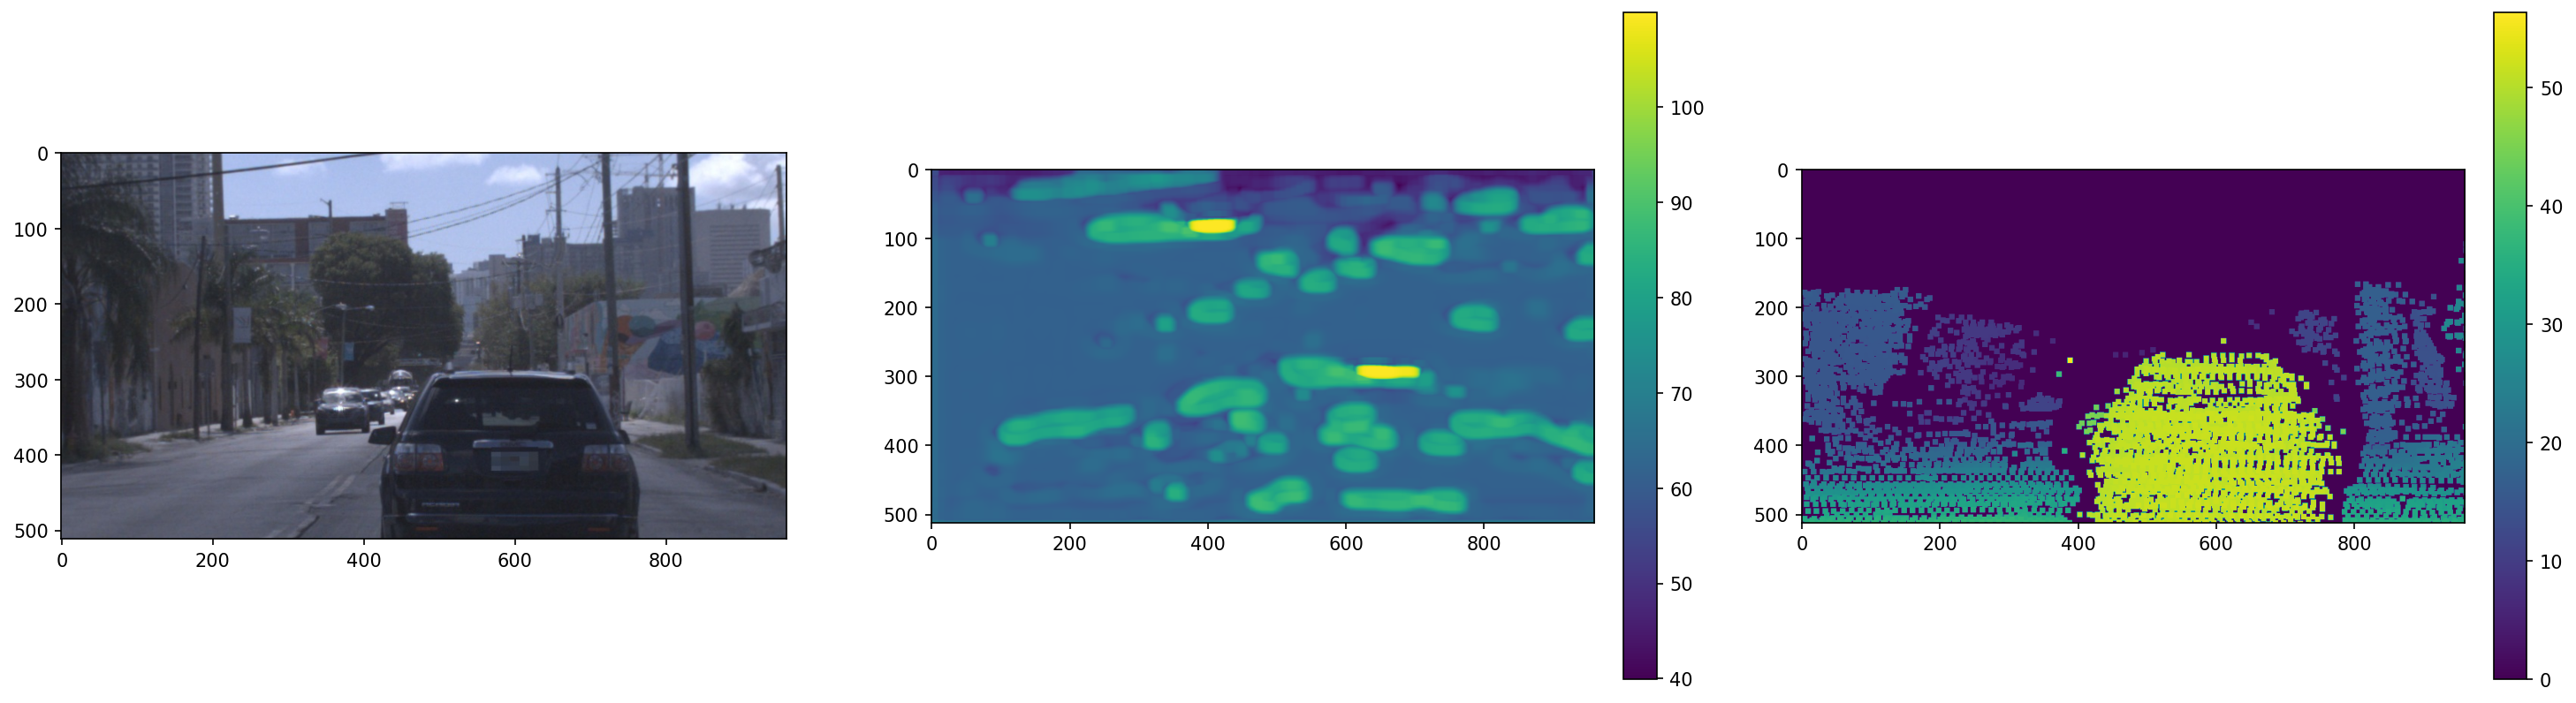

In [15]:
#Can test a single instance this way
pred, truth = test_single_instance(10, argoverse_ds_test)


## Now evaluate!

In [16]:
results_path, pred_path, truth_path, truth_obj_path, ref_img_path = test(TestImgLoader, test_iteration_limit=2)

Batch  0 out of  146
Batch  1 out of  146
Batch  2 out of  146


In [19]:

#Create save dir for disparity error images:
disp_err_path = os.path.join(results_path, 'disparity_err_img')
os.makedirs(disp_err_path, exist_ok=True)
#Convert to aboslute paths:
pred_path = Path(os.path.abspath(pred_path))
outer_truth_path = Path(os.path.abspath(os.path.join(truth_path, '..')))
disp_err_path = Path(os.path.abspath(disp_err_path))


#Create stereo evaluator:
evaluator = StereoEvaluator(
    pred_path, 
    outer_truth_path, 
    disp_err_path,
    save_disparity_error_image=True,
    num_procs=-1
)
#Evaluate:
metrics = evaluator.evaluate() 

print(f"{json.dumps(metrics, sort_keys=False, indent=4)}")

ValueError: could not broadcast input array from shape (144,1728,3) into shape (144,930,3)

In [23]:
import torchvision
#Using argoverse's stereo loader thing:
data_dir = Path("/media/sf_shared/data")
output_dir = os.path.join(os.path.abspath('./'), 'evaluation')
os.makedirs(output_dir, exist_ok=True)

#Define the transforms you want:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(512, 960)),
        torchvision.transforms.Normalize(
            mean=(0.485, 0.456, 0.406),  # ResNet mean image normalization
            std=(0.229, 0.224, 0.225),  # ResNet std image normalization
        ),
    ]
)
from argoverse.evaluation.stereo.generate_stereo_results import generate_stereo_results

#Fails because of no cude device
generate_stereo_results(model, data_dir, output_dir, transforms)
metrics = evaluator.evaluate()
print(f"{json.dumps(metrics, sort_keys=False, indent=4)}")


RuntimeError: Expected a 'cuda' device type to perform the analysis.